In [1]:
# !pip install nltk
# !pip install pandas
# !pip install stringcase
# !pip install scikit-learn
# !pip install pycountry
# !pip install requests
# !pip install bs4
# !pip install html5lib
# !pip install gender-guesser
# !pip install clean-text
# !pip uninstall emoji -Y
# !pip install emoji==1.7
# !pip install gensim
# !pip install geograpy3
# !pip install lxml

In [2]:
# import block
import pandas as pd
import numpy as np
import stringcase
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import OPTICS
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk import ne_chunk, pos_tag, word_tokenize
from nltk.tree import Tree
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

import string
import pycountry
import geograpy
import requests
from bs4 import BeautifulSoup
import re
import gender_guesser.detector as gender
from cleantext import clean
from gensim.parsing.preprocessing import remove_stopwords
import json
import csv
import os
import functools

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import urllib.request

[nltk_data] Downloading package punkt to /home/user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/user/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /home/user/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /home/user/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /home/user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/user/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
# read file block
def readSourceData():
    with open(r'source_data/tokyo_2020_tweets.csv', encoding="utf8") as f:
        reader = csv.reader(f)
        csv_rows = list(reader)
    # print(csv_rows[0])
    # print(len(csv_rows))
    # df = pd.read_csv(r'source_data/tokyo_2020_tweets.csv')
    df = pd.DataFrame.from_records(csv_rows[1:], columns=csv_rows[0])
    # df = df[:100] # use the first n rows for test!
    # print(df.shape)
    # print(df.head(5))
    df = df[(df['date'] is not None) & (df['date'] != '') & (df['text'] is not None) & (df['text'] != '')].copy()
    df.reset_index(drop=True, inplace=True)
    print(df.shape)
    # print(df)
    tweet_num = len(df['id'])
    # print(tweet_num)
    # print(df.iloc[17120]['text'])
    # print(df['text'].shape)
    # print(df['text'][17120])
    return tweet_num, df

In [4]:
# from source data to medealist events
def noise_removal(text, stop_word=True, url=True, emoji=True, punctuation=True):
    updated_text = text
    # stop word removal
    if stop_word == True:
        updated_text = remove_stopwords(updated_text)
    # url removal
    if url == True:
        updated_text = clean(updated_text, no_urls=True, lower=False)
    # emoji removal
    if emoji == True:
        updated_text = clean(updated_text, no_emoji=True, lower=False)
    # punctuation removal
    if punctuation == True:
        updated_text = updated_text.translate(str.maketrans('', '', string.punctuation))
    return updated_text


def case_folding(text):
    # case folding
    updated_text = text.lower()
    return updated_text


def normalization(text, lemmatization=False, stemming=False):
    updated_tokens = []
    # word tokenization
    tokens = word_tokenize(text)
    # lemmatization
    if lemmatization == True:
        for token in tokens:
            updated_token = WordNetLemmatizer().lemmatize(token)
            updated_tokens.append(updated_token)
    else:
        updated_tokens = tokens
    # stemming
    if stemming == True:
        for token in tokens:
            updated_token = PorterStemmer().stem(token)
            updated_tokens.append(updated_token)
    updated_text = ' '.join(updated_tokens)
    return updated_text, updated_tokens


def named_entity_tagger(text):
    # word tokenization
    tokens = word_tokenize(text)
    # pos tagging
    pos_tags = pos_tag(tokens)
    # named-entity recognition
    ner = ne_chunk(pos_tags)
    return ner


def clean_wiki_table(table):
    for i, row in table.iterrows():
        # remove string "details"
        table['Event'][i] = table['Event'][i].replace("details", "")
        # remove country name
        for country in pycountry.countries:
            country_check = [country.name, country.name.split(',')[0], country.name.split('(')[0], \
                            'ROC', 'Chinese Taipei', 'South Korea', 'North Korea', 'Great Britain', 'Czech Republic']
            for item in country_check:
                if item in table['Gold'][i]:
                    table['Gold'][i] = table['Gold'][i].replace(item, "")
                if item in table['Silver'][i]:
                    table['Silver'][i] = table['Silver'][i].replace(item, "")
                if item in table['Bronze'][i]:
                    table['Bronze'][i] = table['Bronze'][i].replace(item, "")
        # detect double or team match
        if table['Gold'][i].count(' ') >= 3:
            table['Gold'][i] = "DOUBLE OR TEAM MATCH!"
        if table['Silver'][i].count(' ') >= 3:
            table['Silver'][i] = "DOUBLE OR TEAM MATCH!"
        if table['Bronze'][i].count(' ') >= 3:
            table['Bronze'][i] = "DOUBLE OR TEAM MATCH!"
    return table


def name_extractor(text):
    names = []
    nltk_results = named_entity_tagger(text)
    for nltk_result in nltk_results:
        if (type(nltk_result) == Tree and nltk_result.label() == "PERSON"):
            name = ''
            for nltk_result_leaf in nltk_result.leaves():
                name += nltk_result_leaf[0] + ' '
            names.append(name[:-1])
    return names


def name_matcher(set_medalists, text):
    names = []
    for medalist in set_medalists:
        medalist_check = [medalist, medalist.lower(), medalist.upper(), \
                          medalist.strip(), medalist.strip().lower(), medalist.strip().upper(), \
                          medalist.replace("_", " "), medalist.replace("_", " ").lower(), medalist.replace("_", " ").upper()]
        if any(item in text for item in medalist_check):
            names.append(medalist)
    return names


def gender_extractor(text):
    female_check = ['female', 'females', 'woman', 'women']
    male_check = [' male', ' males', ' man', ' men']
    if any(item in text for item in female_check):
        sex = "female"
    elif any(item in text for item in male_check): 
        sex = "male"
    else:
        sex = "unknown"
    return sex


def country_extractor(text):
    countries = []
    for country in pycountry.countries:
        country_check = [country.name.lower(), \
                         country.name.lower().replace(" ", "_"), \
                         country.name.lower().replace(" ", ""), \
                         country.name.lower().split(',')[0], \
                         country.name.lower().split(',')[0].replace(" ", "_"), \
                         country.name.lower().split(',')[0].replace(" ", ""), \
                         country.name.lower().split('(')[0], \
                         country.name.lower().split('(')[0].replace(" ", "_"), \
                         country.name.lower().split('(')[0].replace(" ", ""), \
                        ]
        if any(item in text for item in country_check):
            countries.append(country.name)
    return countries


def sports_extractor(df_sports, text):
    sports = []
    for sport in df_sports['SPORTS NAME']:
        sport_check = [sport.lower(), sport.strip(), sport.replace(" ", "_")]
        if any(item in text for item in sport_check):
            sports.append(sport)
    return sports


def events_extractor(df_events, text):
    events = []
    for i in range(len(df_events['EVENT NAME'])):
        event = ' ' + df_events['EVENT NAME'][i]
        if event in text:
            events.append(df_events['EVENT NAME UPPER'][i])
    return events


def medal_extractor(text):
    medal = ""
    gold_check = ['gold', '1st place', 'first place', 'champion']
    silver_check = ['silver', '2nd place', 'second place']
    bronze_check = ['bronze', '3rd place', 'third place'] # runner-up is for both 2nd and 3rd
    if any(item in text for item in gold_check):
        medal = "gold"
    if any(item in text for item in silver_check):
        medal = "silver"
    if any(item in text for item in bronze_check):
        medal = "bronze"
    return medal


def crawler_medalists():
    # crawle list of medalists
    # https://olympics.com/en/olympic-games/tokyo-2020/athletes
    # https://en.wikipedia.org/wiki/List_of_2020_Summer_Olympics_medal_winners
    # https://www.fina.org/competitions/5/olympic-games-tokyo-2020/athletes?gender=&discipline=&countryId=
    url = requests.get('https://en.wikipedia.org/wiki/List_of_2020_Summer_Olympics_medal_winners').text
    soup = BeautifulSoup(url,'lxml')
    wiki_tables = soup.find_all('table', {'class':'wikitable'})
    medalists = []
    for i in range(len(wiki_tables)): # time-consuming!
        # clean table
        table = pd.read_html(str(wiki_tables))[i]
        clean_table = clean_wiki_table(table)
        # extract medalist
        for i, row in clean_table.iterrows():
            medalists.append(clean_table['Gold'][i].replace(u'\xa0', u''))
            medalists.append(clean_table['Silver'][i].replace(u'\xa0', u''))
            medalists.append(clean_table['Bronze'][i].replace(u'\xa0', u''))
    set_medalists = set(medalists)
    return set_medalists


def crawler_sports():
    # crawle list of sports and number of events in tokyo 2021
    # https://olympics.com/en/sports/
    # https://en.wikipedia.org/wiki/2020_Summer_Olympics
    # https://www.edudwar.com/tokyo-olympics-2021-sports-list-check-complete-list-of-games-sports-schedule-of-sport-number-of-players/
    url = requests.get('https://www.edudwar.com/tokyo-olympics-2021-sports-list-check-complete-list-of-games-sports-schedule-of-sport-number-of-players/').text
    soup = BeautifulSoup(url,'lxml')
    table = soup.find_all('table')
    df_sports = pd.read_html(str(table))[0][1:]
    df_sports = df_sports.rename(columns={0: 'SPORTS CLASS', 1: 'SPORTS NAME'})
    df_sports['NUM OF EVENTS'] = np.nan
    for index, row in df_sports.iterrows():
        # extract number of events
        extracted_nums = re.findall('\d+', df_sports['SPORTS NAME'][index])
        num_events = int(extracted_nums[-1])
        df_sports['NUM OF EVENTS'][index] = num_events
        # extract sports name
        df_sports['SPORTS NAME'][index] = df_sports['SPORTS NAME'][index][:-11].strip()
        if df_sports['SPORTS NAME'][index] == "":
            df_sports['SPORTS NAME'][index] = df_sports['SPORTS CLASS'][index]
    df_sports['NUM OF EVENTS'] = df_sports['NUM OF EVENTS'].astype(int)
    return df_sports


def importer_events():
    # import list of events in tokyo 2021
    df_events = pd.read_csv(r'source_data/tokyo_2020_event_list.csv', encoding='unicode_escape')
    df_events.columns = ['EVENT NAME UPPER']
    df_events['EVENT NAME'] = ''
    for i in range(0, len(df_events['EVENT NAME UPPER'])):
        df_events['EVENT NAME'][i] = noise_removal(df_events['EVENT NAME UPPER'][i], stop_word=False, url=False, emoji=False, punctuation=True)
        df_events['EVENT NAME'][i] = case_folding(df_events['EVENT NAME'][i])
    return df_events


# main function
def sourceToMedalEvent(tweet_num, df):
    
    # preprocess source data
    df['TEXT UPPER'], df['TEXT'] = "", ""
    for i in range(0, tweet_num):
        df['TEXT UPPER'][i] = noise_removal(df['text'][i], stop_word=False, url=True, emoji=True, punctuation=False)
        df['TEXT'][i] = case_folding(df['TEXT UPPER'][i])
    print(df['TEXT UPPER'])
    print(df['TEXT'])
    
    # import external data
    set_medalists = crawler_medalists()
    df_sports = crawler_sports()
    df_events = importer_events()

    # extract date with format mm-dd
    df['DATE'] = np.nan
    for i in range(0, tweet_num):
        df['DATE'][i] = df['date'][i][5:10]
    print(df['DATE'])
    
    # extract time in 24-hour clock format (keep hour and minute, drop second in time format)
    df['TIME'] = np.nan
    for i in range(0, tweet_num):
        df['TIME'][i] = df['date'][i][11:16]
    print(df['TIME'])

    # extract medalist person
    df['PERSON'] = ""
    df['PERSON_MATCH'] = ""
    for i in range(0, tweet_num):
        df['PERSON'][i] = name_extractor(df['TEXT UPPER'][i])
        df['PERSON_MATCH'][i] = name_matcher(set_medalists, df['TEXT UPPER'][i])
    print(df['PERSON'])
    print(df['PERSON_MATCH'])

    # extract medalist gender
    df['GENDER'] = ""
    for i in range(0, tweet_num):
        df['GENDER'][i] = gender_extractor(df['TEXT'][i])

    print(df['GENDER'])
    
    # extract country name
    df['COUNTRY'] = ""
    for i in range(0, tweet_num):
        df['COUNTRY'][i] = country_extractor(df['TEXT'][i])
    print(df['COUNTRY'])

    # extract sports name
    df['SPORTS'] = ""
    for i in range(0, tweet_num):
        df['SPORTS'][i] = sports_extractor(df_sports, df['TEXT'][i])
    print(df['SPORTS'])
    
    # extract events name
    df['EVENTS'] = ""
    for i in range(0, tweet_num):
        df['TEXT'][i] = noise_removal(df['TEXT'][i], stop_word=False, url=False, emoji=False, punctuation=True)
        df['EVENTS'][i] = events_extractor(df_events, df['TEXT'][i])
    print(df['EVENTS'])

    # extract medal type
    df['MEDAL'] = 0
    for i in range(0, tweet_num):
        df['MEDAL'][i]  = medal_extractor(df['TEXT'][i])
    print(df['MEDAL'])
    
    return df

In [6]:
def preProcessText(text):
    return text.replace('-', ' ').replace('_', ' ').replace('@', ' ').replace('#', ' ').strip().lower()


def dataToStringList(model_event_list):
    result = []
    for element in model_event_list:
        temp = []
        temp.extend(element['parsed_winner'])
        temp.extend(element['parsed_sports'])
        temp.extend(element['parsed_medal'])
        temp.extend(element['parsed_country'])
        temp.extend(element['parsed_event'])
        result.append(temp)
    return result


def identity_tokenizer(text):
    return text


def findMeanOfDateTime(datetime_list):
    if len(datetime_list) == 0:
        return []
    timestamplist = [datetime.timestamp(each) for each in datetime_list]
    arr_timestamplist = np.array([timestamplist])
    mean_timestamp = round(np.mean(arr_timestamplist))
    mean_datetime = datetime.fromtimestamp(mean_timestamp)
    return [mean_datetime]


def sortByStringContains(item2, item1):
    if item1 in item2 and len(item2) > len(item1):
        return -1
    else:
        return 0


def deduplicateMedalEvent(medal_event_list):
    print(datetime.now().isoformat() + ": Start Preprocess Tweets for Classification with " + str(len(medal_event_list)) + " tweets")
    parsed_medal_event_list = []
    parsed_medal_event_list_timestamp = []
    for element in medal_event_list:
        if element['medal'] is None or element['medal'] == "":
            continue
        element['parsed_winner'] = [preProcessText(each) for each in element['winner']]
        element['parsed_sports'] = [preProcessText(each) for each in element['sports']]
        element['parsed_medal'] = [preProcessText(element['medal']).replace('medal', '').replace('medals', '').strip()]
        element['parsed_country'] = [preProcessText(each) for each in element['country']]
        element['parsed_event'] = [preProcessText(each) for each in element['event']]
        parsed_medal_event_list_timestamp.append(datetime.strptime(element['datetime'], "%Y-%m-%d  %H:%M:%S").timestamp())
        parsed_medal_event_list.append(element)
    # print(parsed_medal_event_list)
    event_doc_list = dataToStringList(parsed_medal_event_list)
    print(datetime.now().isoformat() + ": Start Calculate tf-idf for Classification with " + str(len(parsed_medal_event_list)) + " tweets detected medal")
    # print(event_doc_list)
    tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, stop_words=None, lowercase=False)
    # tfidf = CountVectorizer(tokenizer=identity_tokenizer, stop_words=None, lowercase=False)
    tfidf_matrix = tfidf.fit_transform(event_doc_list)
    print(datetime.now().isoformat() + ": Start tf-idf to Dataframe for Classification")
    # r = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
    # print(r)
    print(datetime.now().isoformat() + ": Start Calculate Cluster Algo for Classification")
    nparray_tfidf_matrix = tfidf_matrix.toarray()
    # print(nparray_tfidf_matrix.shape)
    scaler = MinMaxScaler()
    arr = scaler.fit_transform(np.transpose([parsed_medal_event_list_timestamp]))
    # print(np.transpose(arr).shape)
    # print(np.ones(nparray_tfidf_matrix.shape[0]).shape)
    # print(arr)
    # print(np.min(arr))
    # print(np.max(arr))
    # comment below if not use timestamp for cluster
    nparray_tfidf_matrix = np.c_[nparray_tfidf_matrix, arr]
    # print(nparray_tfidf_matrix.shape)
    # print(nparray_tfidf_matrix[0])
    # clustering = OPTICS(min_samples=50).fit(nparray_tfidf_matrix)
    # total event around 210 in 24070 valid events
    # clustering = KMeans(n_clusters=210).fit(nparray_tfidf_matrix)
    clustering = KMeans(n_clusters=210).fit(nparray_tfidf_matrix)
    print(clustering.labels_)
    # print(cosine_similarity(tfidf_matrix[0:1], tfidf_matrix))
    grouped_event_doc = {}
    labeled_event_list = {}
    idx = 0
    print(datetime.now().isoformat() + ": Start process Classified Events")
    for label_of_each_doc in clustering.labels_:
        if label_of_each_doc not in grouped_event_doc:
            grouped_event_doc[label_of_each_doc] = []
        if label_of_each_doc not in labeled_event_list:
            labeled_event_list[label_of_each_doc] = []
        grouped_event_doc[label_of_each_doc].append(event_doc_list[idx])
        labeled_event_list[label_of_each_doc].append(parsed_medal_event_list[idx])
        idx = idx + 1
    # print(grouped_event_doc)
    grouped_event_list = {}
    result = []
    unclustered_tweets = grouped_event_doc.pop(-1, None)
    if unclustered_tweets is not None:
        print("Unclustered Tweets: " + str(len(unclustered_tweets)))
    for label in grouped_event_doc:
        print(datetime.now().isoformat() + ": Processing Cluster[" + str(label) + "] Start Calculate CountVectorizer")
        vectorizer = CountVectorizer(tokenizer=identity_tokenizer, stop_words=None, lowercase=False)
        count_matrix = vectorizer.fit_transform(grouped_event_doc[label])
        sum_count_matrix = count_matrix.toarray().sum(axis=0)
        # print(vectorizer.get_feature_names_out())
        r = pd.DataFrame([sum_count_matrix], columns=vectorizer.get_feature_names_out())
        doc_freq = r.T.sort_values(by=[0], ascending=False)
        # print(doc_freq)
        winner = []
        sport = []
        country = []
        medal = []
        datetimestr = []
        temp_event = []
        each_labeled_event_list = labeled_event_list[label]
        for idx in doc_freq.index:
            for event in each_labeled_event_list:
                datetimestr.append(event['datetime'])
                if idx in event['parsed_winner']:
                    winner.append(stringcase.titlecase(idx))
                elif idx in event['parsed_sports']:
                    sport.append(stringcase.titlecase(idx))
                elif idx in event['parsed_medal']:
                    medal.append(stringcase.titlecase(idx))
                elif idx in event['parsed_country']:
                    country.append(stringcase.titlecase(idx))
                elif idx in event['parsed_event']:
                    temp_event.append(stringcase.titlecase(idx))
        # to sort swap the longest math so full term will be select
        # for example Women's and Women's 49kg required to sort out Women's 49kg
        winner.sort(key=functools.cmp_to_key(sortByStringContains))
        sport.sort(key=functools.cmp_to_key(sortByStringContains))
        temp_event.sort(key=functools.cmp_to_key(sortByStringContains))
        each_groupped_event = {}
        each_groupped_event['winner'] = list(set(winner[0:1]))
        # each_groupped_event['sports'] = list(set(sport[0:1]))
        each_groupped_event['sports'] = list()
        temp_top_sport = list(set(sport[0:1]))
        temp_top_event = list(set(temp_event[0:1]))
        if len(temp_top_sport) == 1 and len(temp_top_event) == 1:
            each_groupped_event['sports'].append(temp_top_sport[0] + " - " + temp_top_event[0])
        elif len(temp_top_sport) == 1 and len(temp_top_event) == 0:
            each_groupped_event['sports'].append(temp_top_sport[0])
        elif len(temp_top_sport) == 0 and len(temp_top_event) == 1:
            each_groupped_event['sports'].append(temp_top_event[0])
        each_groupped_event['medal'] = list(set(medal[0:1]))
        each_groupped_event['country'] = list(set(country[0:1]))
        # datetimelist = sorted([datetime.strptime(each, "%d/%m/%Y  %I:%M:%S %p") for each in datetimestr])
        datetimelist = sorted([datetime.strptime(each, "%Y-%m-%d  %H:%M:%S") for each in datetimestr])
        datetimelist = findMeanOfDateTime(datetimelist)
        # print(datetimelist)
        each_groupped_event['datetime'] = [each.isoformat() for each in datetimelist[0:1]]
        each_groupped_event['tweets'] = [each['tweet'] for each in each_labeled_event_list]
        result.append(each_groupped_event)
        print(datetime.now().isoformat() + ": Processing Cluster[" + str(label) + "] End Calculate CountVectorizer")
    return result

In [7]:
def drawChart(deduplicated_medal_event_list):
    print('drawChart start')
    df_sourcedata = readSourceData()

In [7]:
# main block 1
print(datetime.now().isoformat() + ": Start reading source tweets")
tweet_num, df_sourcedata = readSourceData()
df_sourcedata

2022-11-14T14:11:36.619136: Start reading source tweets


(160531, 16)


id                        user_name  \
0       1418888645105356803               Abhishek Srivastav   
1       1418888377680678918         Saikhom Mirabai Channu🇮🇳   
2       1418888260886073345                     Big Breaking   
3       1418888172864299008  International Hockey Federation   
4       1418886894478270464                     Cameron Hart   
...                     ...                              ...   
160526  1419947001102405633                     Belgian Cats   
160527  1419946996895346689                        IOC MEDIA   
160528  1419946993909047299                     Devin Heroux   
160529  1419946992948576256            Ⓜ️𝐚𝐬𝐚 🍊 𝐌𝐫.𝐂𝐡𝐢𝐥𝐝𝐫𝐞𝐧 🌏   
160530  1419946985214431232            Oigetit Breaking News   

                user_location  \
0                Udupi, India   
1              Manipur, India   
2                      Global   
3                    Lausanne   
4                   Australia   
...                       ...   
160526               Brussels   
160527  Lausanne. Switzerland   
160528       Toronto, Ontario   
160529                     東京   
160530      San Francisco, CA   

                                         user_description  \
0                    Trying to be mediocre in many things   
1           Indian weightlifter 48 kg category. Champion🏆   
2       All breaking news related to Financial Market....   
3       Official International Hockey Federation Twitt...   
4                                 Football & Tennis Coach   
...                                                   ...   
160526     The Belgian National Team - Women's basketball   
160527  Keep updated with all the latest news from the...   
160528  CBC News/Olympics Reporter. Based in Toronto. ...   
160529  🗼𝑇𝑜𝑘𝑦𝑜 𝐽𝐴𝑃𝐴𝑁 🇯🇵 ✂︎ 表参道 ⭐︎ 原宿 ✂︎ 𝐻𝑎𝑖𝑟 𝑠𝑡𝑦𝑙𝑖𝑠𝑡 ✂...   
160530  Powered by AI fake news filtering technology, ...   

               user_created user_followers user_friends user_favourites  \
0       2021-02-01 06:33:51             45           39             293   
1       2018-04-07 10:10:22           5235            5            2969   
2       2021-05-29 08:51:25           3646            3               5   
3       2010-10-20 10:45:59         103975         2724           36554   
4       2020-10-31 08:46:17              6           37              31   
...                     ...            ...          ...             ...   
160526  2010-05-11 10:28:27           5296          161             973   
160527  2011-01-05 10:00:39         147657          712             624   
160528  2009-03-24 22:53:21          44209         2317          153144   
160529  2015-12-31 02:13:03            149          245           12208   
160530  2020-06-10 01:19:55            343          273            1360   

       user_verified                 date  \
0              False  2021-07-24 10:59:49   
1              False  2021-07-24 10:58:45   
2              False  2021-07-24 10:58:17   
3               True  2021-07-24 10:57:56   
4              False  2021-07-24 10:52:51   
...              ...                  ...   
160526         False  2021-07-27 09:05:21   
160527          True  2021-07-27 09:05:20   
160528          True  2021-07-27 09:05:19   
160529         False  2021-07-27 09:05:19   
160530         False  2021-07-27 09:05:17   

                                                     text  \
0                         Let the party begin\n#Tokyo2020   
1       Congratulations #Tokyo2020 https://t.co/8OFKMs...   
2       Big Breaking Now \n\nTokyo Olympic Update \n\n...   
3       Q4: 🇬🇧3-1🇿🇦\n\nGreat Britain finally find a wa...   
4       All I can think of every time I watch the ring...   
...                                                   ...   
160526  It's a close contest in our first Olympic game...   
160527  10 athletes from the IOC @RefugeesOlympic star...   
160528  SNACK TIME! \n\nHow could I say no to “two sof...   
160529  .\n.\n.\n🏄‍♂️ 𝐊𝐚𝐧𝐨𝐚 𝐈𝐠𝐚𝐫𝐚𝐬𝐡𝐢 🇯🇵\n.\n.\n🥈𝐂𝐨𝐧𝐠𝐫𝐚...   
160530  #Brea

In [8]:
# main block 2
df_medal_event_list = None
if os.path.exists('extracted_tweets.json'):
    df_medal_event_list = pd.read_json('extracted_tweets.json')
    df_medal_event_list['date'] = df_medal_event_list['date'].astype("string")
    print(df_medal_event_list)
else:
    # print(tweet_num)
    # print(medal_event_list)
    print(datetime.now().isoformat() + ": Start detect keywords in tweets")
    df_medal_event_list = sourceToMedalEvent(tweet_num, df_sourcedata)
    df_medal_event_list.to_json('extracted_tweets.json')
df_medal_event_list

2022-11-14T14:11:39.374432: Start detect keywords in tweets


0                           Let the party begin\n#Tokyo2020
1                          Congratulations #Tokyo2020 <URL>
2         Big Breaking Now\nTokyo Olympic Update\nJapan ...
3         Q4: 3-1\nGreat Britain finally find a way way ...
4         All I can think of every time I watch the ring...
                                ...                        
160526    It's a close contest in our first Olympic game...
160527    10 athletes from the IOC @RefugeesOlympic star...
160528    SNACK TIME!\nHow could I say no to "two soft s...
160529    .\n.\n.\n[?] Kanoa Igarashi\n.\n.\nCongratulat...
160530    #Breaking - It brings Tokyo's total to more th...
Name: TEXT UPPER, Length: 160531, dtype: object
0                           let the party begin\n#tokyo2020
1                          congratulations #tokyo2020 <url>
2         big breaking now\ntokyo olympic update\njapan ...
3         q4: 3-1\ngreat britain finally find a way way ...
4         all i can think of every time i watch the 

/tmp/ipykernel_1660/1294767557.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sports['NUM OF EVENTS'][index] = num_events
/tmp/ipykernel_1660/1294767557.py:204: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sports['SPORTS NAME'][index] = df_sports['SPORTS NAME'][index][:-11].strip()
/tmp/ipykernel_1660/1294767557.py:206: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sports['SPORTS NAME'][index] = df_sports['SPORTS CLASS

0         07-24
1         07-24
2         07-24
3         07-24
4         07-24
          ...  
160526    07-27
160527    07-27
160528    07-27
160529    07-27
160530    07-27
Name: DATE, Length: 160531, dtype: object


/tmp/ipykernel_1660/1294767557.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TIME'][i] = df['date'][i][11:16]


0         10:59
1         10:58
2         10:58
3         10:57
4         10:52
          ...  
160526    09:05
160527    09:05
160528    09:05
160529    09:05
160530    09:05
Name: TIME, Length: 160531, dtype: object


0                                             []
1                                    [Tokyo2020]
2                   [Tokyo Olympic Update Japan]
3         [Great Britain, Pieterse, Jack Waller]
4                                             []
                           ...                  
160526                                        []
160527                                        []
160528                                        []
160529                [Kanoa Igarashi, Zhu, Lan]
160530                                   [Tokyo]
Name: PERSON, Length: 160531, dtype: object
0                        []
1                        []
2                        []
3                        []
4                        []
                ...        
160526                   []
160527                   []
160528                   []
160529    [Kanoa Igarashi ]
160530                   []
Name: PERSON_MATCH, Length: 160531, dtype: object


0         unknown
1         unknown
2            male
3         unknown
4         unknown
           ...   
160526    unknown
160527    unknown
160528    unknown
160529    unknown
160530    unknown
Name: GENDER, Length: 160531, dtype: object


0              []
1              []
2         [Japan]
3              []
4              []
           ...   
160526         []
160527         []
160528         []
160529         []
160530         []
Name: COUNTRY, Length: 160531, dtype: object


0                   []
1                   []
2               [Judo]
3                   []
4           [Artistic]
              ...     
160526    [Basketball]
160527              []
160528              []
160529              []
160530              []
Name: SPORTS, Length: 160531, dtype: object


0              []
1              []
2         [Men's]
3              []
4              []
           ...   
160526         []
160527         []
160528         []
160529         []
160530         []
Name: EVENTS, Length: 160531, dtype: object


/tmp/ipykernel_1660/1294767557.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MEDAL'][i]  = medal_extractor(df['TEXT'][i])


0               
1               
2           gold
3               
4               
           ...  
160526          
160527          
160528          
160529    silver
160530          
Name: MEDAL, Length: 160531, dtype: object


id                        user_name  \
0       1418888645105356803               Abhishek Srivastav   
1       1418888377680678918         Saikhom Mirabai Channu🇮🇳   
2       1418888260886073345                     Big Breaking   
3       1418888172864299008  International Hockey Federation   
4       1418886894478270464                     Cameron Hart   
...                     ...                              ...   
160526  1419947001102405633                     Belgian Cats   
160527  1419946996895346689                        IOC MEDIA   
160528  1419946993909047299                     Devin Heroux   
160529  1419946992948576256            Ⓜ️𝐚𝐬𝐚 🍊 𝐌𝐫.𝐂𝐡𝐢𝐥𝐝𝐫𝐞𝐧 🌏   
160530  1419946985214431232            Oigetit Breaking News   

                user_location  \
0                Udupi, India   
1              Manipur, India   
2                      Global   
3                    Lausanne   
4                   Australia   
...                       ...   
160526               Brussels   
160527  Lausanne. Switzerland   
160528       Toronto, Ontario   
160529                     東京   
160530      San Francisco, CA   

                                         user_description  \
0                    Trying to be mediocre in many things   
1           Indian weightlifter 48 kg category. Champion🏆   
2       All breaking news related to Financial Market....   
3       Official International Hockey Federation Twitt...   
4                                 Football & Tennis Coach   
...                                                   ...   
160526     The Belgian National Team - Women's basketball   
160527  Keep updated with all the latest news from the...   
160528  CBC News/Olympics Reporter. Based in Toronto. ...   
160529  🗼𝑇𝑜𝑘𝑦𝑜 𝐽𝐴𝑃𝐴𝑁 🇯🇵 ✂︎ 表参道 ⭐︎ 原宿 ✂︎ 𝐻𝑎𝑖𝑟 𝑠𝑡𝑦𝑙𝑖𝑠𝑡 ✂...   
160530  Powered by AI fake news filtering technology, ...   

               user_created user_followers user_friends user_favourites  \
0       2021-02-01 06:33:51             45           39             293   
1       2018-04-07 10:10:22           5235            5            2969   
2       2021-05-29 08:51:25           3646            3               5   
3       2010-10-20 10:45:59         103975         2724           36554   
4       2020-10-31 08:46:17              6           37              31   
...                     ...            ...          ...             ...   
160526  2010-05-11 10:28:27           5296          161             973   
160527  2011-01-05 10:00:39         147657          712             624   
160528  2009-03-24 22:53:21          44209         2317          153144   
160529  2015-12-31 02:13:03            149          245           12208   
160530  2020-06-10 01:19:55            343          273            1360   

       user_verified                 date  ...  \
0              False  2021-07-24 10:59:49  ...   
1              False  2021-07-24 10:58:45  ...   
2              False  2021-07-24 10:58:17  ...   
3               True  2021-07-24 10:57:56  ...   
4              False  2021-07-24 10:52:51  ...   
...              ...                  ...  ...   
160526         False  2021-07-27 09:05:21  ...   
160527          True  2021-07-27 09:05:20  ...   
160528          True  2021-07-27 09:05:19  ...   
160529         False  2021-07-27 09:05:19  ...   
160530         False  2021-07-27 09:05:17  ...   

                                                     TEXT   DATE   TIME  \
0                          let the party begin\ntokyo2020  07-24  10:59   
1                           congratulations tokyo2020 url  07-24  10:58   
2       big breaking now\ntokyo olympic update\njapan ...  07-24  10:58   
3       q4 31\ngreat britain finally find a way way pi...  07-24  10:57   
4       all i can think of every time i watch the ring...  07-24  10:52   
...                                                   ...    ...    ...   
160526  its a close contest in our first olympic game ...  07-27  09:05   
160527  10 athletes from

In [9]:
# main block 3
deduplicated_medal_event_list = []
if os.path.exists('classified_medal_event_list.json'):
    with open('classified_medal_event_list.json', encoding="utf8") as json_file:
        deduplicated_medal_event_list = json.load(json_file)
else:
    medal_event_list = df_medal_event_list.rename(
        columns={'date': 'datetime', 'PERSON_MATCH': 'winner', 'COUNTRY': 'country', 'SPORTS': 'sports',
                 'MEDAL': 'medal',
                 'id': 'tweet', 'EVENTS': 'event'}).to_dict('records')
    # print(medal_event_list[0])
    deduplicated_medal_event_list = deduplicateMedalEvent(medal_event_list)
    jsonStr = json.dumps(deduplicated_medal_event_list, indent=2)
    with open("classified_medal_event_list.json", "w", encoding="utf8") as outfile:
        outfile.write(jsonStr)
deduplicated_medal_event_list

2022-11-14T14:49:56.454166: Start Preprocess Tweets for Classification with 160531 tweets


2022-11-14T14:49:57.184821: Start Calculate tf-idf for Classification with 24105 tweets detected medal
2022-11-14T14:49:57.302136: Start tf-idf to Dataframe for Classification
2022-11-14T14:49:57.302177: Start Calculate Cluster Algo for Classification


[ 98  25  25 ... 154 100 123]
2022-11-14T14:52:15.284730: Start process Classified Events
2022-11-14T14:52:15.300407: Processing Cluster[98] Start Calculate CountVectorizer
2022-11-14T14:52:15.319439: Processing Cluster[98] End Calculate CountVectorizer
2022-11-14T14:52:15.319481: Processing Cluster[25] Start Calculate CountVectorizer
2022-11-14T14:52:15.347629: Processing Cluster[25] End Calculate CountVectorizer
2022-11-14T14:52:15.347684: Processing Cluster[71] Start Calculate CountVectorizer
2022-11-14T14:52:15.353474: Processing Cluster[71] End Calculate CountVectorizer
2022-11-14T14:52:15.353509: Processing Cluster[80] Start Calculate CountVectorizer
2022-11-14T14:52:15.373678: Processing Cluster[80] End Calculate CountVectorizer
2022-11-14T14:52:15.373722: Processing Cluster[13] Start Calculate CountVectorizer
2022-11-14T14:52:15.382230: Processing Cluster[13] End Calculate CountVectorizer
2022-11-14T14:52:15.382271: Processing Cluster[72] Start Calculate CountVectorizer
2022-11

2022-11-14T14:52:15.503475: Processing Cluster[44] End Calculate CountVectorizer
2022-11-14T14:52:15.503594: Processing Cluster[74] Start Calculate CountVectorizer
2022-11-14T14:52:15.525986: Processing Cluster[74] End Calculate CountVectorizer
2022-11-14T14:52:15.526028: Processing Cluster[95] Start Calculate CountVectorizer
2022-11-14T14:52:15.530289: Processing Cluster[95] End Calculate CountVectorizer
2022-11-14T14:52:15.530322: Processing Cluster[43] Start Calculate CountVectorizer
2022-11-14T14:52:15.561453: Processing Cluster[43] End Calculate CountVectorizer
2022-11-14T14:52:15.561496: Processing Cluster[50] Start Calculate CountVectorizer
2022-11-14T14:52:15.632305: Processing Cluster[50] End Calculate CountVectorizer
2022-11-14T14:52:15.632353: Processing Cluster[12] Start Calculate CountVectorizer
2022-11-14T14:52:15.641113: Processing Cluster[12] End Calculate CountVectorizer
2022-11-14T14:52:15.641158: Processing Cluster[101] Start Calculate CountVectorizer
2022-11-14T14:5

2022-11-14T14:52:15.721241: Processing Cluster[131] End Calculate CountVectorizer
2022-11-14T14:52:15.721356: Processing Cluster[29] Start Calculate CountVectorizer
2022-11-14T14:52:15.731386: Processing Cluster[29] End Calculate CountVectorizer
2022-11-14T14:52:15.731431: Processing Cluster[111] Start Calculate CountVectorizer
2022-11-14T14:52:15.740864: Processing Cluster[111] End Calculate CountVectorizer
2022-11-14T14:52:15.740915: Processing Cluster[42] Start Calculate CountVectorizer
2022-11-14T14:52:15.774242: Processing Cluster[42] End Calculate CountVectorizer
2022-11-14T14:52:15.774286: Processing Cluster[197] Start Calculate CountVectorizer
2022-11-14T14:52:15.779820: Processing Cluster[197] End Calculate CountVectorizer
2022-11-14T14:52:15.779865: Processing Cluster[186] Start Calculate CountVectorizer
2022-11-14T14:52:15.798667: Processing Cluster[186] End Calculate CountVectorizer
2022-11-14T14:52:15.798710: Processing Cluster[39] Start Calculate CountVectorizer
2022-11-1

2022-11-14T14:52:15.977763: Processing Cluster[113] End Calculate CountVectorizer
2022-11-14T14:52:15.977956: Processing Cluster[92] Start Calculate CountVectorizer
2022-11-14T14:52:15.987286: Processing Cluster[92] End Calculate CountVectorizer
2022-11-14T14:52:15.987335: Processing Cluster[64] Start Calculate CountVectorizer
2022-11-14T14:52:15.993207: Processing Cluster[64] End Calculate CountVectorizer
2022-11-14T14:52:15.993244: Processing Cluster[136] Start Calculate CountVectorizer
2022-11-14T14:52:15.998969: Processing Cluster[136] End Calculate CountVectorizer
2022-11-14T14:52:15.999007: Processing Cluster[180] Start Calculate CountVectorizer
2022-11-14T14:52:16.003727: Processing Cluster[180] End Calculate CountVectorizer
2022-11-14T14:52:16.003777: Processing Cluster[171] Start Calculate CountVectorizer
2022-11-14T14:52:16.007390: Processing Cluster[171] End Calculate CountVectorizer
2022-11-14T14:52:16.007434: Processing Cluster[120] Start Calculate CountVectorizer
2022-11-

2022-11-14T14:52:16.195122: Processing Cluster[31] End Calculate CountVectorizer
2022-11-14T14:52:16.195627: Processing Cluster[179] Start Calculate CountVectorizer
2022-11-14T14:52:16.203268: Processing Cluster[179] End Calculate CountVectorizer
2022-11-14T14:52:16.203343: Processing Cluster[52] Start Calculate CountVectorizer
2022-11-14T14:52:16.225087: Processing Cluster[52] End Calculate CountVectorizer
2022-11-14T14:52:16.225134: Processing Cluster[54] Start Calculate CountVectorizer
2022-11-14T14:52:16.233442: Processing Cluster[54] End Calculate CountVectorizer
2022-11-14T14:52:16.233482: Processing Cluster[102] Start Calculate CountVectorizer
2022-11-14T14:52:16.240943: Processing Cluster[102] End Calculate CountVectorizer
2022-11-14T14:52:16.240981: Processing Cluster[165] Start Calculate CountVectorizer
2022-11-14T14:52:16.262223: Processing Cluster[165] End Calculate CountVectorizer
2022-11-14T14:52:16.262265: Processing Cluster[91] Start Calculate CountVectorizer
2022-11-14

2022-11-14T14:52:16.591591: Processing Cluster[177] End Calculate CountVectorizer
2022-11-14T14:52:16.591740: Processing Cluster[148] Start Calculate CountVectorizer
2022-11-14T14:52:16.603208: Processing Cluster[148] End Calculate CountVectorizer
2022-11-14T14:52:16.603250: Processing Cluster[147] Start Calculate CountVectorizer
2022-11-14T14:52:16.613286: Processing Cluster[147] End Calculate CountVectorizer
2022-11-14T14:52:16.613328: Processing Cluster[26] Start Calculate CountVectorizer
2022-11-14T14:52:16.618285: Processing Cluster[26] End Calculate CountVectorizer
2022-11-14T14:52:16.618323: Processing Cluster[208] Start Calculate CountVectorizer
2022-11-14T14:52:16.622311: Processing Cluster[208] End Calculate CountVectorizer
2022-11-14T14:52:16.622346: Processing Cluster[167] Start Calculate CountVectorizer
2022-11-14T14:52:16.629672: Processing Cluster[167] End Calculate CountVectorizer
2022-11-14T14:52:16.629715: Processing Cluster[124] Start Calculate CountVectorizer
2022-1

2022-11-14T14:52:16.806290: Processing Cluster[51] End Calculate CountVectorizer
2022-11-14T14:52:16.806499: Processing Cluster[176] Start Calculate CountVectorizer
2022-11-14T14:52:16.812338: Processing Cluster[176] End Calculate CountVectorizer
2022-11-14T14:52:16.812377: Processing Cluster[53] Start Calculate CountVectorizer
2022-11-14T14:52:16.817404: Processing Cluster[53] End Calculate CountVectorizer
2022-11-14T14:52:16.817460: Processing Cluster[109] Start Calculate CountVectorizer
2022-11-14T14:52:16.831596: Processing Cluster[109] End Calculate CountVectorizer
2022-11-14T14:52:16.831650: Processing Cluster[128] Start Calculate CountVectorizer
2022-11-14T14:52:16.865797: Processing Cluster[128] End Calculate CountVectorizer
2022-11-14T14:52:16.865840: Processing Cluster[19] Start Calculate CountVectorizer
2022-11-14T14:52:16.871966: Processing Cluster[19] End Calculate CountVectorizer
2022-11-14T14:52:16.872016: Processing Cluster[65] Start Calculate CountVectorizer
2022-11-14

2022-11-14T14:52:17.064086: Processing Cluster[16] End Calculate CountVectorizer
2022-11-14T14:52:17.064245: Processing Cluster[187] Start Calculate CountVectorizer
2022-11-14T14:52:17.074437: Processing Cluster[187] End Calculate CountVectorizer
2022-11-14T14:52:17.074488: Processing Cluster[152] Start Calculate CountVectorizer
2022-11-14T14:52:17.078979: Processing Cluster[152] End Calculate CountVectorizer
2022-11-14T14:52:17.079025: Processing Cluster[82] Start Calculate CountVectorizer
2022-11-14T14:52:17.095370: Processing Cluster[82] End Calculate CountVectorizer
2022-11-14T14:52:17.095427: Processing Cluster[185] Start Calculate CountVectorizer
2022-11-14T14:52:17.103651: Processing Cluster[185] End Calculate CountVectorizer
2022-11-14T14:52:17.103706: Processing Cluster[132] Start Calculate CountVectorizer
2022-11-14T14:52:17.111159: Processing Cluster[132] End Calculate CountVectorizer
2022-11-14T14:52:17.111204: Processing Cluster[142] Start Calculate CountVectorizer
2022-11

2022-11-14T14:52:17.294546: Processing Cluster[182] End Calculate CountVectorizer
2022-11-14T14:52:17.294661: Processing Cluster[191] Start Calculate CountVectorizer
2022-11-14T14:52:17.305652: Processing Cluster[191] End Calculate CountVectorizer
2022-11-14T14:52:17.305691: Processing Cluster[158] Start Calculate CountVectorizer
2022-11-14T14:52:17.310569: Processing Cluster[158] End Calculate CountVectorizer
2022-11-14T14:52:17.310613: Processing Cluster[75] Start Calculate CountVectorizer
2022-11-14T14:52:17.323999: Processing Cluster[75] End Calculate CountVectorizer
2022-11-14T14:52:17.324041: Processing Cluster[125] Start Calculate CountVectorizer
2022-11-14T14:52:17.387466: Processing Cluster[125] End Calculate CountVectorizer
2022-11-14T14:52:17.387515: Processing Cluster[173] Start Calculate CountVectorizer
2022-11-14T14:52:17.392494: Processing Cluster[173] End Calculate CountVectorizer
2022-11-14T14:52:17.392528: Processing Cluster[2] Start Calculate CountVectorizer
2022-11-

2022-11-14T14:52:17.505520: Processing Cluster[68] End Calculate CountVectorizer
2022-11-14T14:52:17.505640: Processing Cluster[144] Start Calculate CountVectorizer
2022-11-14T14:52:17.511888: Processing Cluster[144] End Calculate CountVectorizer
2022-11-14T14:52:17.511922: Processing Cluster[90] Start Calculate CountVectorizer
2022-11-14T14:52:17.518270: Processing Cluster[90] End Calculate CountVectorizer
2022-11-14T14:52:17.518307: Processing Cluster[10] Start Calculate CountVectorizer
2022-11-14T14:52:17.521130: Processing Cluster[10] End Calculate CountVectorizer
2022-11-14T14:52:17.521170: Processing Cluster[45] Start Calculate CountVectorizer
2022-11-14T14:52:17.530554: Processing Cluster[45] End Calculate CountVectorizer
2022-11-14T14:52:17.530593: Processing Cluster[201] Start Calculate CountVectorizer
2022-11-14T14:52:17.535238: Processing Cluster[201] End Calculate CountVectorizer
2022-11-14T14:52:17.535279: Processing Cluster[175] Start Calculate CountVectorizer
2022-11-14T

2022-11-14T14:52:17.732079: Processing Cluster[3] End Calculate CountVectorizer
2022-11-14T14:52:17.732244: Processing Cluster[199] Start Calculate CountVectorizer
2022-11-14T14:52:17.737534: Processing Cluster[199] End Calculate CountVectorizer
2022-11-14T14:52:17.737586: Processing Cluster[11] Start Calculate CountVectorizer
2022-11-14T14:52:17.763176: Processing Cluster[11] End Calculate CountVectorizer
2022-11-14T14:52:17.763225: Processing Cluster[21] Start Calculate CountVectorizer
2022-11-14T14:52:17.773936: Processing Cluster[21] End Calculate CountVectorizer
2022-11-14T14:52:17.773983: Processing Cluster[105] Start Calculate CountVectorizer
2022-11-14T14:52:17.780063: Processing Cluster[105] End Calculate CountVectorizer
2022-11-14T14:52:17.780099: Processing Cluster[209] Start Calculate CountVectorizer


2022-11-14T14:52:17.966036: Processing Cluster[209] End Calculate CountVectorizer
2022-11-14T14:52:17.966192: Processing Cluster[184] Start Calculate CountVectorizer
2022-11-14T14:52:17.973168: Processing Cluster[184] End Calculate CountVectorizer
2022-11-14T14:52:17.973204: Processing Cluster[126] Start Calculate CountVectorizer
2022-11-14T14:52:17.977298: Processing Cluster[126] End Calculate CountVectorizer
2022-11-14T14:52:17.977361: Processing Cluster[143] Start Calculate CountVectorizer
2022-11-14T14:52:17.989757: Processing Cluster[143] End Calculate CountVectorizer
2022-11-14T14:52:17.989798: Processing Cluster[205] Start Calculate CountVectorizer
2022-11-14T14:52:17.996351: Processing Cluster[205] End Calculate CountVectorizer
2022-11-14T14:52:17.996389: Processing Cluster[99] Start Calculate CountVectorizer
2022-11-14T14:52:18.004635: Processing Cluster[99] End Calculate CountVectorizer
2022-11-14T14:52:18.004692: Processing Cluster[174] Start Calculate CountVectorizer
2022-1

2022-11-14T14:52:18.180800: Processing Cluster[112] End Calculate CountVectorizer
2022-11-14T14:52:18.180936: Processing Cluster[135] Start Calculate CountVectorizer
2022-11-14T14:52:18.187061: Processing Cluster[135] End Calculate CountVectorizer
2022-11-14T14:52:18.187101: Processing Cluster[97] Start Calculate CountVectorizer
2022-11-14T14:52:18.189247: Processing Cluster[97] End Calculate CountVectorizer
2022-11-14T14:52:18.189285: Processing Cluster[188] Start Calculate CountVectorizer
2022-11-14T14:52:18.193660: Processing Cluster[188] End Calculate CountVectorizer


[{'winner': ['Naohisa Takato'],
  'sports': ["Judo - Men's"],
  'medal': ['Gold'],
  'country': ['Japan'],
  'datetime': ['2021-07-24T22:59:11'],
  'tweets': ['1418888260886073345',
   '1418889096337010694',
   '1418889072433639425',
   '1418888691582394369',
   '1418888541300531211',
   '1418888477370896384',
   '1418887739454357504',
   '1418887315410362371',
   '1418886800710377472',
   '1418886434086400008',
   '1418886404646473728',
   '1418885777656791042',
   '1418885408285466630',
   '1418885381320167424',
   '1418885333794570241',
   '1418885124268122114',
   '1418884095690612741',
   '1418880531123613700',
   '1418879821682204681',
   '1418878753745289229',
   '1418878710476951553',
   '1418877691579731981',
   '1418877206495850496',
   '1418876871773548544',
   '1418876822620622852',
   '1418876029775581187',
   '1418868763101777920',
   '1418863538425192453',
   '1418898474012135425',
   '1418895047970414592',
   '1418894983499849734',
   '1418894801940979722',
   '14188937

In [8]:
# main block 4
#drawChart(deduplicated_medal_event_list)
def readCSV2List(filePath):
    try:
        file=open(filePath,'r',encoding="gbk")
        context = file.read()
        list_result=context.split("\n")
        length=len(list_result)
        for i in range(length):
            list_result[i]=list_result[i].split(",")
        return list_result
    except Exception :
        print("error")
    finally:
        file.close();
        
with open('classified_medal_event_list.json','r',encoding='utf-8') as f :
    data = json.load(f)
Vdata = readCSV2List('source_data/verification_list.csv')

#datas for Entire time range
#win:winner,spr:sports,con:country,med:medal
dates_T = []
Nwin_T = []
Nspr_T = []
Ncon_T = []
Nmed_T = []
NT=[]
#Result datas for Gold/Silver/Bronze medals 
dates_G = []
Nwin_G = []
Nspr_G = []
Ncon_G = []
Nmed_G = []
NG=[]
dates_S = []
Nwin_S = []
Nspr_S = []
Ncon_S = []
Nmed_S = []
NS=[]
dates_B = []
Nwin_B = []
Nspr_B = []
Ncon_B = []
Nmed_B = []
NB=[]
for item in data:
    if True:
        dates_T.append(''.join(item['datetime']))
        Nwin_T.append(''.join(item['winner']))
        Nspr_T.append(''.join(item['sports']))
        Ncon_T.append(''.join(item['country']))
        Nmed_T.append(''.join(item['medal']))
        NT.append(''.join(item['country'])+'\n'+''.join(item['winner'])+'\n'+''.join(item['sports'])+'\n'+''.join(item['medal']))
dates_T = [datetime.strptime(d, "%Y-%m-%dT%H:%M:%S") for d in dates_T]

for item in data:
    if ''.join(item['medal'])=='Gold':
        dates_G.append(''.join(item['datetime']))
        Nwin_G.append(''.join(item['winner']))
        Nspr_G.append(''.join(item['sports']))
        Ncon_G.append(''.join(item['country']))
        Nmed_G.append(''.join(item['medal']))
        NG.append(''.join(item['country'])+'\n'+''.join(item['winner'])+'\n'+''.join(item['sports'])+'\n'+''.join(item['medal']))
    elif''.join(item['medal'])=='Silver':
        dates_S.append(''.join(item['datetime']))
        Nwin_S.append(''.join(item['winner']))
        Nspr_S.append(''.join(item['sports']))
        Ncon_S.append(''.join(item['country']))
        Nmed_S.append(''.join(item['medal']))
        NS.append(''.join(item['country'])+'\n'+''.join(item['winner'])+'\n'+''.join(item['sports'])+'\n'+''.join(item['medal']))
    elif''.join(item['medal'])=='Bronze':
        dates_B.append(''.join(item['datetime']))
        Nwin_B.append(''.join(item['winner']))
        Nspr_B.append(''.join(item['sports']))
        Ncon_B.append(''.join(item['country']))
        Nmed_B.append(''.join(item['medal']))
        NB.append(''.join(item['country'])+'\n'+''.join(item['winner'])+'\n'+''.join(item['sports'])+'\n'+''.join(item['medal']))
#     else:
#         print(miss)
dates_G = [datetime.strptime(d, "%Y-%m-%dT%H:%M:%S") for d in dates_G]
dates_S = [datetime.strptime(d, "%Y-%m-%dT%H:%M:%S") for d in dates_S]
dates_B = [datetime.strptime(d, "%Y-%m-%dT%H:%M:%S") for d in dates_B]

#Result data Day1 to Day4
dates_D1 = []
Nwin_D1 = []
Nspr_D1 = []
Ncon_D1 = []
Nmed_D1 = []
ND1 = []
dates_D2 = []
Nwin_D2 = []
Nspr_D2 = []
Ncon_D2 = []
Nmed_D2 = []
ND2 = []
dates_D3 = []
Nwin_D3 = []
Nspr_D3 = []
Ncon_D3 = []
Nmed_D3 = []
ND3 = []
dates_D4 = []
Nwin_D4 = []
Nspr_D4 = []
Ncon_D4 = []
Nmed_D4 = []
ND4 = []
for item in data:
    if ''.join(item['datetime']).split("T")[0] == '2021-07-24':
        dates_D1.append(''.join(item['datetime']))
        Nwin_D1.append(''.join(item['winner']))
        Nspr_D1.append(''.join(item['sports']))
        Ncon_D1.append(''.join(item['country']))
        Nmed_D1.append(''.join(item['medal']))
        ND1.append(''.join(item['country'])+'\n'+''.join(item['winner'])+'\n'+''.join(item['sports'])+'\n'+''.join(item['medal']))
    elif ''.join(item['datetime']).split("T")[0] == '2021-07-25':
        dates_D2.append(''.join(item['datetime']))
        Nwin_D2.append(''.join(item['winner']))
        Nspr_D2.append(''.join(item['sports']))
        Ncon_D2.append(''.join(item['country']))
        Nmed_D2.append(''.join(item['medal']))
        ND2.append(''.join(item['country'])+'\n'+''.join(item['winner'])+'\n'+''.join(item['sports'])+'\n'+''.join(item['medal']))
    elif ''.join(item['datetime']).split("T")[0] == '2021-07-26':
        dates_D3.append(''.join(item['datetime']))
        Nwin_D3.append(''.join(item['winner']))
        Nspr_D3.append(''.join(item['sports']))
        Ncon_D3.append(''.join(item['country']))
        Nmed_D3.append(''.join(item['medal']))
        ND3.append(''.join(item['country'])+'\n'+''.join(item['winner'])+'\n'+''.join(item['sports'])+'\n'+''.join(item['medal']))
    elif ''.join(item['datetime']).split("T")[0] == '2021-07-27':
        dates_D4.append(''.join(item['datetime']))
        Nwin_D4.append(''.join(item['winner']))
        Nspr_D4.append(''.join(item['sports']))
        Ncon_D4.append(''.join(item['country']))
        Nmed_D4.append(''.join(item['medal']))
        ND4.append(''.join(item['country'])+'\n'+''.join(item['winner'])+'\n'+''.join(item['sports'])+'\n'+''.join(item['medal']))
#     else:
#         print(miss)
dates_D1 = [datetime.strptime(d, "%Y-%m-%dT%H:%M:%S") for d in dates_D1]
dates_D2 = [datetime.strptime(d, "%Y-%m-%dT%H:%M:%S") for d in dates_D2]
dates_D3 = [datetime.strptime(d, "%Y-%m-%dT%H:%M:%S") for d in dates_D3]
dates_D4 = [datetime.strptime(d, "%Y-%m-%dT%H:%M:%S") for d in dates_D4]

#plot gragh and generate .png to local file
#dates:date in strptime format, name:label, title:name of graph, color:color of line
#interval,density,resolution shown in function
def plotchart(dates,name,title,color,interval,density,reso):
    levels = []
    if density == 1:
        levels = np.tile([-3, 3, -2, 2, -1, 1],
                     int(np.ceil(len(dates)/6)))[:len(dates)]
    if density == 2:
        levels = np.tile([-6,6,-5,5,-4,4,-3, 3, -2, 2, -1, 1],
                     int(np.ceil(len(dates)/12)))[:len(dates)]    
    if density == 3:
        levels = np.tile([-9,+9,-8,+8,-7,7,-6,6,-5,5,-4,4,-3, 3, -2, 2, -1, 1],
                     int(np.ceil(len(dates)/18)))[:len(dates)]
    # Create figure and plot a stem plot with the date
    fig, ax = plt.subplots(figsize=reso, constrained_layout=True)
    ax.set(title = title)

    ax.vlines(dates, 0, levels, color=color)  # The vertical stems.
    ax.plot(dates, np.zeros_like(dates), "-o",
            color="k", markerfacecolor="w")  # Baseline and markers on it.

    # annotate lines
    for d, l, r in zip(dates, levels, name):
        ax.annotate(r, xy=(d, l),
                    xytext=(-3, np.sign(l)*3), textcoords="offset points",
                    horizontalalignment="right",
                    verticalalignment="bottom" if l > 0 else "top")

    # format xaxis
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=interval))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M day%d"))
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

    # remove y axis and spines
    ax.yaxis.set_visible(False)
    ax.spines[["left", "top", "right"]].set_visible(False)

    ax.margins(y=0.1)

    plt.savefig(title)
    #plt.show()

#Verification data for Gold/Silver/Bronze medals
Vdates = []
VdatesG = []
VdatesS = []
VdatesB = []
Vwin = []
Vspr = []
Vcon = []
Vmed = []
Tmedal = []
VCG = []
VCS = []
VCB = []

for item in range(len(Vdata)-1):
    if True:
        Vwin.append(Vdata[item][7])
        Vspr.append(Vdata[item][11])
        Vcon.append(Vdata[item][5])
    if Vdata[item][5] != '' and Vdata[item][7] != '' and Vdata[item][9] != '':
        Tmedal.append('Gold:'+Vdata[item][5]+Vdata[item][6])
        VCG.append(Vdata[item][5])
        VdatesG.append(Vdata[item][3])
        Tmedal.append('Silver:'+Vdata[item][7]+Vdata[item][8])
        VCS.append(Vdata[item][7])
        VdatesS.append(Vdata[item][3])
        Tmedal.append('Bronze:'+Vdata[item][9]+Vdata[item][10])
        VCB.append(Vdata[item][9])
        VdatesB.append(Vdata[item][3])
        Vcon.append(Vdata[item][5]+'\n'+Vdata[item][7]+'\n'+Vdata[item][9])
        Vdates.append(Vdata[item][3])
    elif Vdata[item][5] != '' and Vdata[item][7] != '' and Vdata[item][9] == '':
        Tmedal.append('Gold:'+Vdata[item][5]+Vdata[item][6])
        VCG.append(Vdata[item][5])
        VdatesG.append(Vdata[item][3])
        Tmedal.append('Silver:'+Vdata[item][7]+Vdata[item][8])
        VCS.append(Vdata[item][7])
        VdatesS.append(Vdata[item][3])
        Vcon.append(Vdata[item][5]+'\n'+Vdata[item][7])
        Vdates.append(Vdata[item][3])
    elif Vdata[item][5] == '' and Vdata[item][7] == '' and Vdata[item][9] != '':
        Tmedal.append('Bronze:'+Vdata[item][9]+Vdata[item][10])
        VCB.append(Vdata[item][9])
        VdatesB.append(Vdata[item][3])
        Vcon.append(Vdata[item][9])
        Vdates.append(Vdata[item][3])
    elif Vdata[item][5] != '' and Vdata[item][7] == '' and Vdata[item][9] == '':
        Tmedal.append('Gold'+Vdata[item][5]+Vdata[item][6])
        VCG.append(Vdata[item][5])
        VdatesG.append(Vdata[item][3])
        Vcon.append(Vdata[item][5])
        Vdates.append(Vdata[item][3])
#     else:
#         print(error)
                       
Vdates = [datetime.strptime(d, "%Y-%m-%dT%H:%M:%S") for d in Vdates]
VdatesG = [datetime.strptime(d, "%Y-%m-%dT%H:%M:%S") for d in VdatesG]
VdatesS = [datetime.strptime(d, "%Y-%m-%dT%H:%M:%S") for d in VdatesS]
VdatesB = [datetime.strptime(d, "%Y-%m-%dT%H:%M:%S") for d in VdatesB]

#Verification data for Day1 to Day4
Vdates_D1 = []
Vwin_D1 = []
Vspr_D1 = []
Vcon_D1 = []
Vmed_D1 = []
VD1 = []
Vdates_D2 = []
Vwin_D2 = []
Vspr_D2 = []
Vcon_D2 = []
Vmed_D2 = []
VD2 = []
Vdates_D3 = []
Vwin_D3 = []
Vspr_D3 = []
Vcon_D3 = []
Vmed_D3 = []
VD3 = []
Vdates_D4 = []
Vwin_D4 = []
Vspr_D4 = []
Vcon_D4 = []
Vmed_D4 = []
VD4 = []
for item in range(len(Vdata)-1):
    if Vdata[item][3].split("T")[0] == '2021-07-24':
        Vdates_D1.append(Vdata[item][3])
        Vwin_D1.append(Vdata[item][7])
        Vspr_D1.append(Vdata[item][11])
        Vcon_D1.append(Vdata[item][5])
        if (Vdata[item][5] != '') and (Vdata[item][7] != '') and (Vdata[item][9] != ''):
            Vmed.append('GSB')
            VD1.append(Vdata[item][11]+'\n'+'  Gold:'+Vdata[item][5]+Vdata[item][6]+'\n'+'  Silver:'+Vdata[item][7]+Vdata[item][8]+'\n'+'  Bronze:'+Vdata[item][9]+Vdata[item][10])
        elif Vdata[item][5] != '' and Vdata[item][7] != '' and Vdata[item][9] == '':
            Vmed.append('GS')
            VD1.append(Vdata[item][11]+'\n'+'  Gold:'+Vdata[item][5]+Vdata[item][6]+'\n'+'  Silver:'+Vdata[item][7]+Vdata[item][8])
        elif Vdata[item][5] == '' and Vdata[item][7] == '' and Vdata[item][9] != '':
            Vmed.append('B')
            VD1.append('Bronze:'+Vdata[item][9]+Vdata[item][10])
        elif Vdata[item][5] != '' and Vdata[item][7] == '' and Vdata[item][9] == '':
            Vmed.append('G')
            VD1.append(Vdata[item][11]+'\n'+'  Gold:'+Vdata[item][5]+Vdata[item][6])
        else:
            Vmed.append('error')            
    elif Vdata[item][3].split("T")[0] == '2021-07-25':
        Vdates_D2.append(Vdata[item][3])
        Vwin_D2.append(Vdata[item][7])
        Vspr_D2.append(Vdata[item][11])
        Vcon_D2.append(Vdata[item][5])
        if (Vdata[item][5] != '') and (Vdata[item][7] != '') and (Vdata[item][9] != ''):
            Vmed.append('GSB')
            VD2.append(Vdata[item][11]+'\n'+'  Gold:'+Vdata[item][5]+Vdata[item][6]+'\n'+'  Silver:'+Vdata[item][7]+Vdata[item][8]+'\n'+'  Bronze:'+Vdata[item][9]+Vdata[item][10])
        elif Vdata[item][5] != '' and Vdata[item][7] != '' and Vdata[item][9] == '':
            Vmed.append('GS')
            VD2.append(Vdata[item][11]+'\n'+'  Gold:'+Vdata[item][5]+Vdata[item][6]+'\n'+'  Silver:'+Vdata[item][7]+Vdata[item][8])
        elif Vdata[item][5] == '' and Vdata[item][7] == '' and Vdata[item][9] != '':
            Vmed.append('B')
            VD2.append('Bronze:'+Vdata[item][9]+Vdata[item][10])
        elif Vdata[item][5] != '' and Vdata[item][7] == '' and Vdata[item][9] == '':
            Vmed.append('G')
            VD2.append(Vdata[item][11]+'\n'+'  Gold:'+Vdata[item][5]+Vdata[item][6])
        else:
            Vmed.append('error')
    elif Vdata[item][3].split("T")[0] == '2021-07-26':
        Vdates_D3.append(Vdata[item][3])
        Vwin_D3.append(Vdata[item][7])
        Vspr_D3.append(Vdata[item][11])
        Vcon_D3.append(Vdata[item][5])
        if (Vdata[item][5] != '') and (Vdata[item][7] != '') and (Vdata[item][9] != ''):
            Vmed.append('GSB')
            VD3.append(Vdata[item][11]+'\n'+'  Gold:'+Vdata[item][5]+Vdata[item][6]+'\n'+'  Silver:'+Vdata[item][7]+Vdata[item][8]+'\n'+'  Bronze:'+Vdata[item][9]+Vdata[item][10])
        elif Vdata[item][5] != '' and Vdata[item][7] != '' and Vdata[item][9] == '':
            Vmed.append('GS')
            VD3.append(Vdata[item][11]+'\n'+'  Gold:'+Vdata[item][5]+Vdata[item][6]+'\n'+'  Silver:'+Vdata[item][7]+Vdata[item][8])
        elif Vdata[item][5] == '' and Vdata[item][7] == '' and Vdata[item][9] != '':
            Vmed.append('B')
            VD3.append('Bronze:'+Vdata[item][9]+Vdata[item][10])
        elif Vdata[item][5] != '' and Vdata[item][7] == '' and Vdata[item][9] == '':
            Vmed.append('G')
            VD3.append(Vdata[item][11]+'\n'+'  Gold:'+Vdata[item][5]+Vdata[item][6])
        else:
            Vmed.append('error')
    elif Vdata[item][3].split("T")[0] == '2021-07-27':
        Vdates_D4.append(Vdata[item][3])
        Vwin_D4.append(Vdata[item][7])
        Vspr_D4.append(Vdata[item][11])
        Vcon_D4.append(Vdata[item][5])
        if (Vdata[item][5] != '') and (Vdata[item][7] != '') and (Vdata[item][9] != ''):
            Vmed.append('GSB')
            VD4.append(Vdata[item][11]+'\n'+'  Gold:'+Vdata[item][5]+Vdata[item][6]+'\n'+'  Silver:'+Vdata[item][7]+Vdata[item][8]+'\n'+'  Bronze:'+Vdata[item][9]+Vdata[item][10])
        elif Vdata[item][5] != '' and Vdata[item][7] != '' and Vdata[item][9] == '':
            Vmed.append('GS')
            VD4.append(Vdata[item][11]+'\n'+'  Gold:'+Vdata[item][5]+Vdata[item][6]+'\n'+'  Silver:'+Vdata[item][7]+Vdata[item][8])
        elif Vdata[item][5] == '' and Vdata[item][7] == '' and Vdata[item][9] != '':
            Vmed.append('B')
            VD4.append('Bronze:'+Vdata[item][9]+Vdata[item][10])
        elif Vdata[item][5] != '' and Vdata[item][7] == '' and Vdata[item][9] == '':
            Vmed.append('G')
            VD4.append(Vdata[item][11]+'\n'+'  Gold:'+Vdata[item][5]+Vdata[item][6])
        else:
            Vmed.append('error')
#     else:
#         print(miss)
Vdates_D1 = [datetime.strptime(d, "%Y-%m-%dT%H:%M:%S") for d in Vdates_D1]
Vdates_D2 = [datetime.strptime(d, "%Y-%m-%dT%H:%M:%S") for d in Vdates_D2]
Vdates_D3 = [datetime.strptime(d, "%Y-%m-%dT%H:%M:%S") for d in Vdates_D3]
Vdates_D4 = [datetime.strptime(d, "%Y-%m-%dT%H:%M:%S") for d in Vdates_D4]

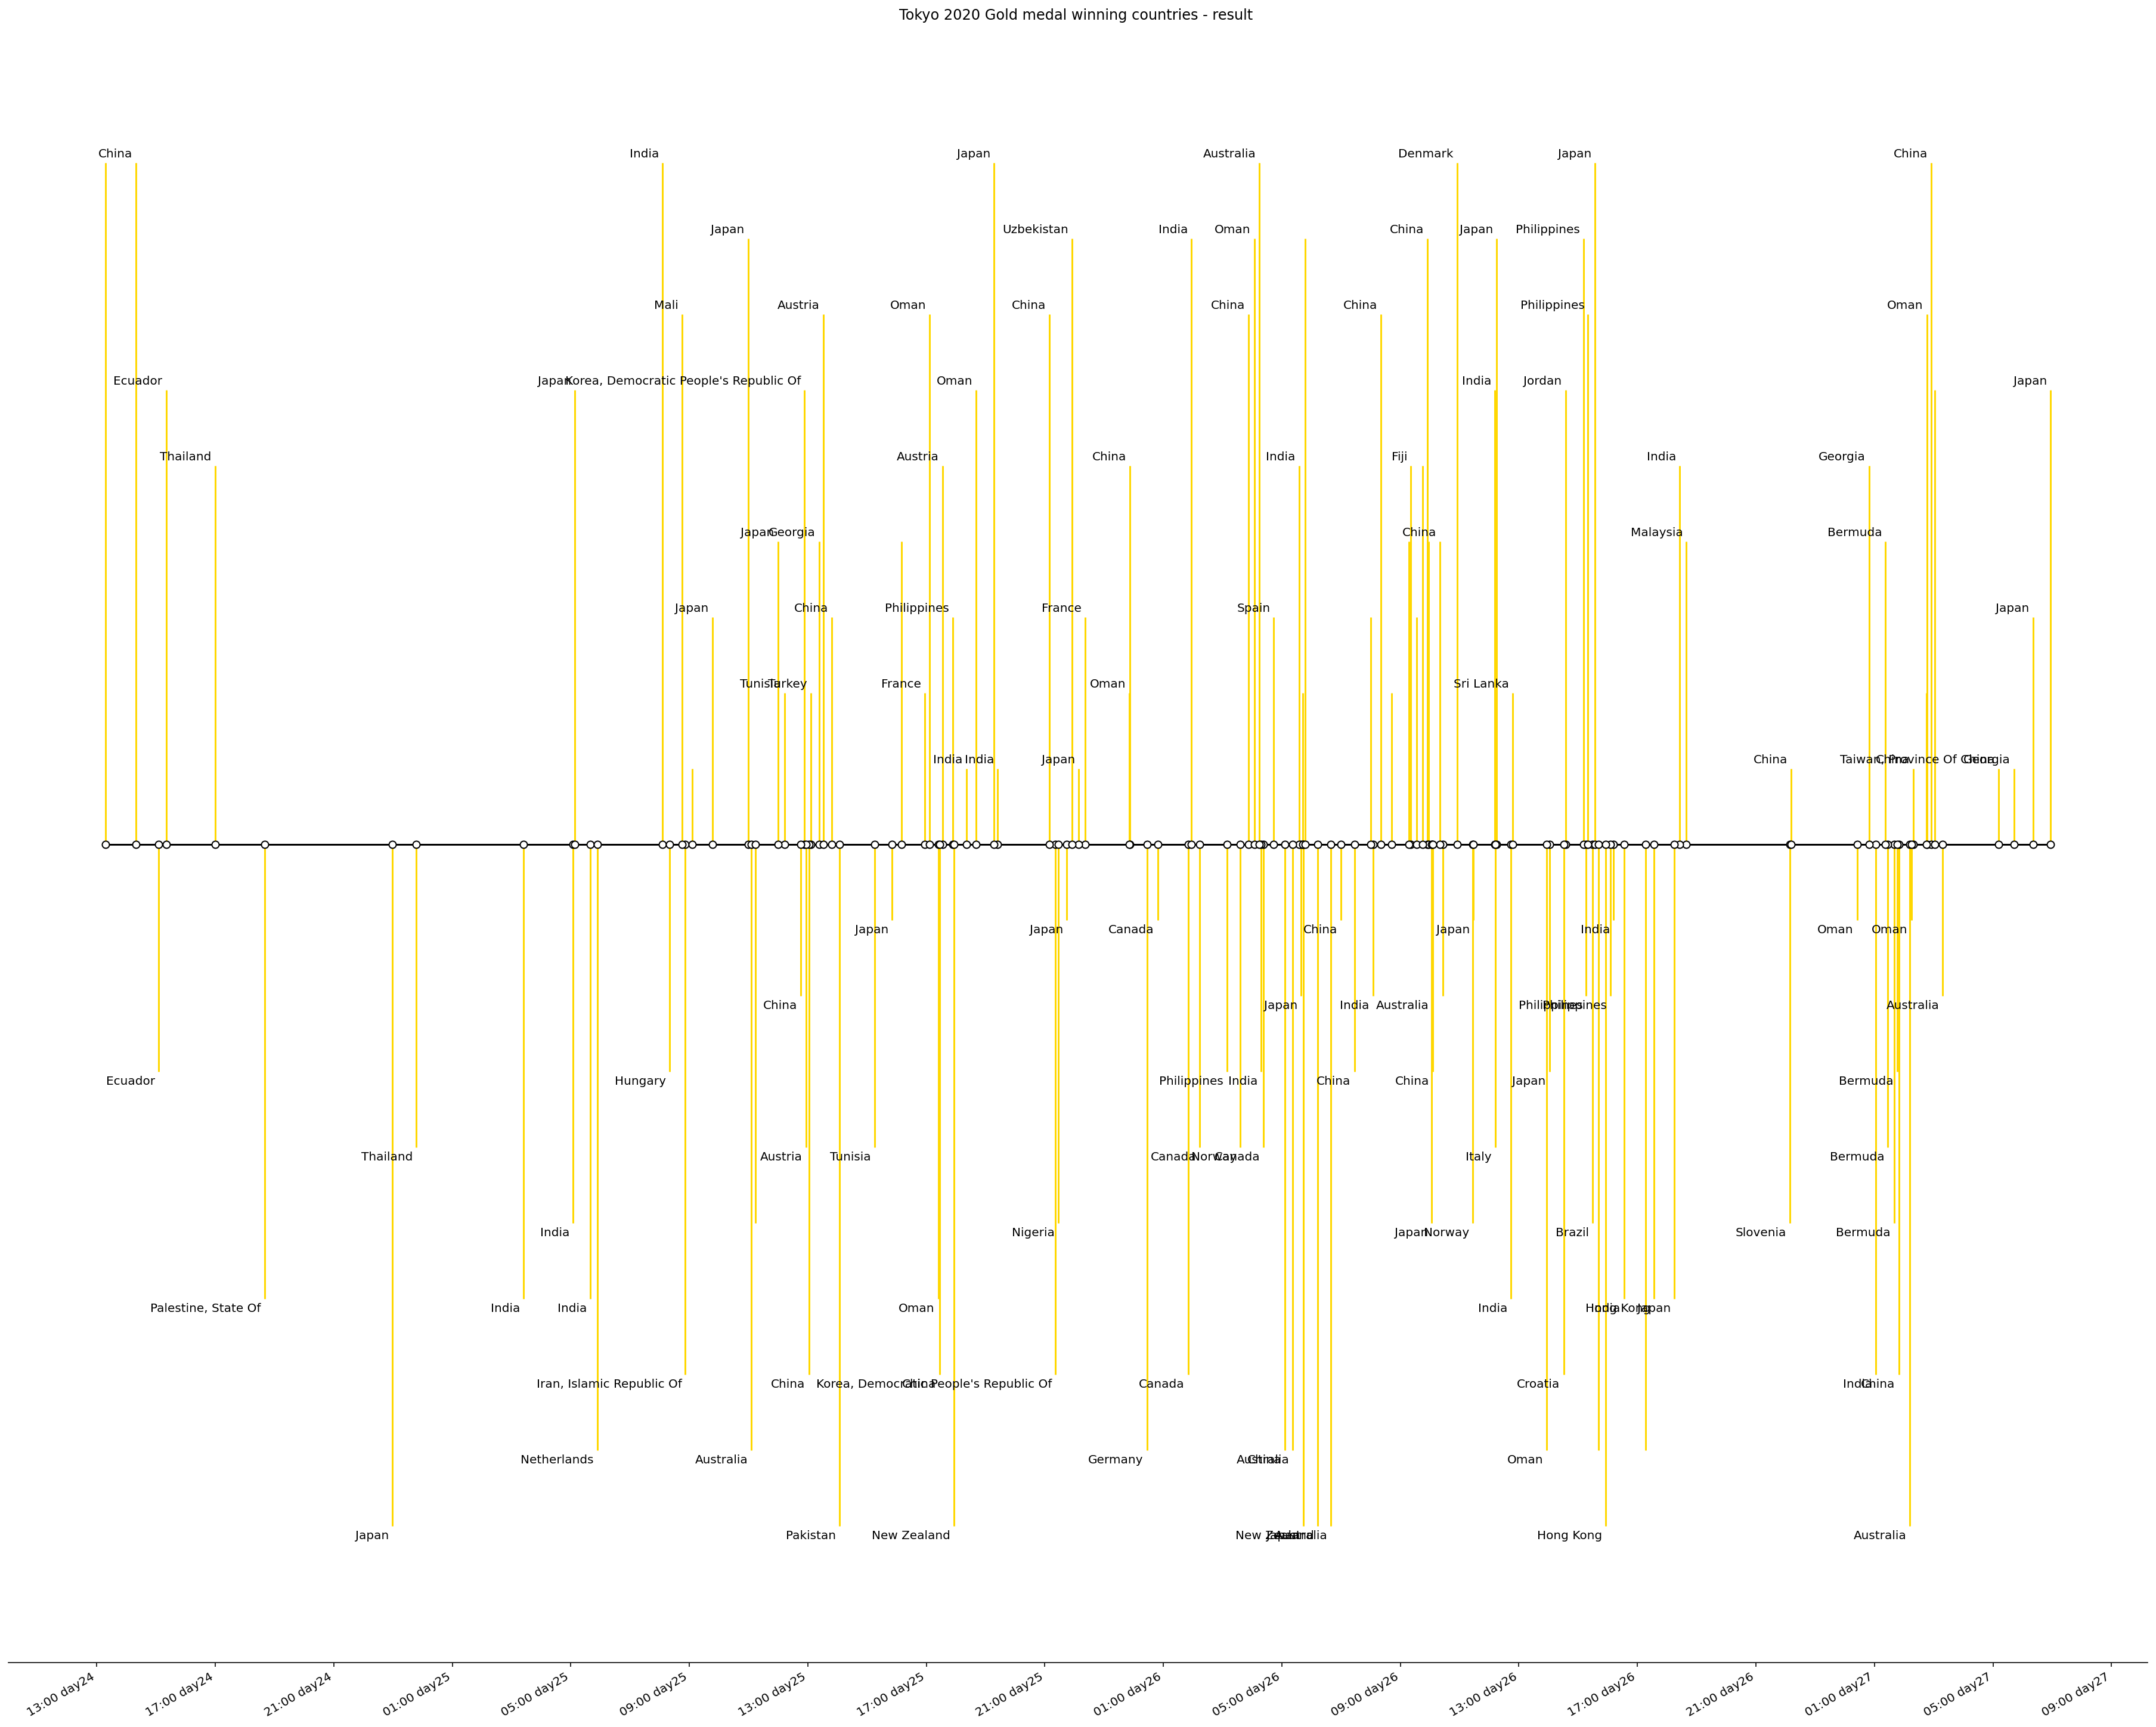

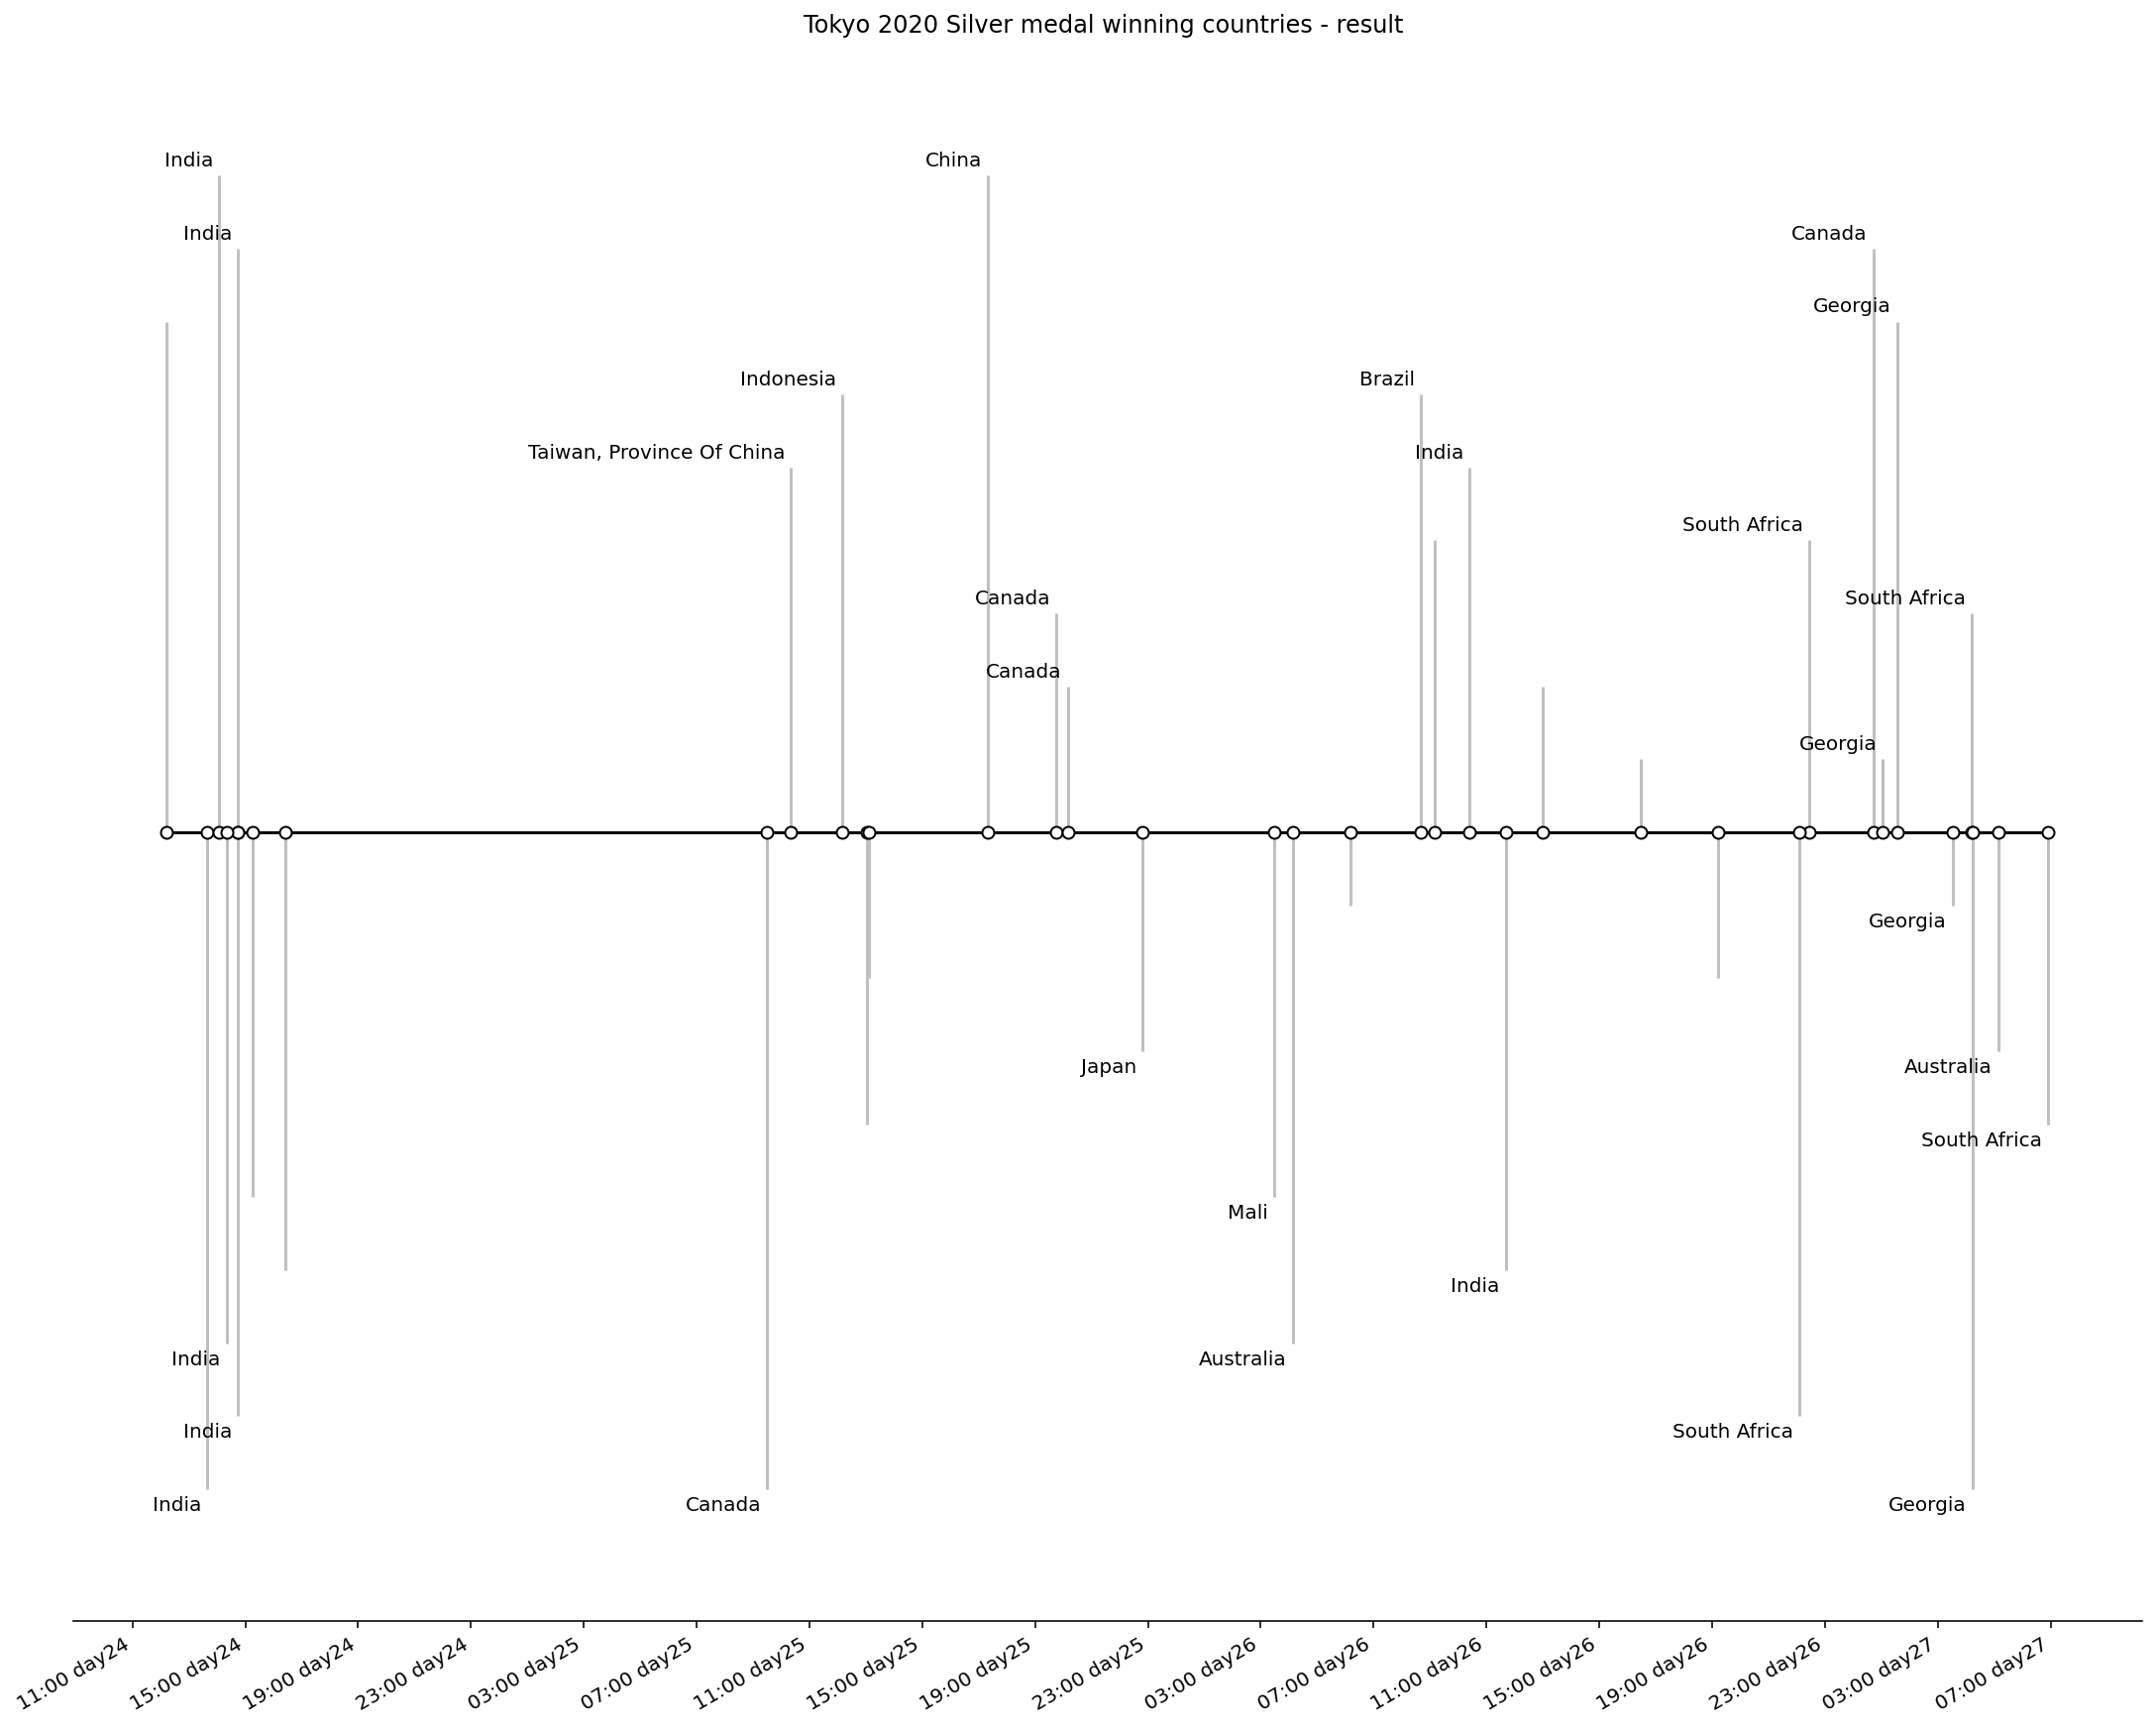

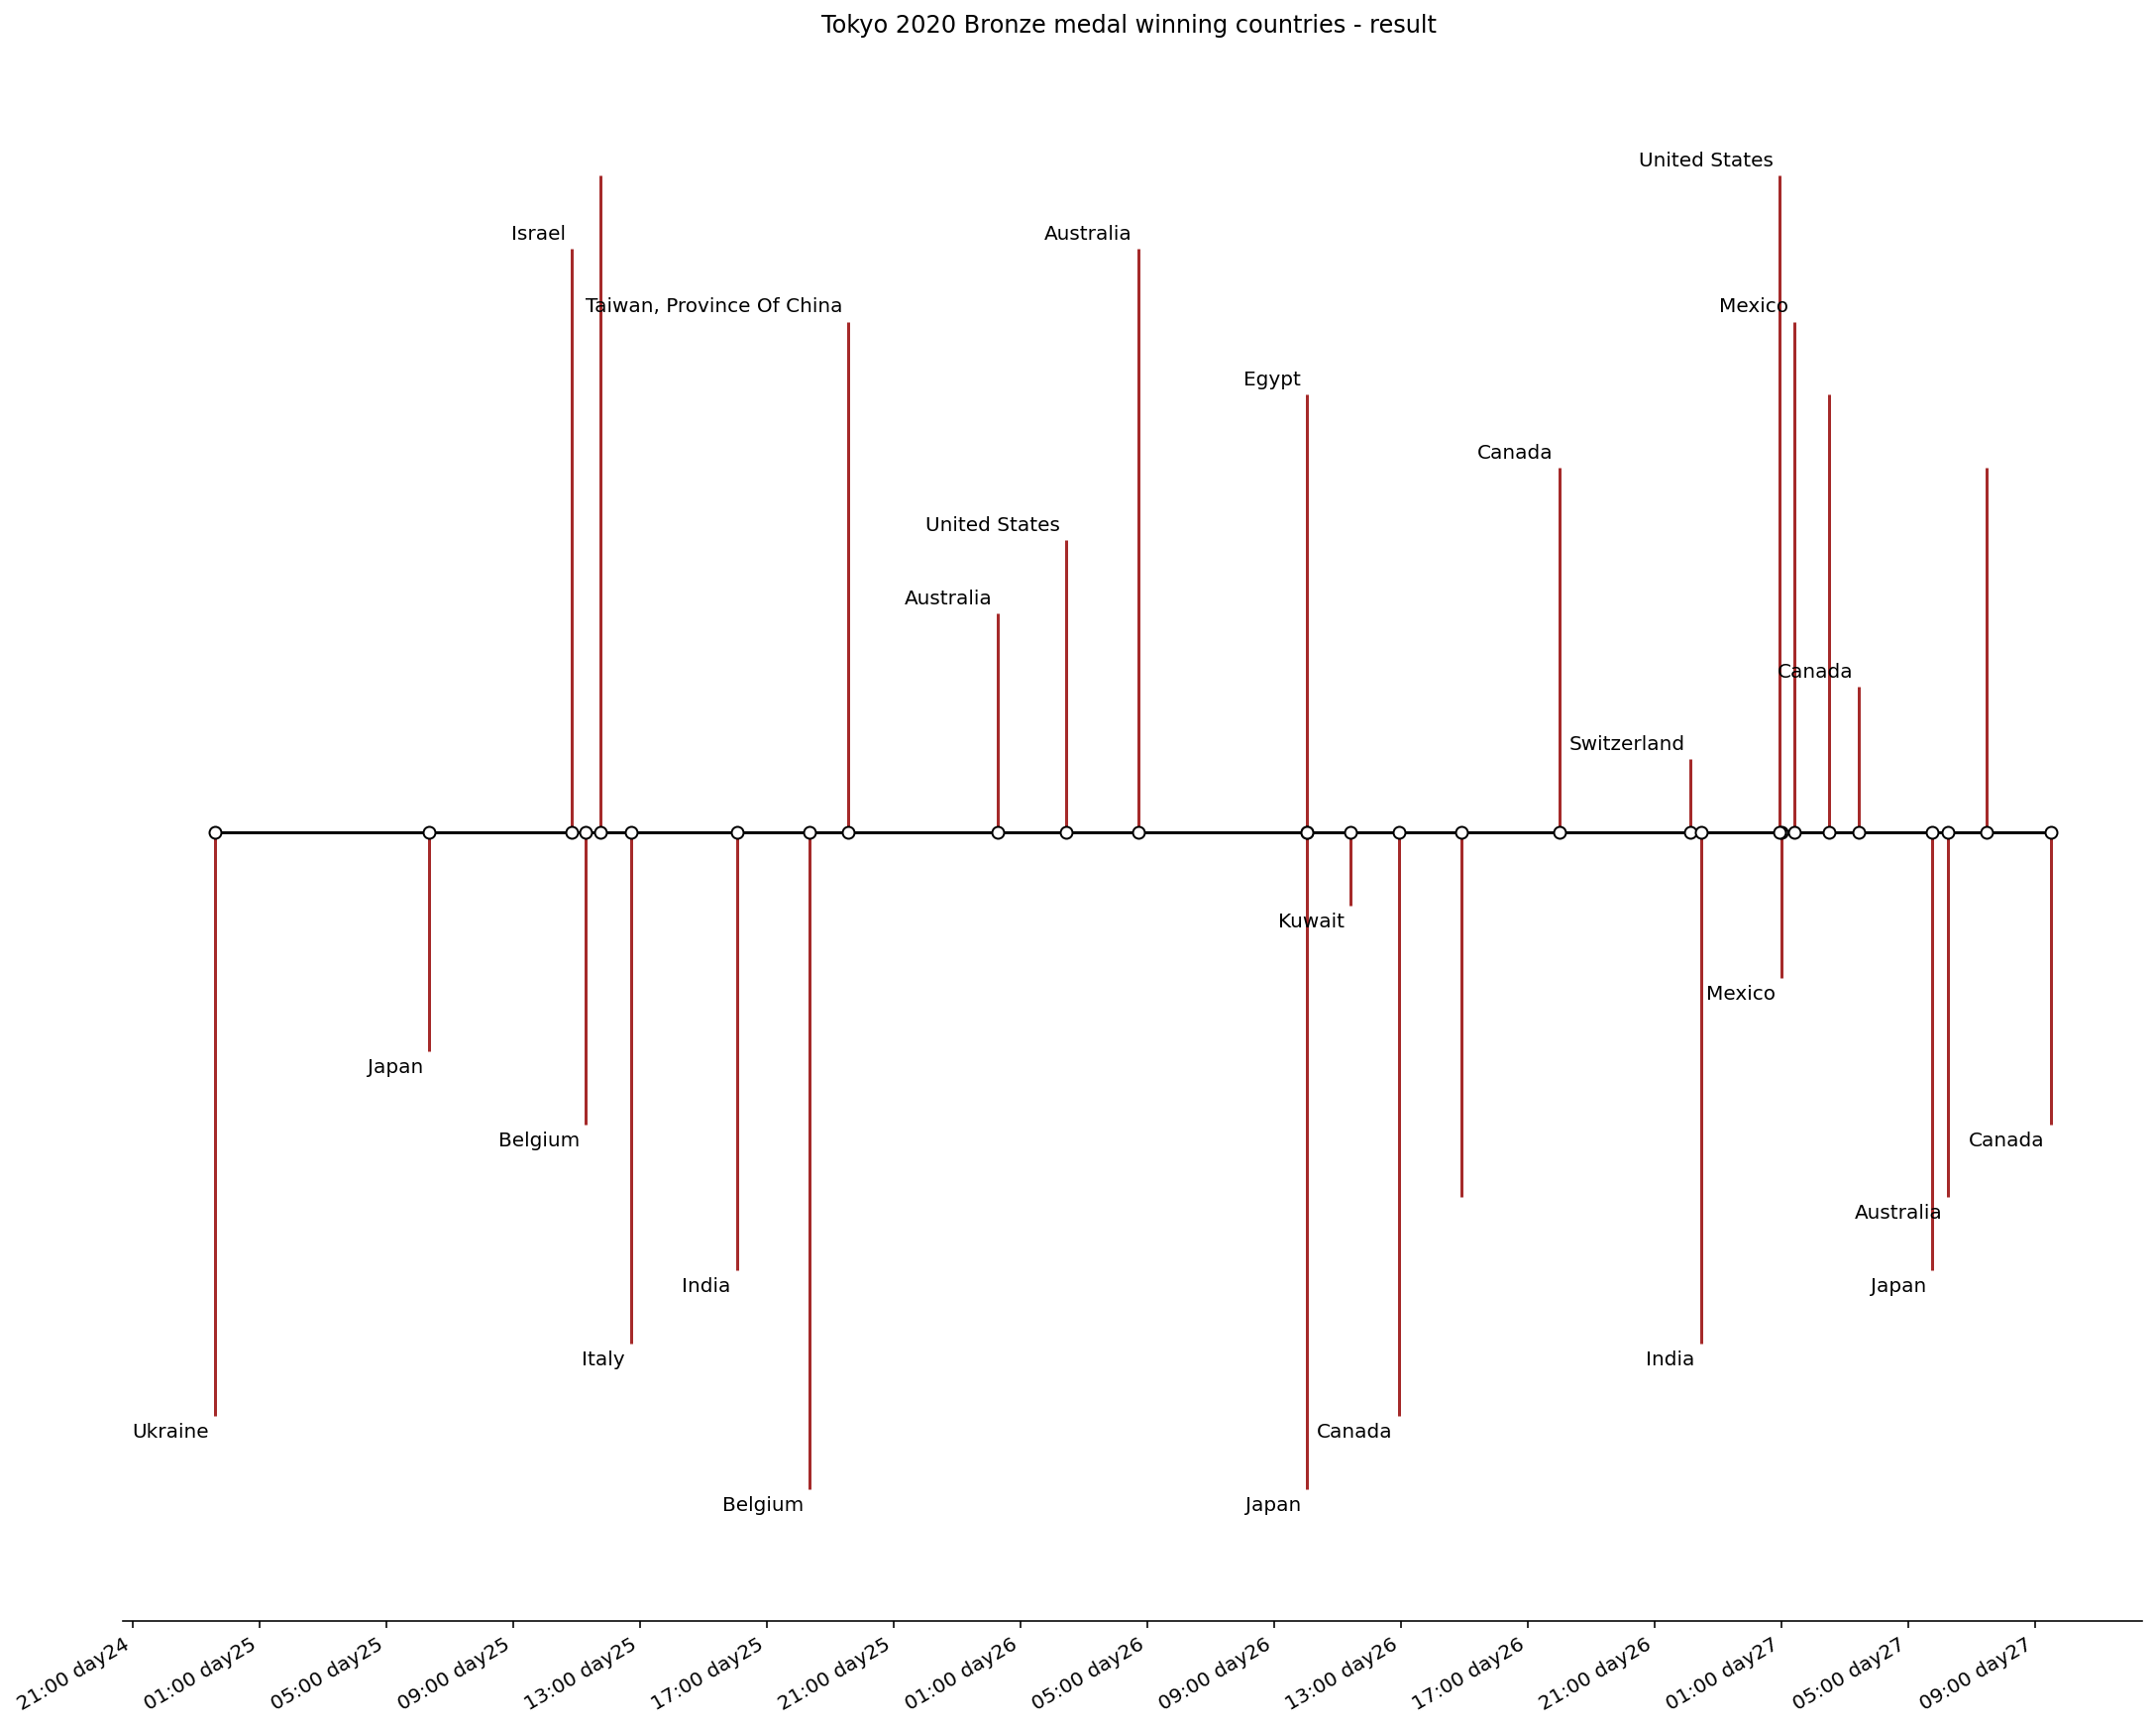

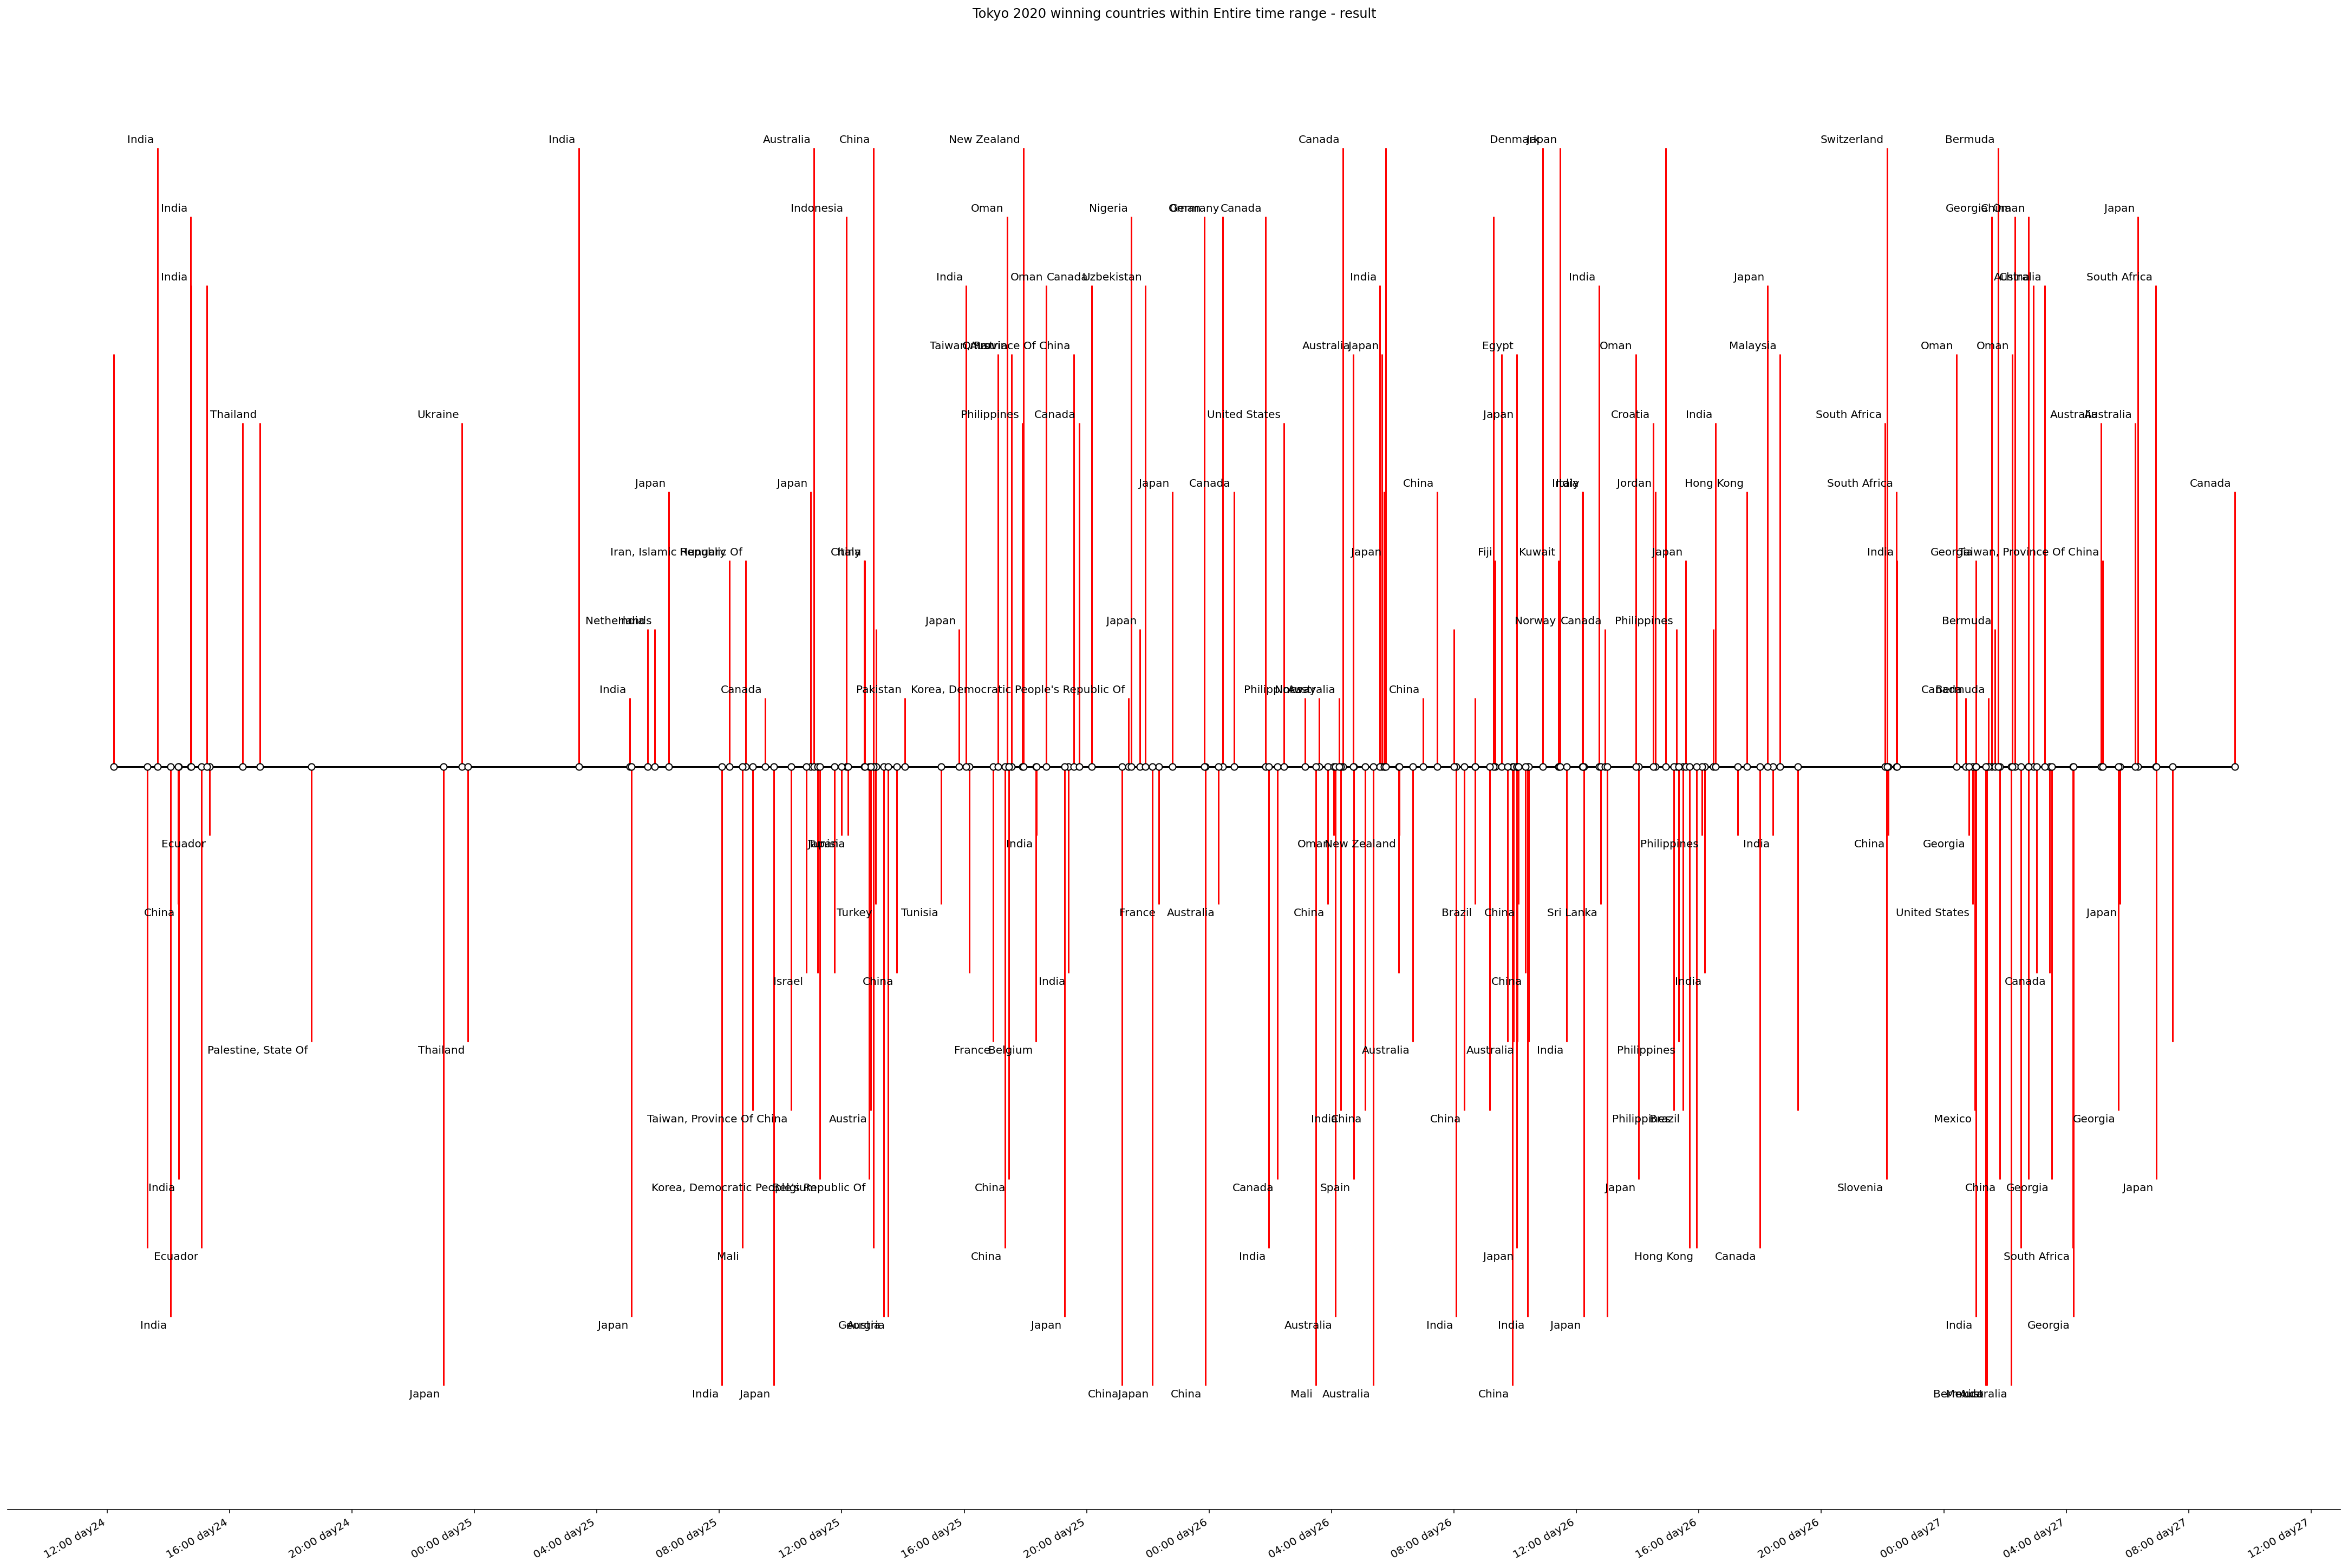

In [9]:
#Result graphs in medals and Entire time range
plotchart(dates_G,Ncon_G,"Tokyo 2020 Gold medal winning countries - result ",color='gold',interval=4,density = 3,reso = (25, 20))
plotchart(dates_S,Ncon_S,"Tokyo 2020 Silver medal winning countries - result ",color='silver',interval=4,density = 3,reso = (15, 12))
plotchart(dates_B,Ncon_B,"Tokyo 2020 Bronze medal winning countries - result ",color='brown',interval=4,density = 3,reso = (15, 12))
plotchart(dates_T,Ncon_T,"Tokyo 2020 winning countries within Entire time range - result",color = 'red',interval=4,density = 3,reso = (30,20))
#len(Ncon_G)
#len(Ncon_S)
#len(Ncon_B)

17
65
91
37


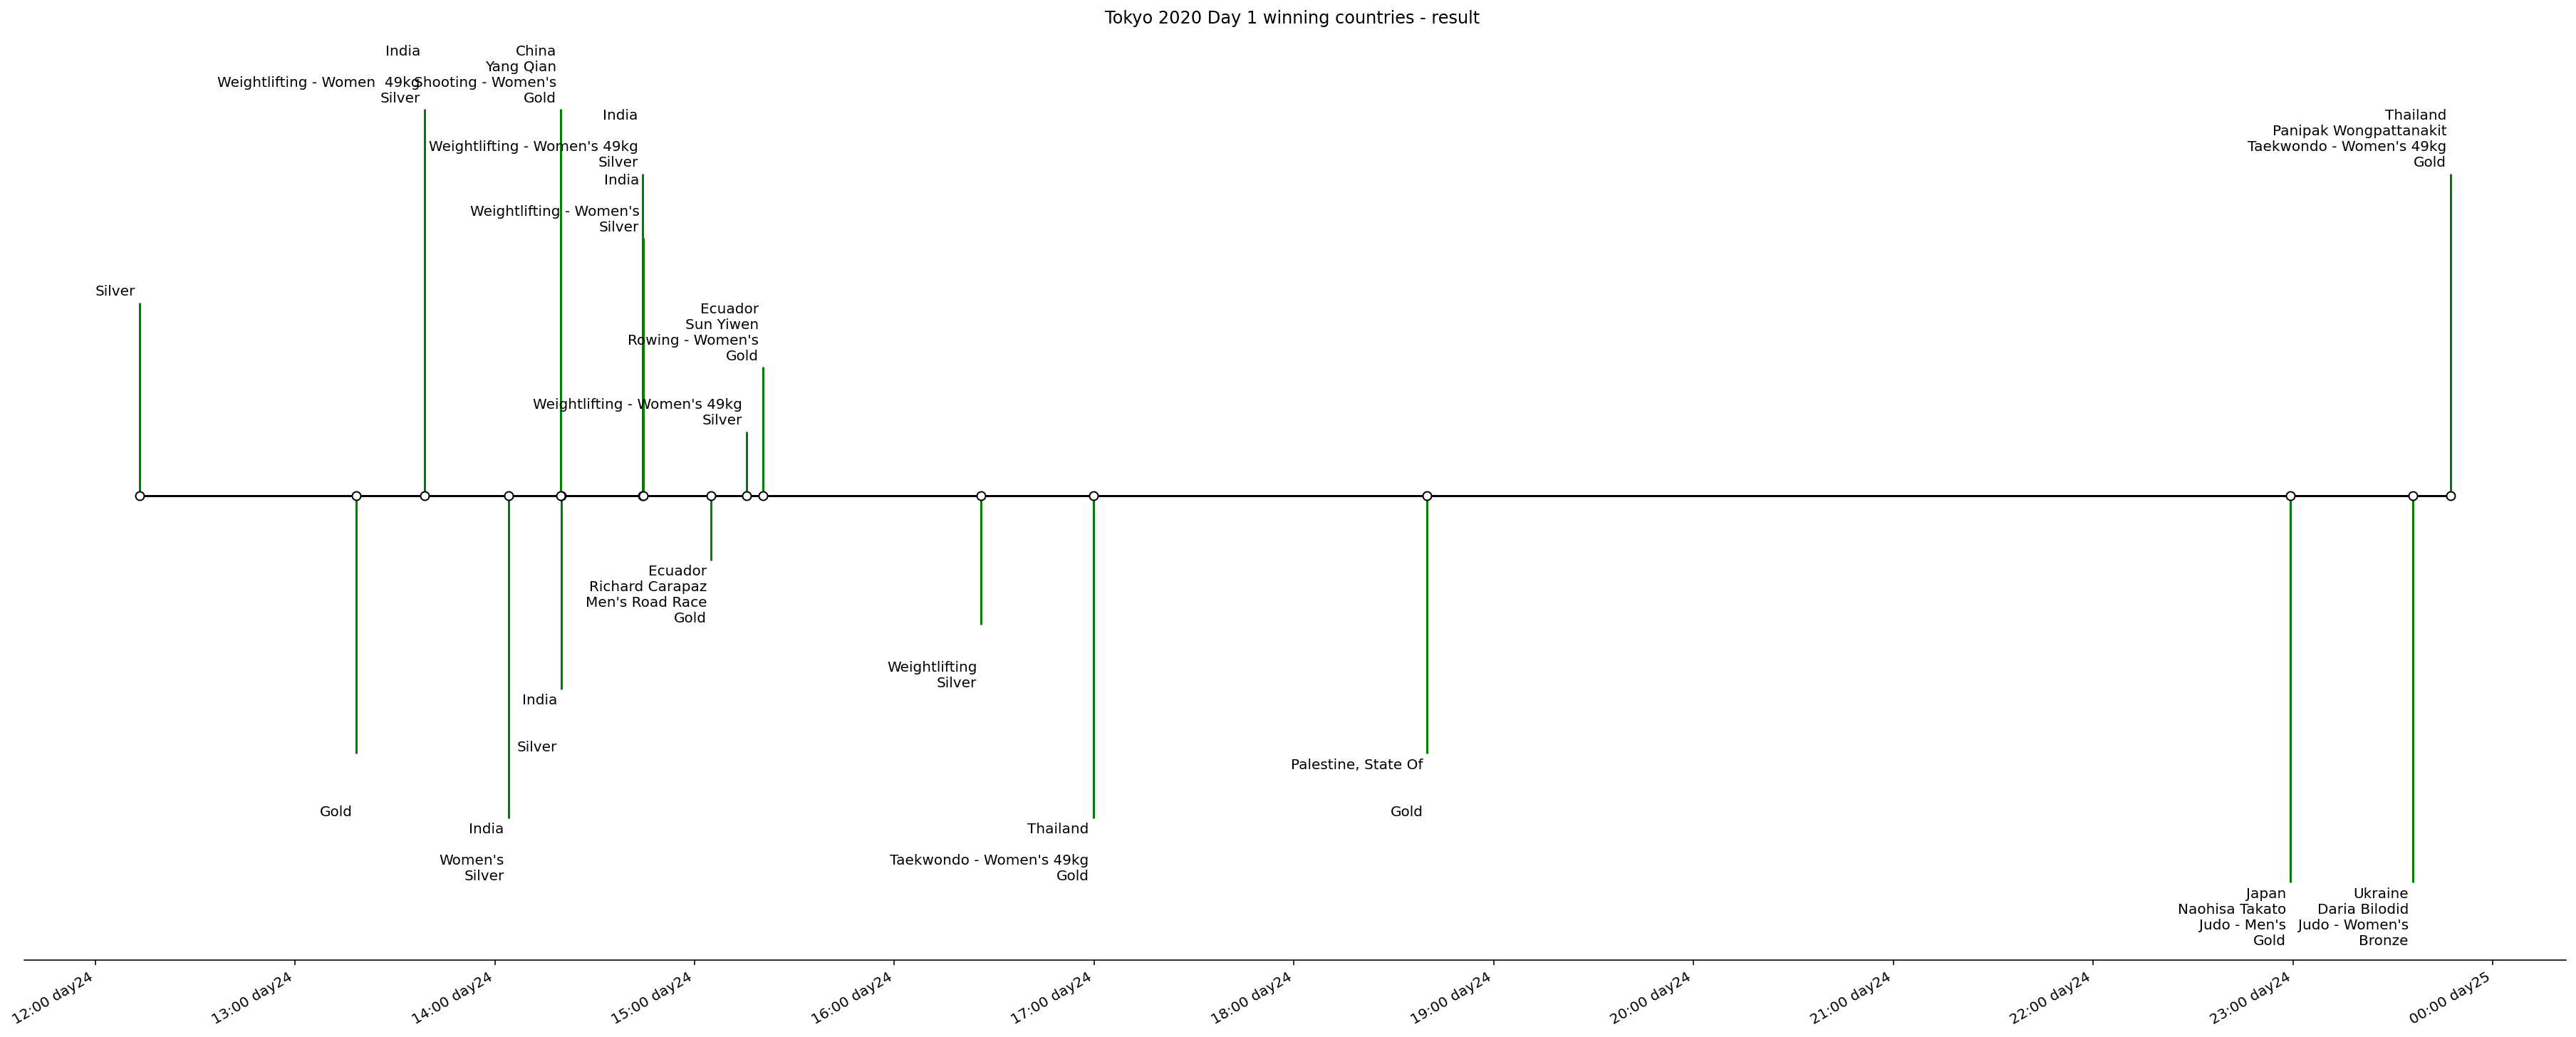

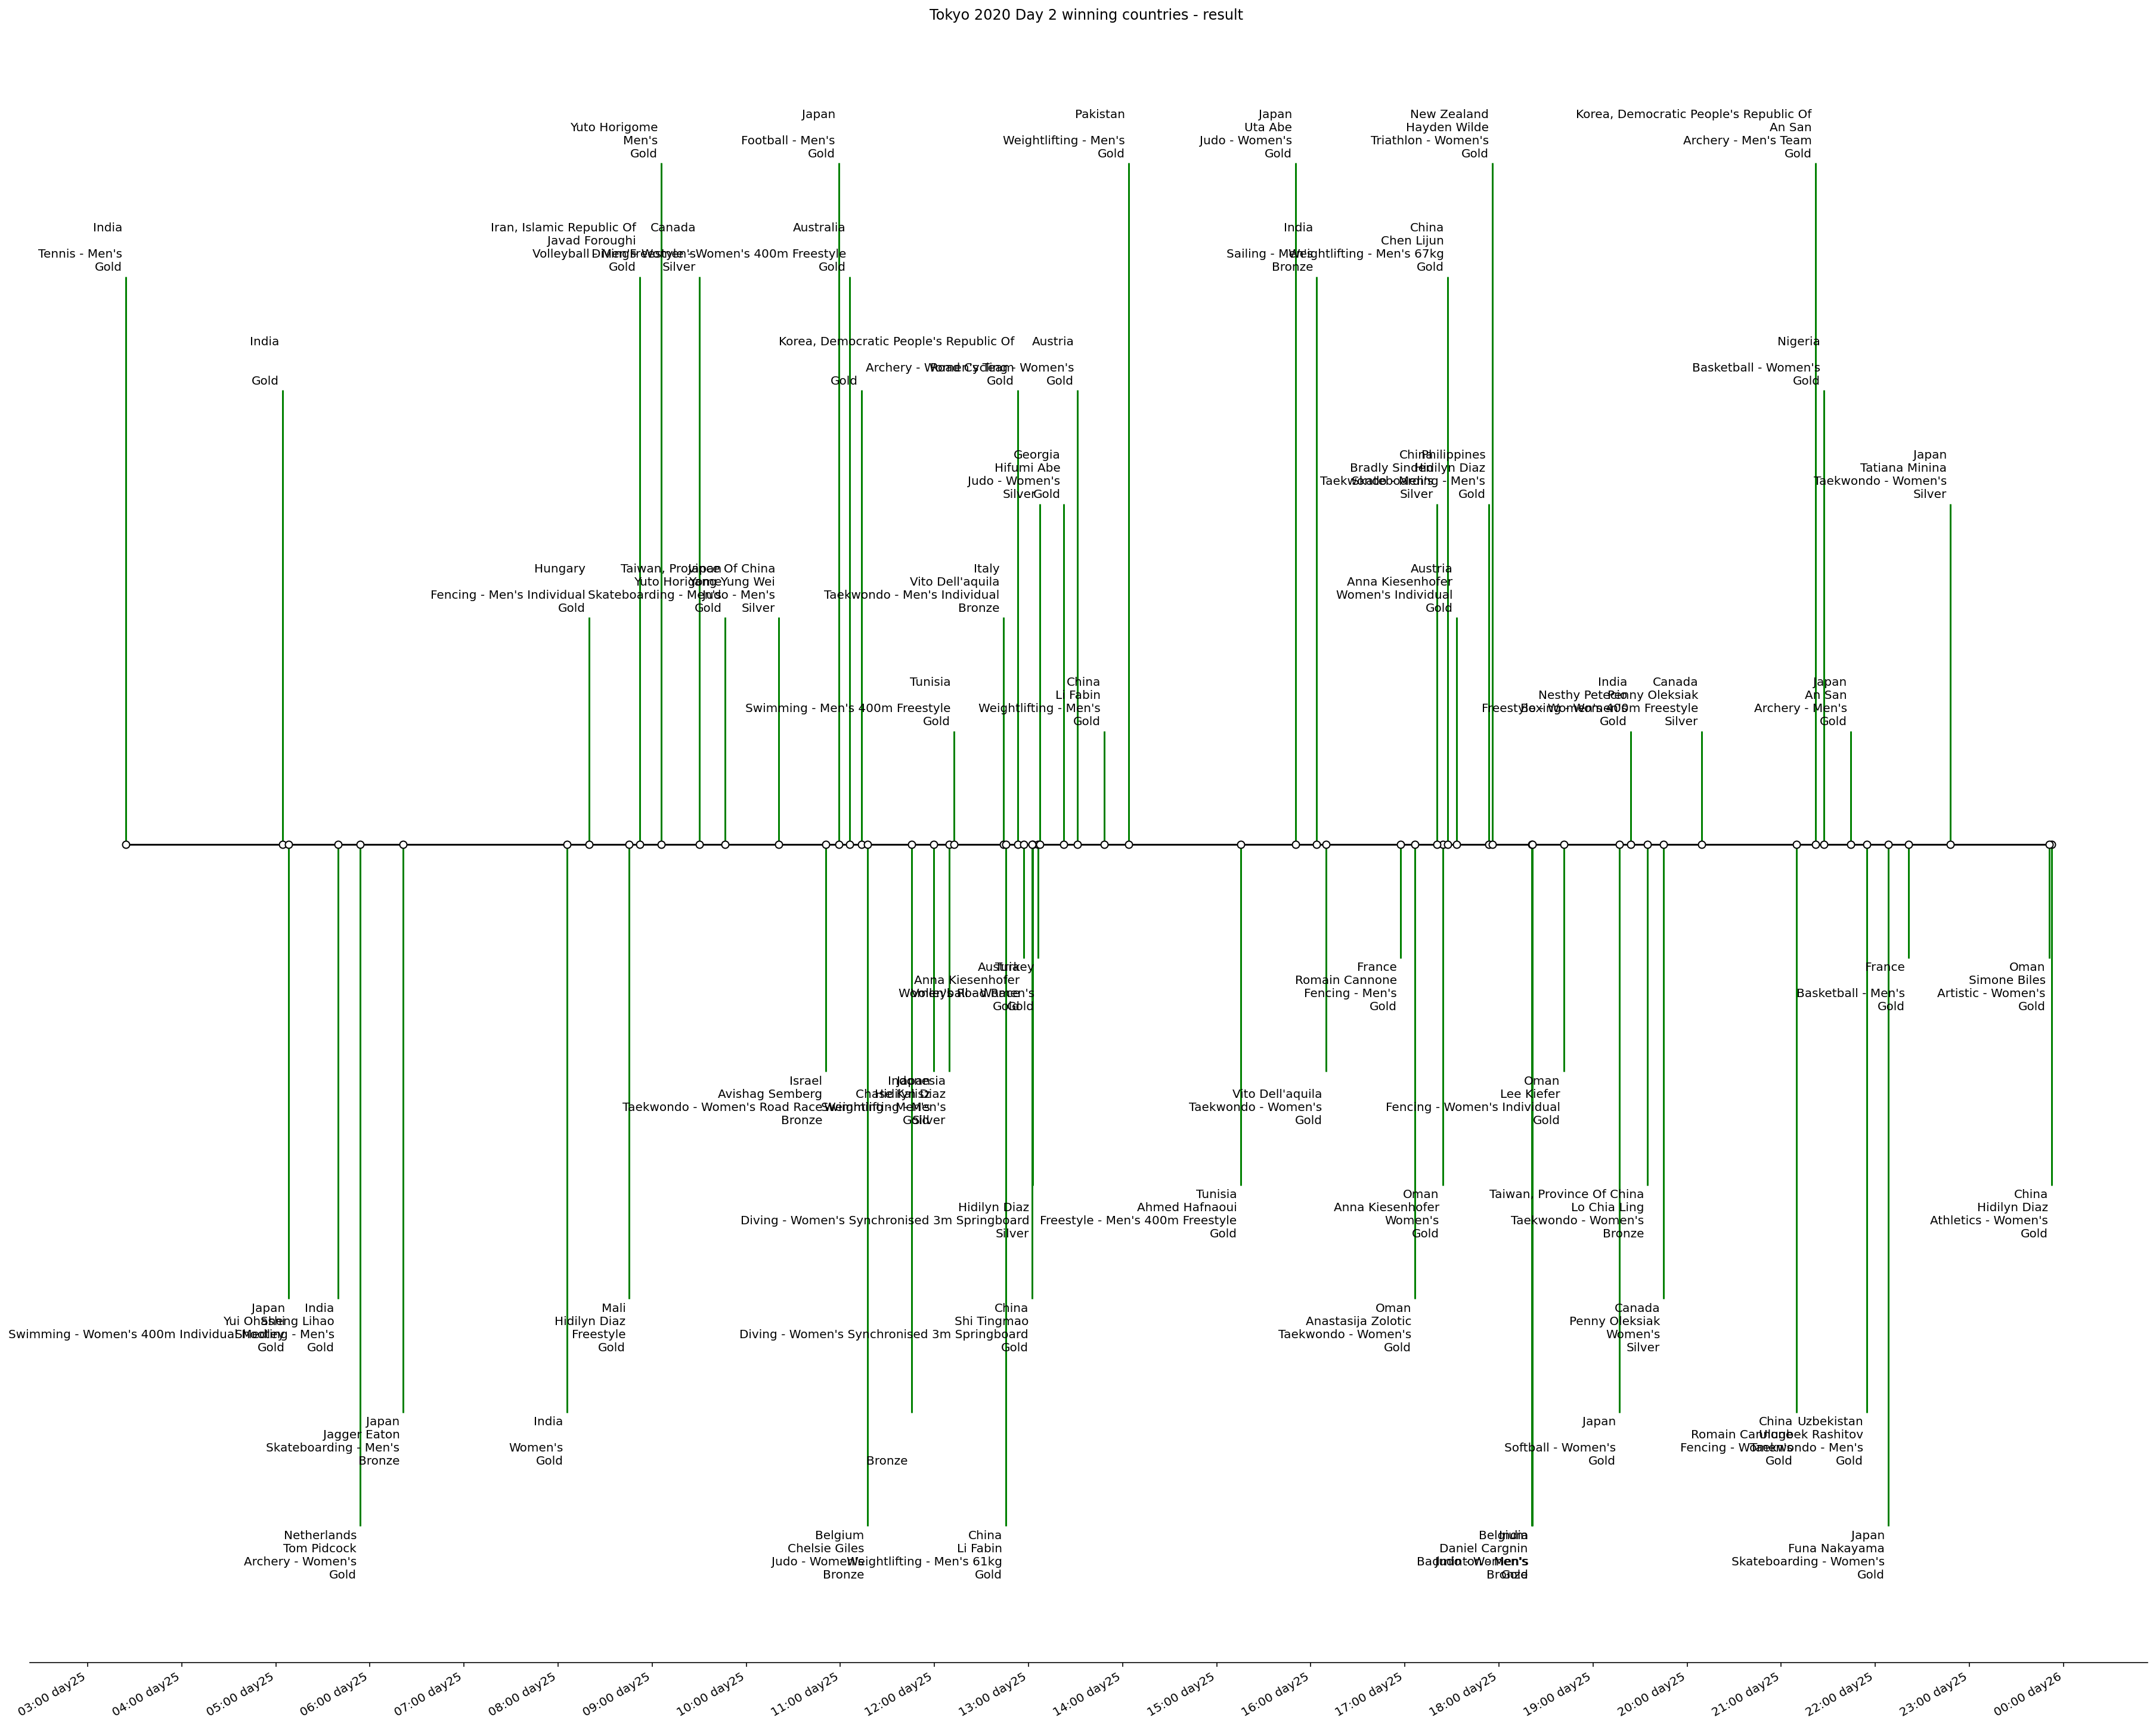

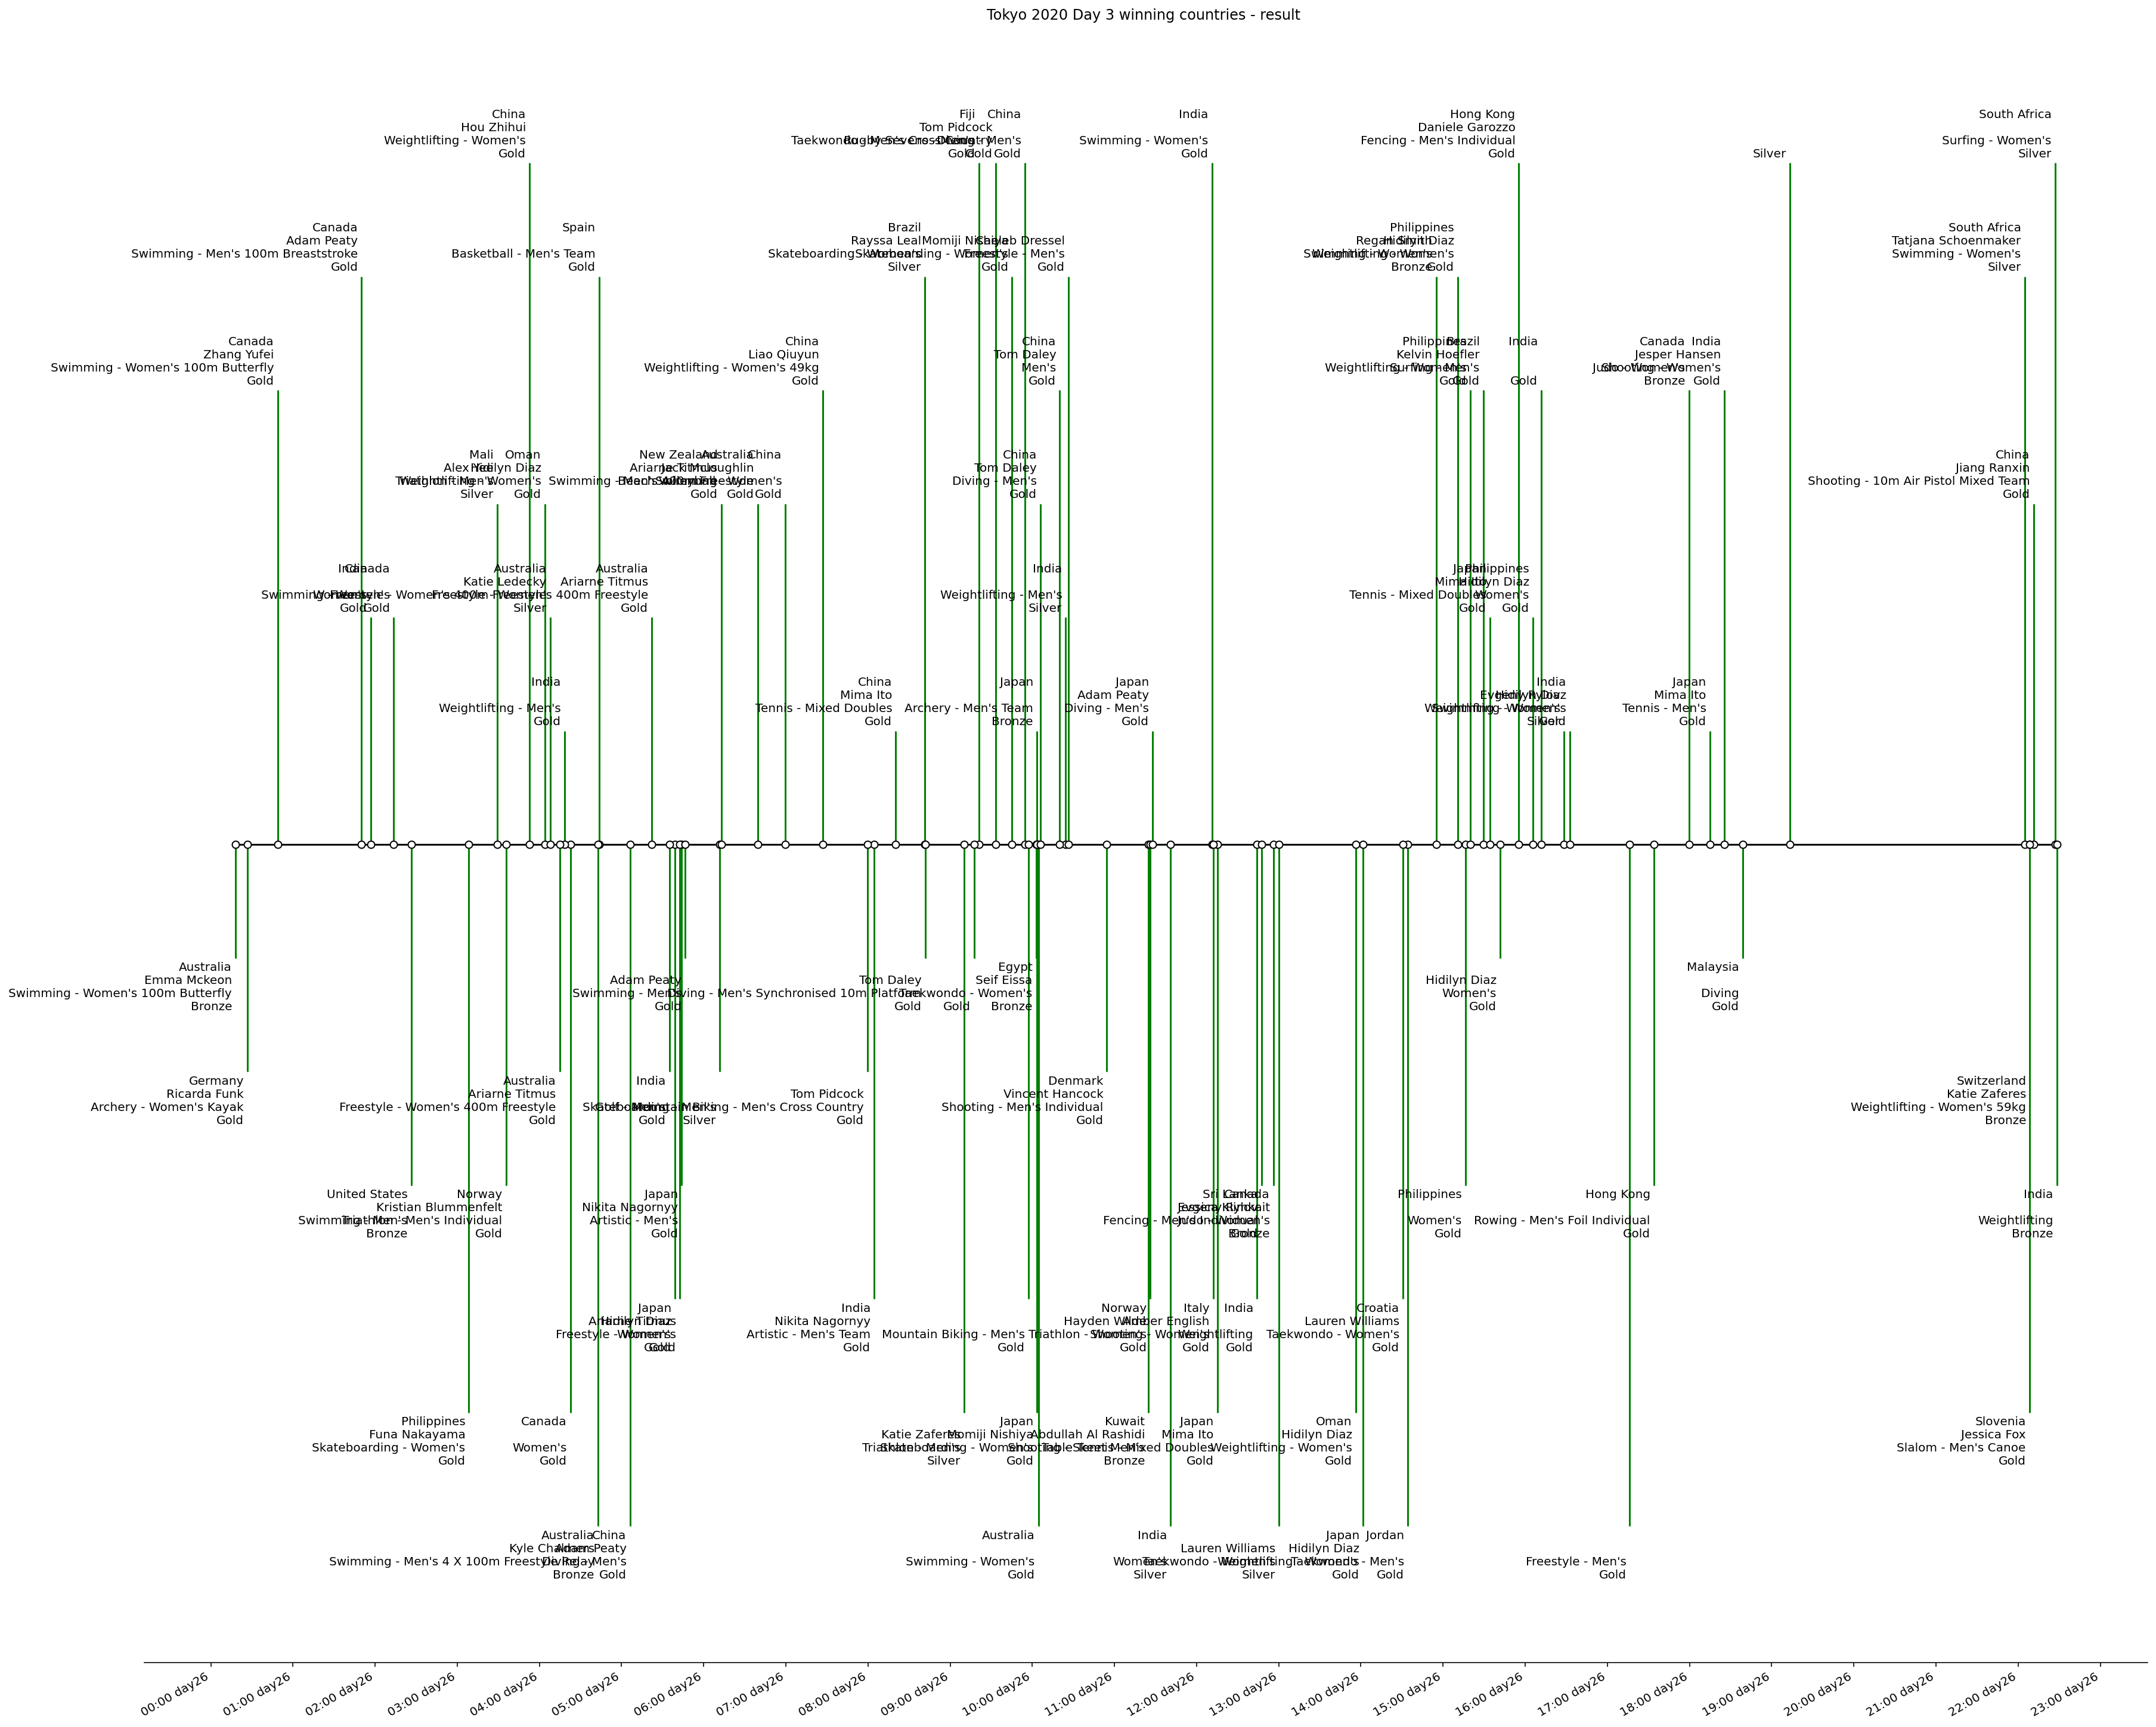

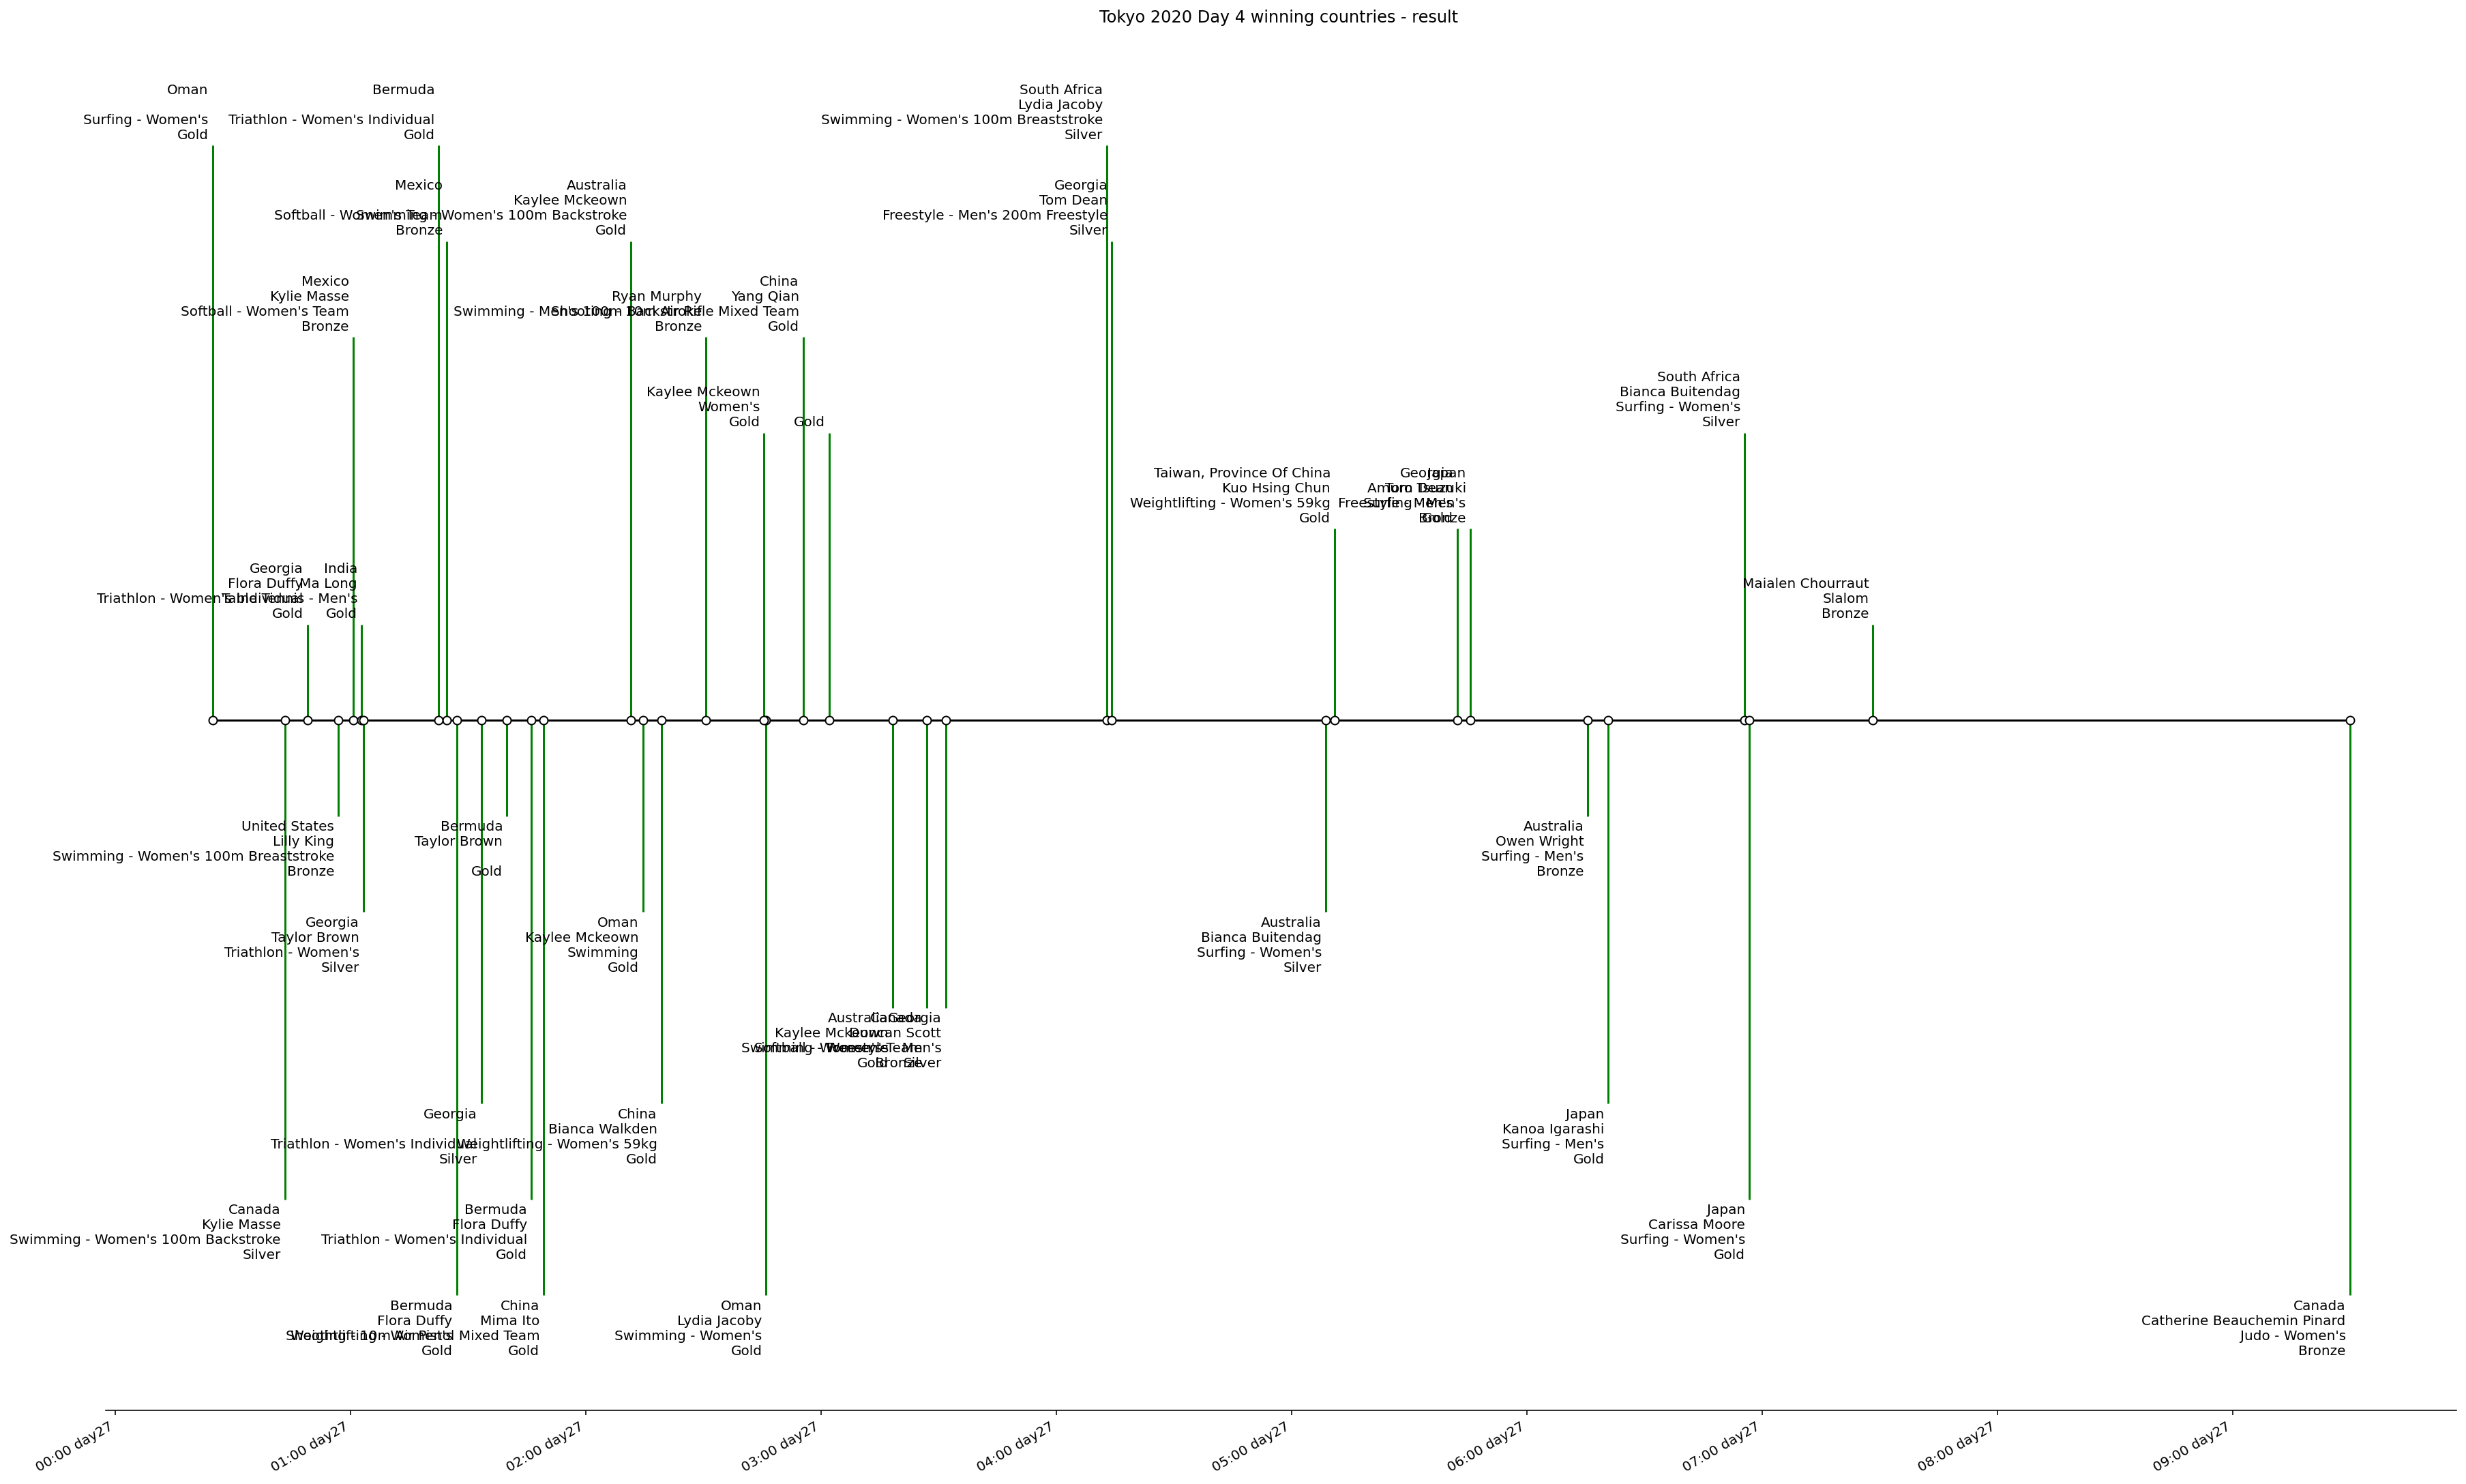

In [13]:
#Verification graphs in days
plotchart(dates_D1,ND1,"Tokyo 2020 Day 1 winning countries - result ",color = 'g',interval=1,density = 2,reso = (25,10))
plotchart(dates_D2,ND2,"Tokyo 2020 Day 2 winning countries - result ",color = 'g',interval=1,density = 2,reso = (25,20))
plotchart(dates_D3,ND3,"Tokyo 2020 Day 3 winning countries - result ",color = 'g',interval=1,density = 2,reso = (25,20))
plotchart(dates_D4,ND4,"Tokyo 2020 Day 4 winning countries - result ",color = 'g',interval=1,density = 2,reso = (25,15))
print(len(Ncon_D1))
print(len(Ncon_D2))
print(len(Ncon_D3))
print(len(Ncon_D4))

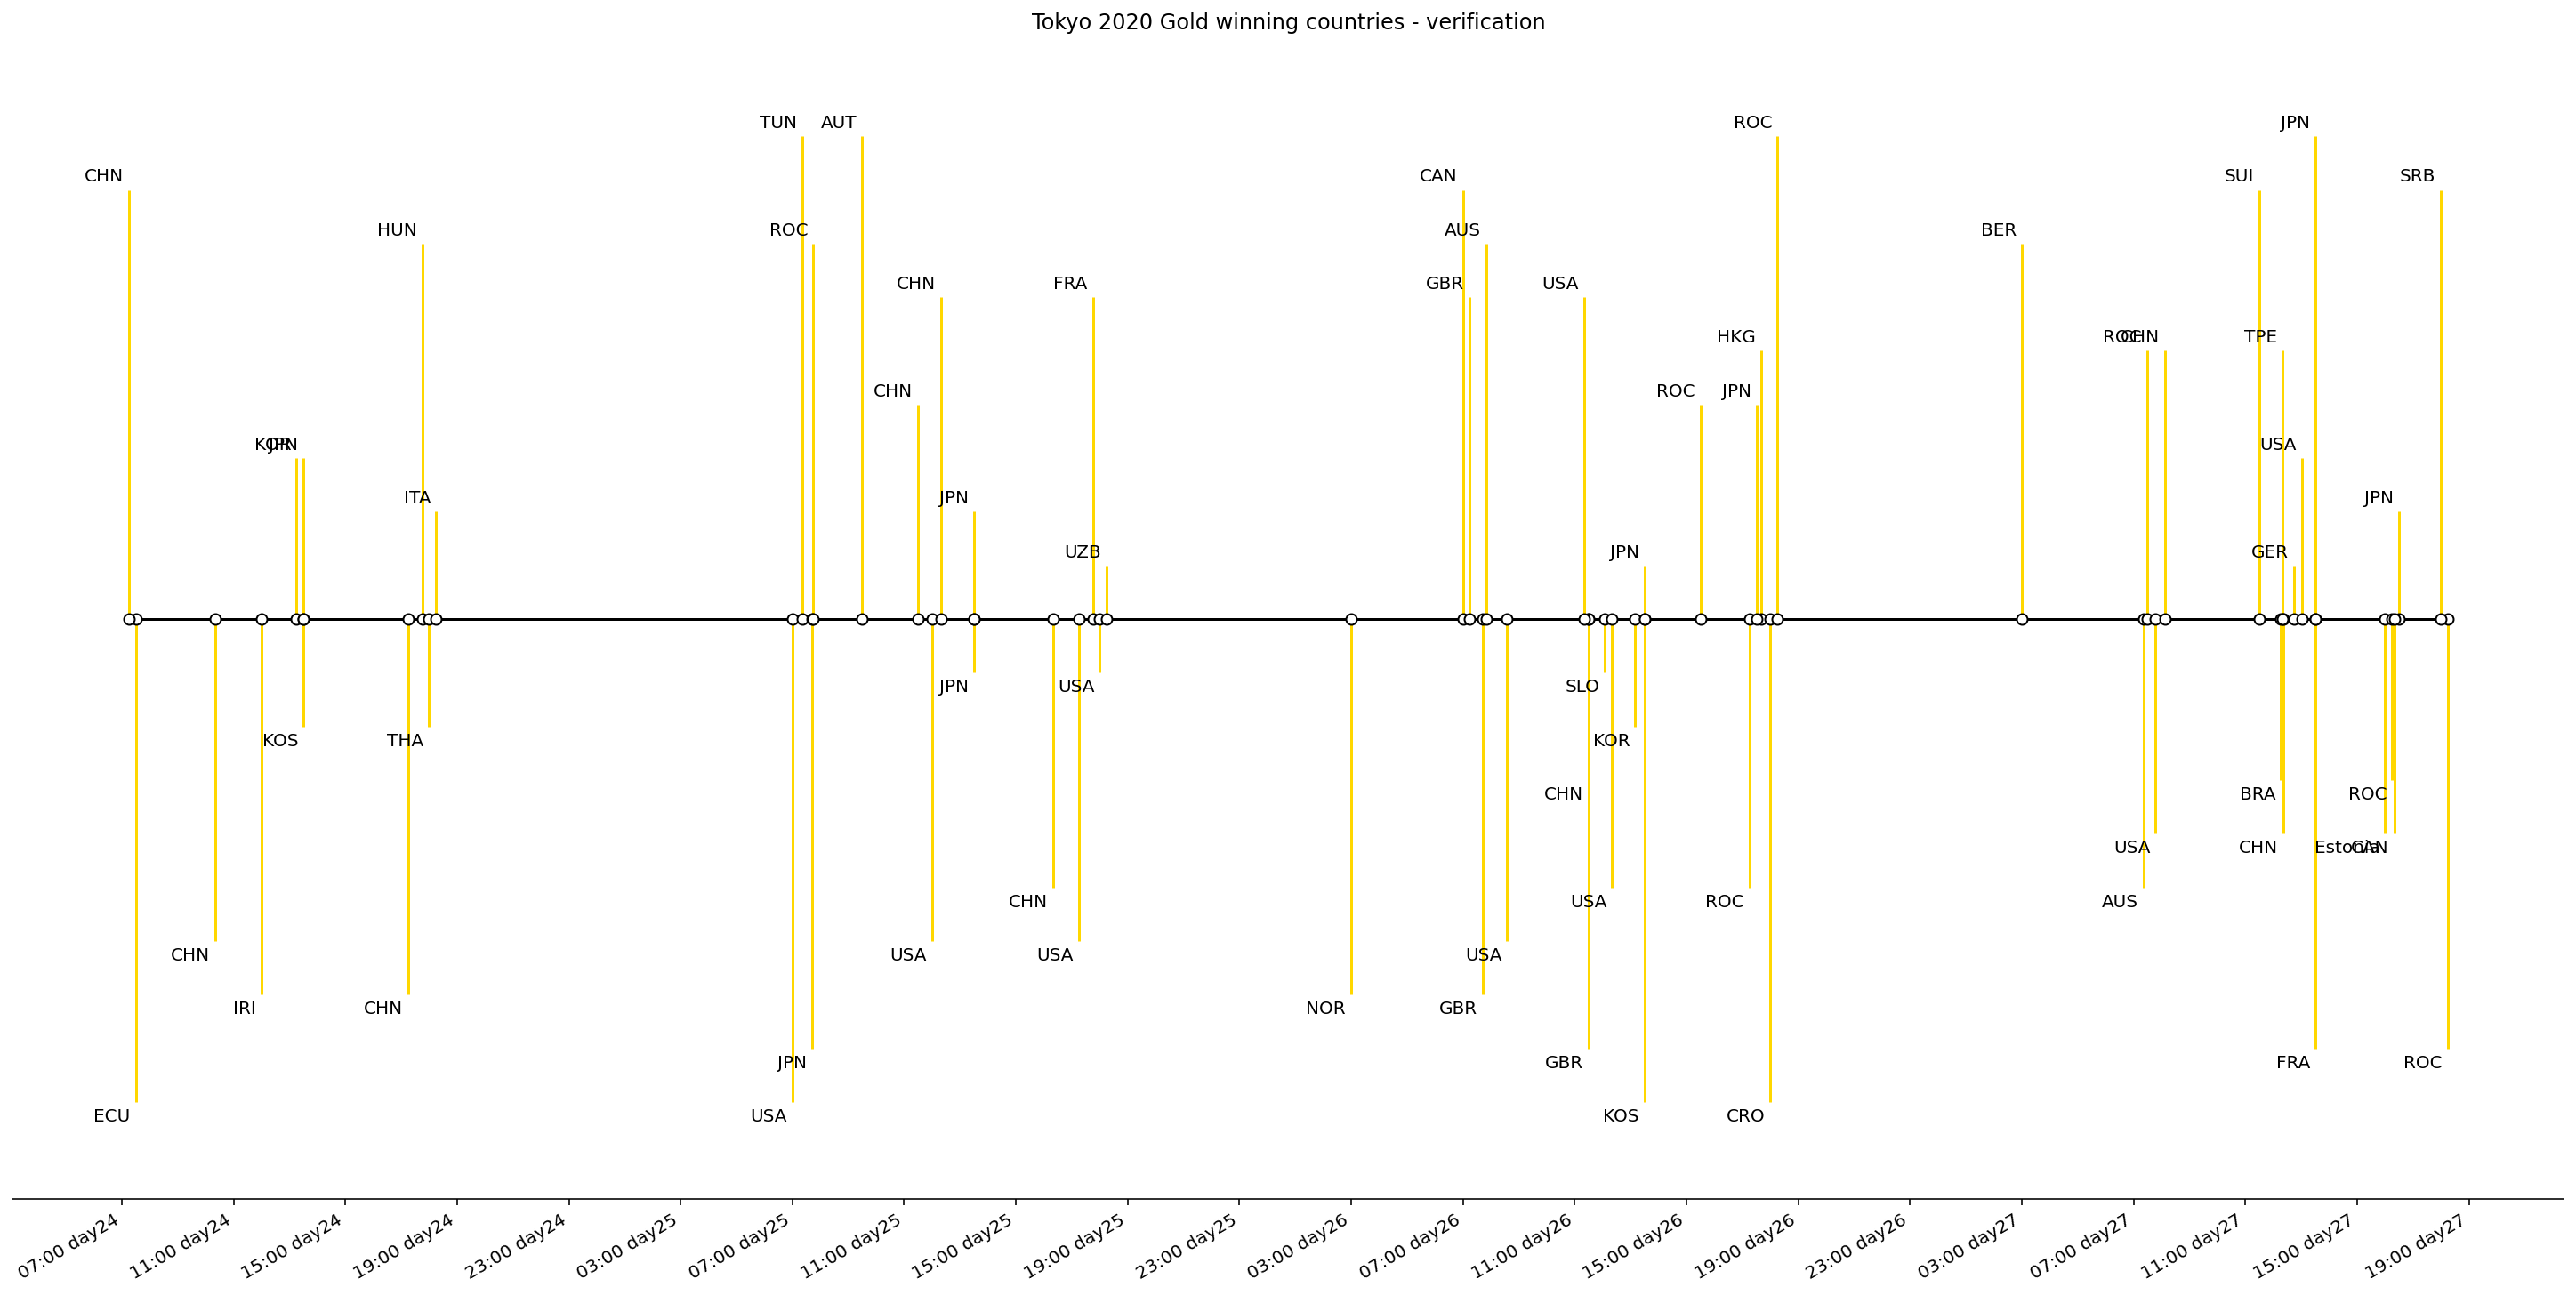

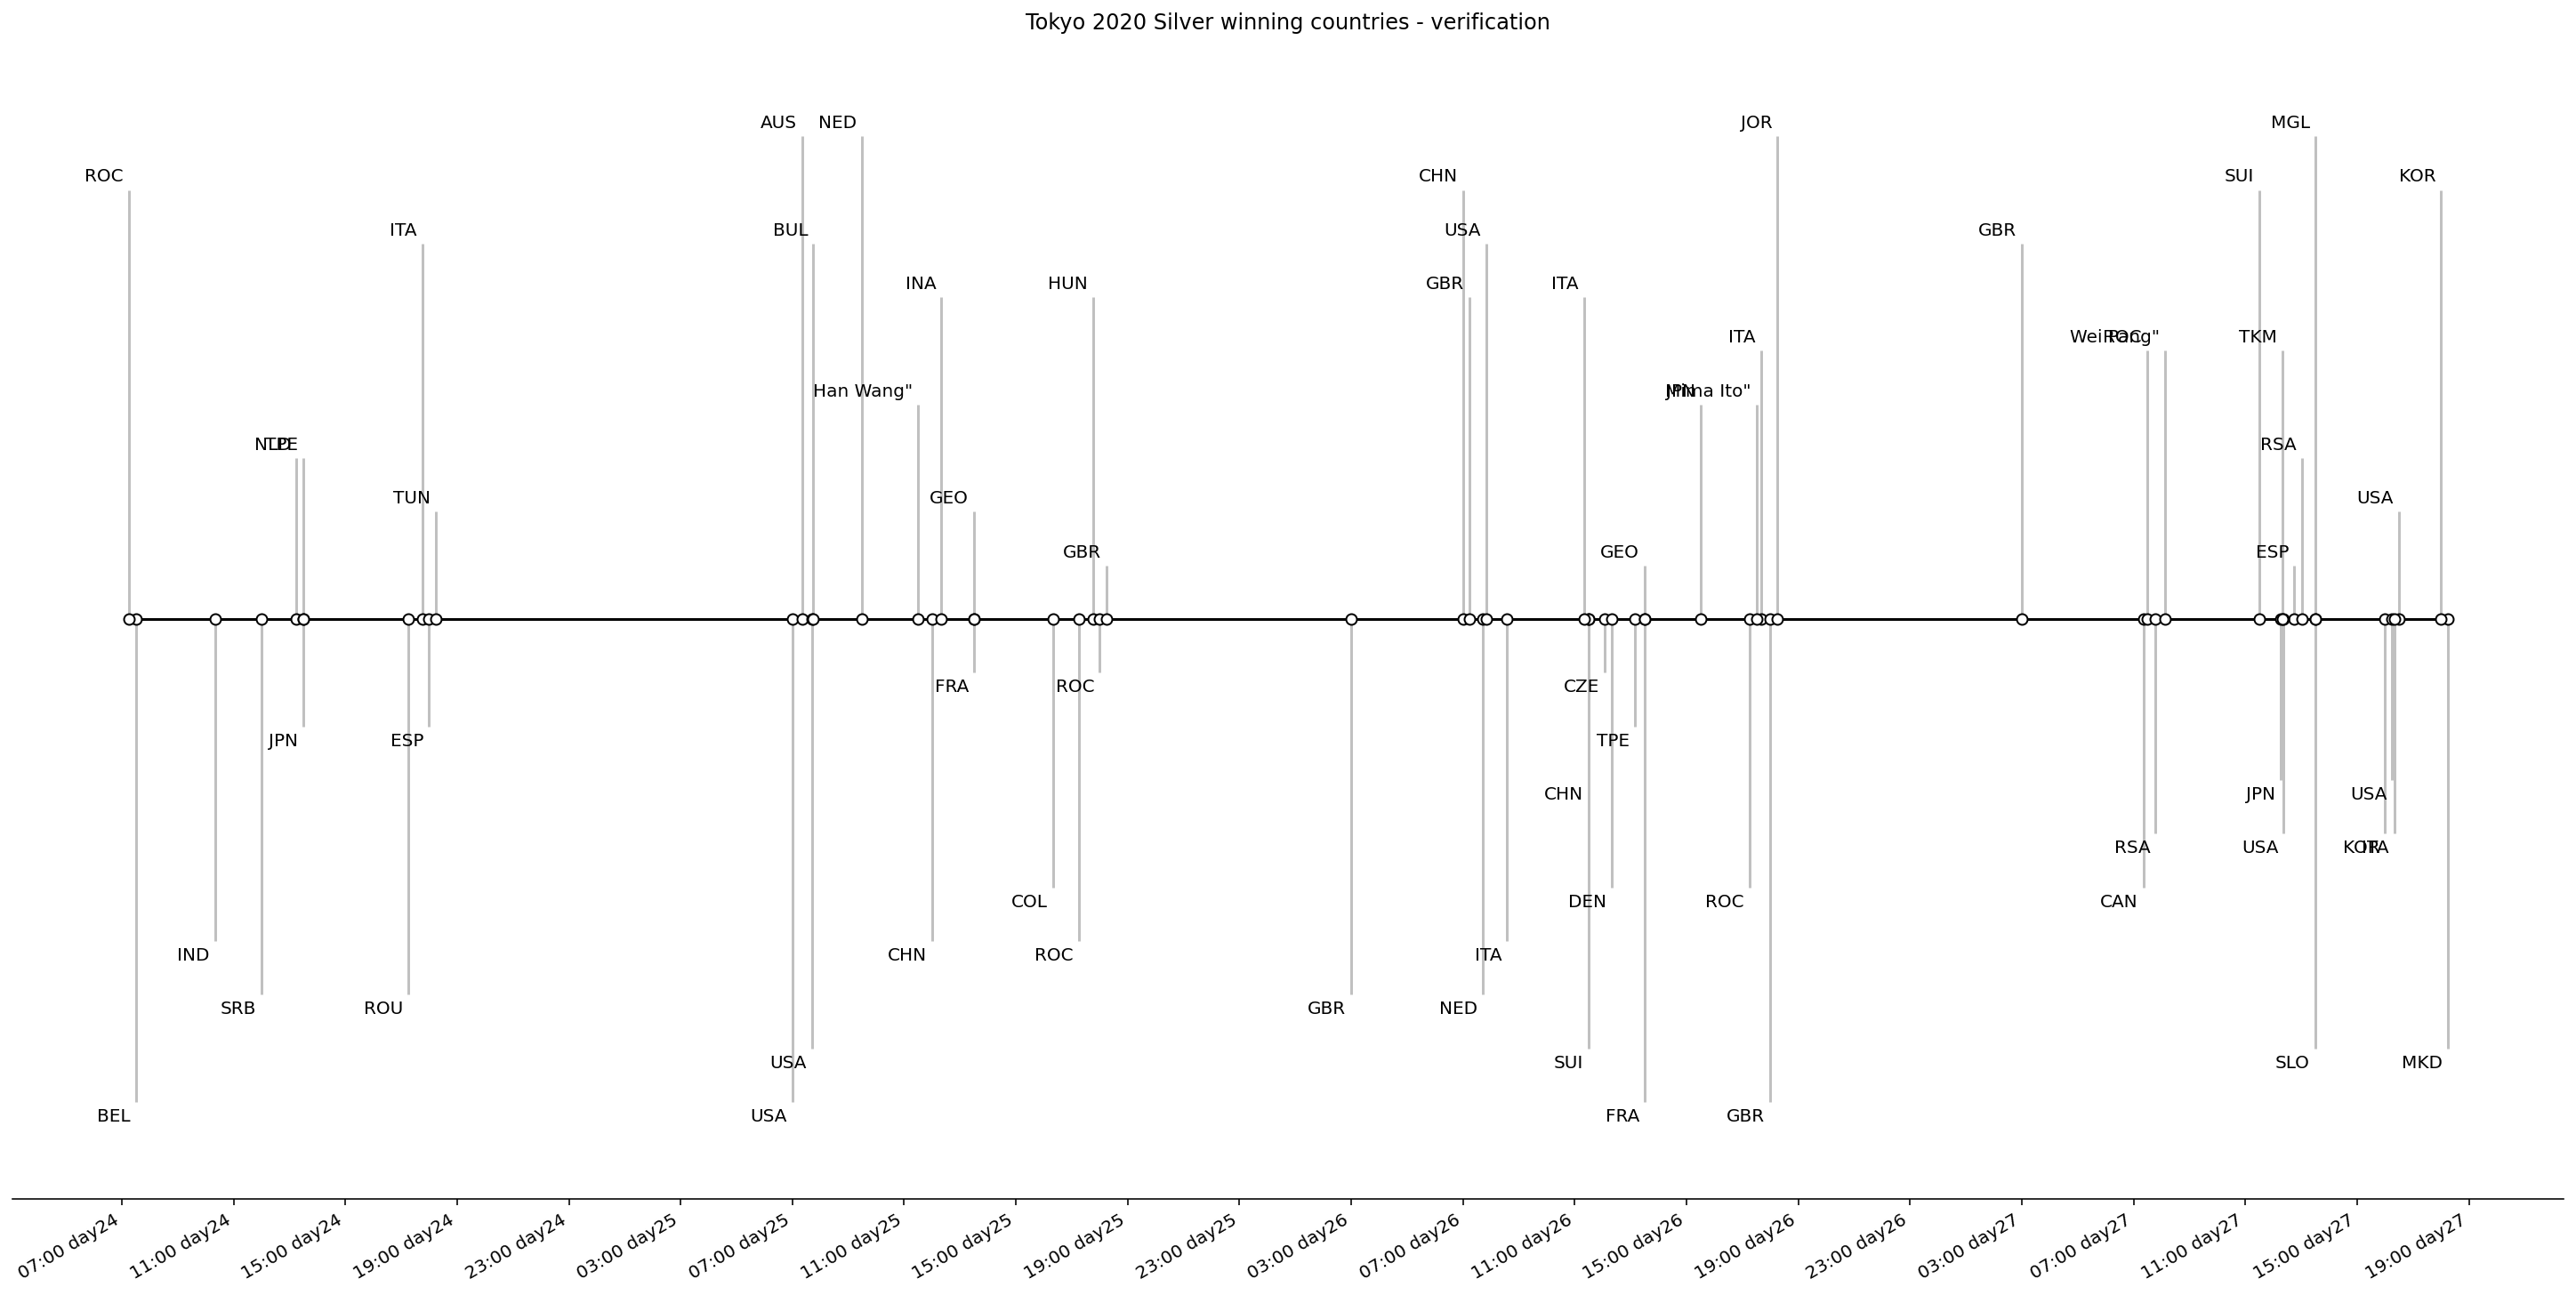

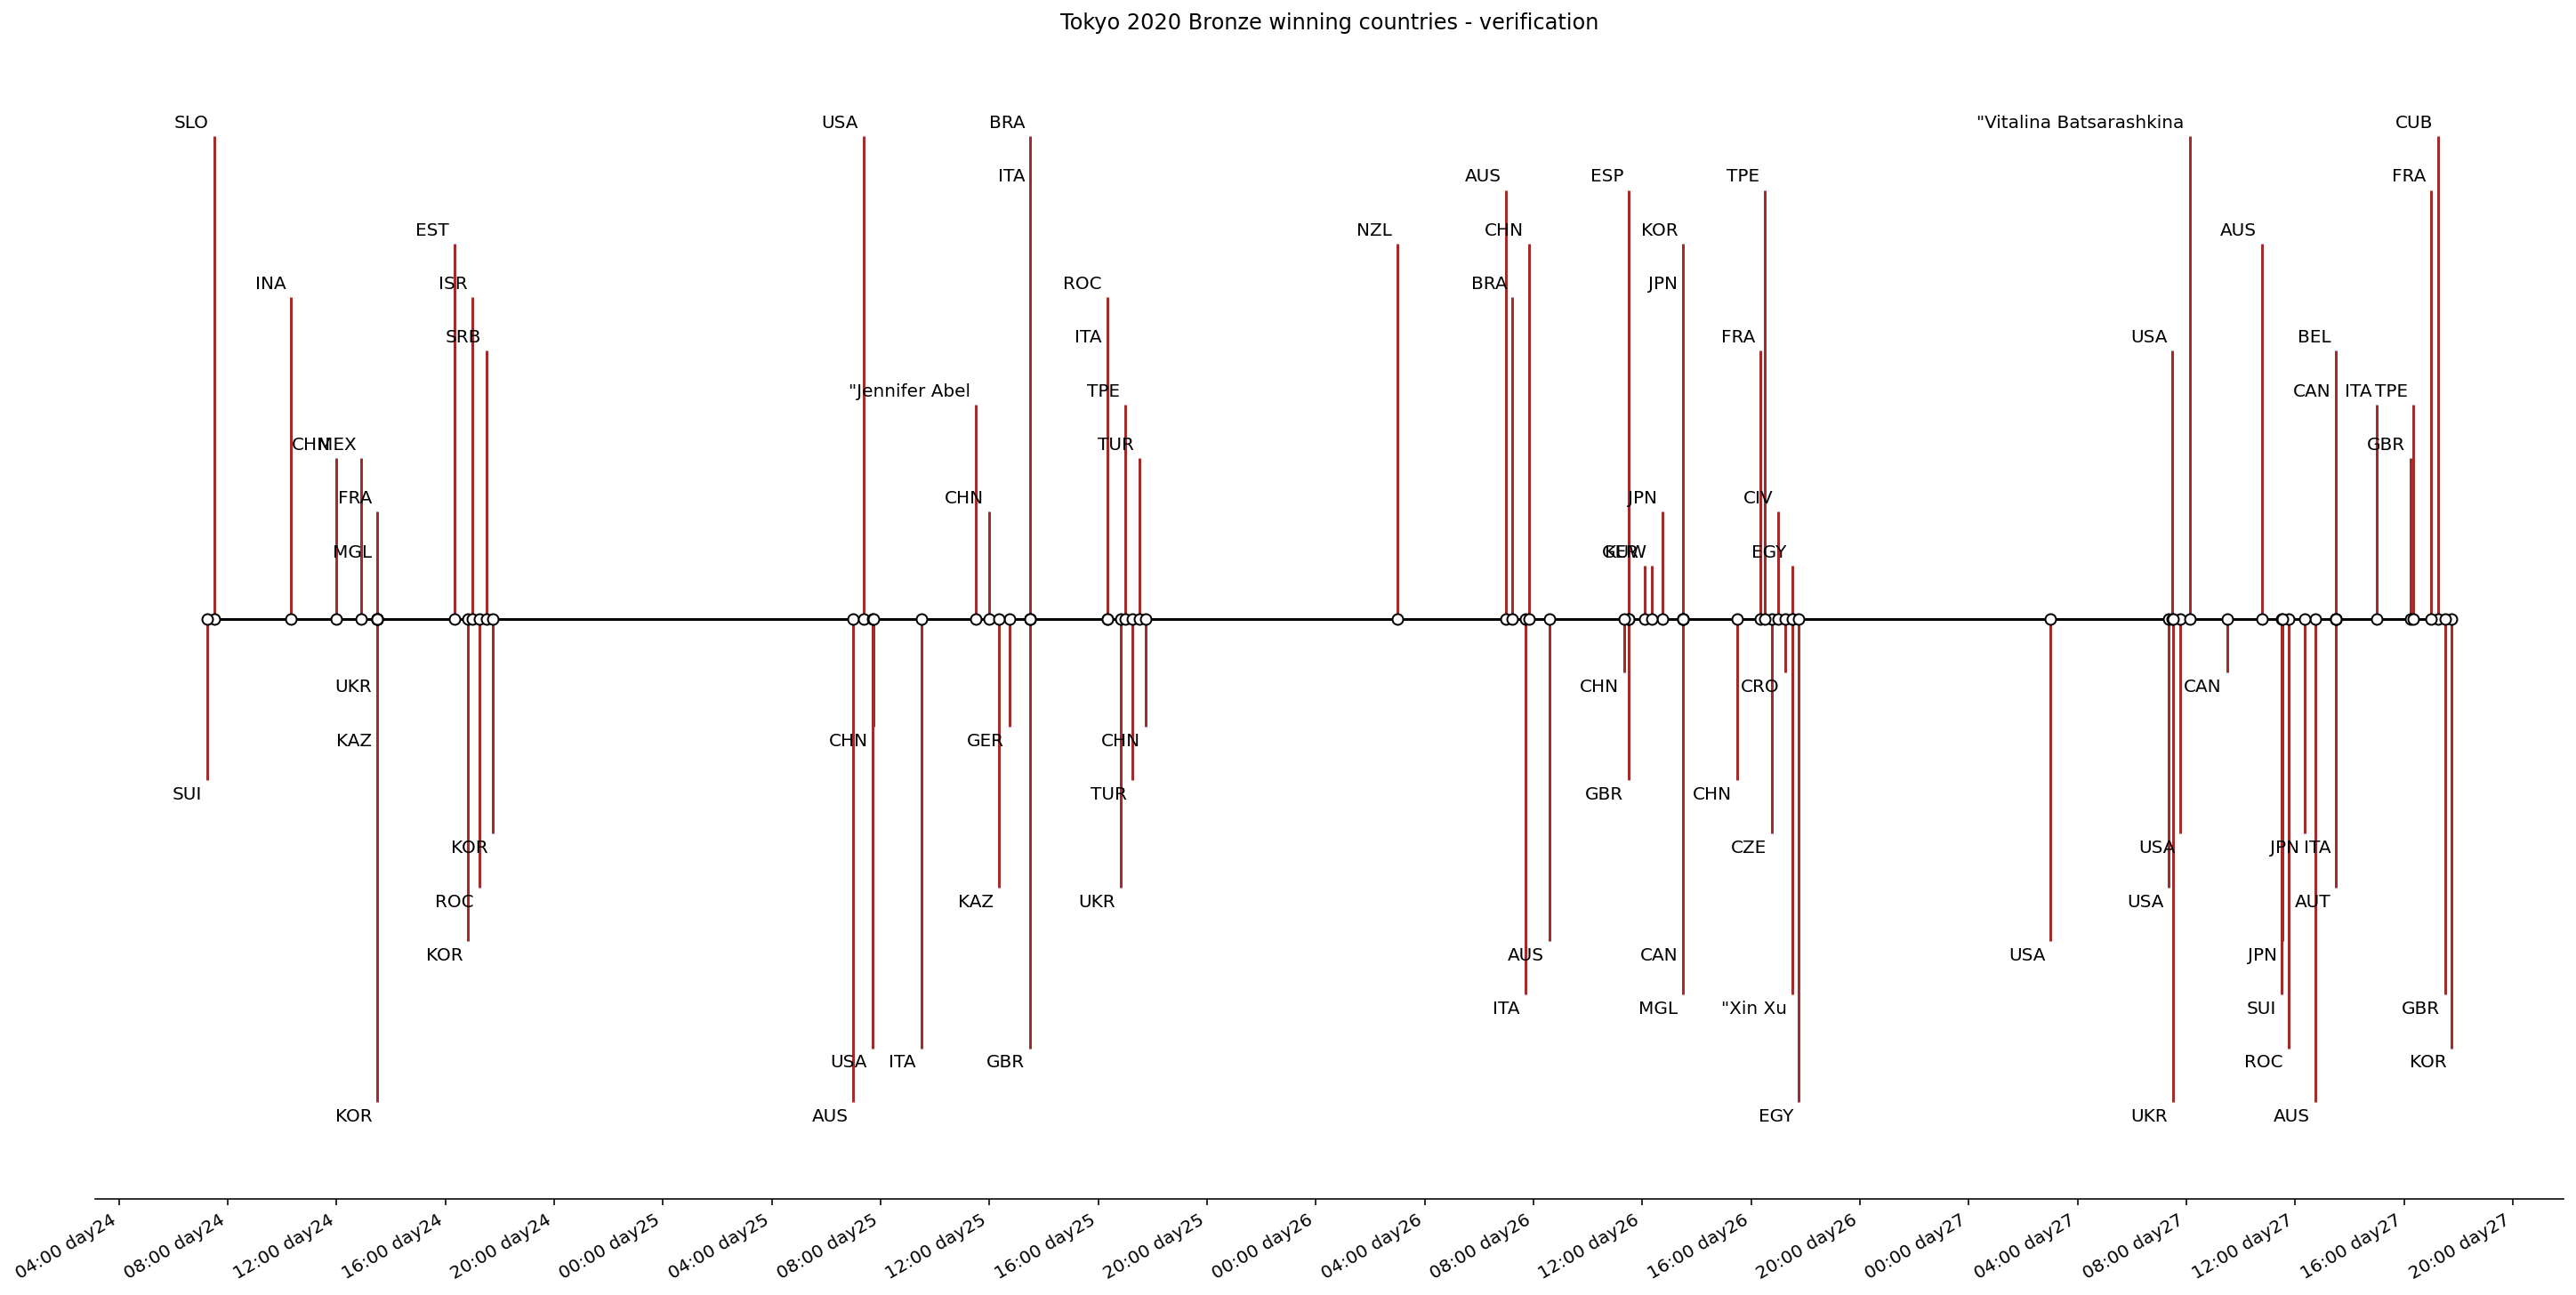

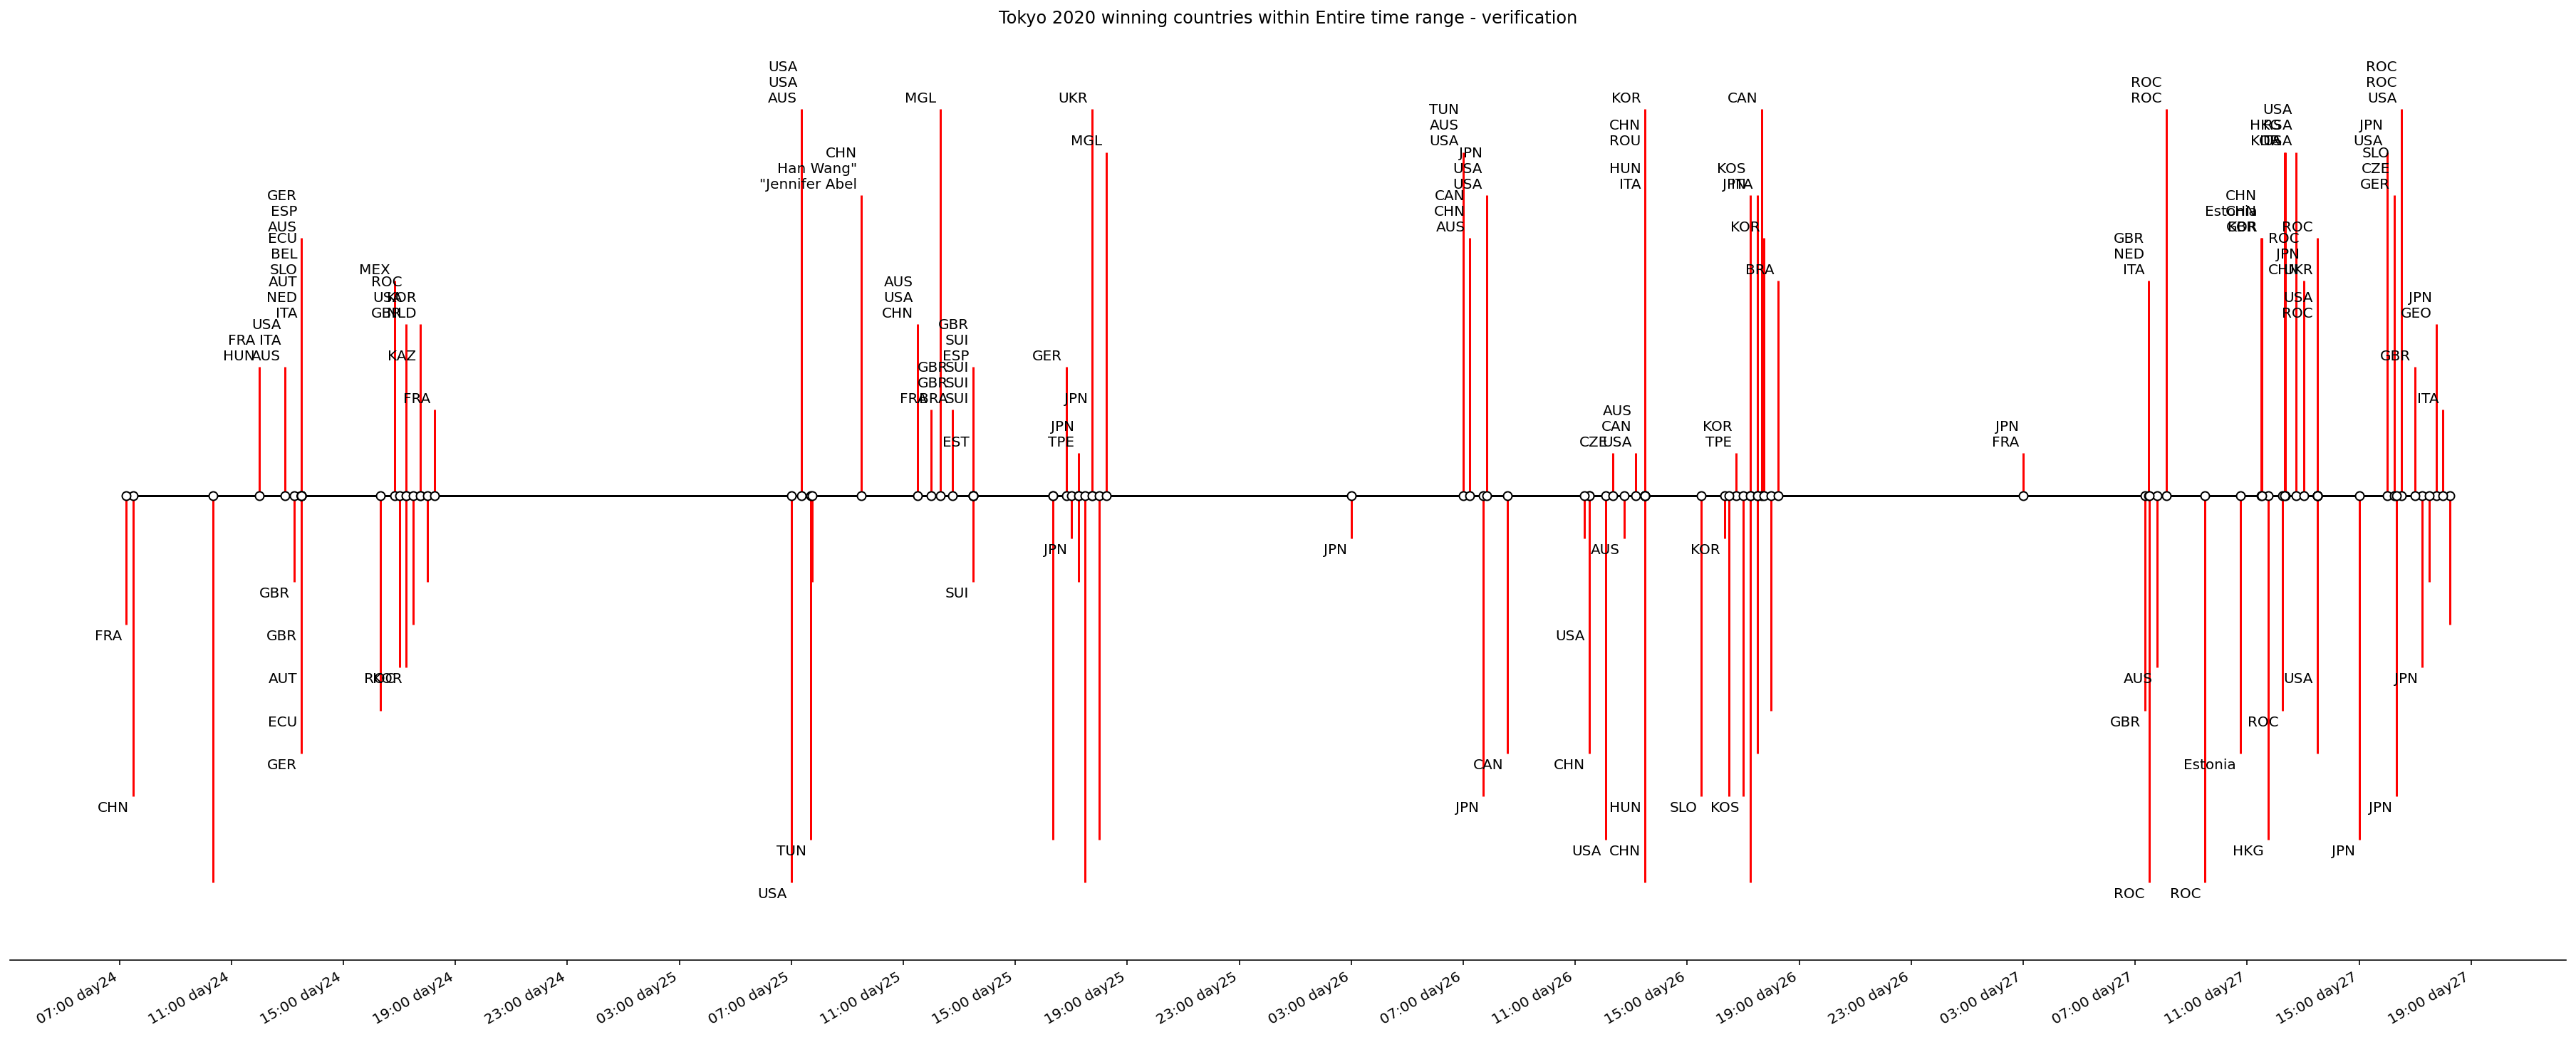

In [10]:
#Verification graphs in medals and Entire time range
plotchart(VdatesG,VCG,"Tokyo 2020 Gold winning countries - verification",color = 'gold',interval=4,density = 3,reso = (20,10))
plotchart(VdatesS,VCS,"Tokyo 2020 Silver winning countries - verification",color = 'silver',interval=4,density = 3,reso = (20,10))
plotchart(VdatesB,VCB,"Tokyo 2020 Bronze winning countries - verification",color = 'brown',interval=4,density = 3,reso = (20,10))
plotchart(Vdates,Vcon,"Tokyo 2020 winning countries within Entire time range - verification",color = 'red',interval=4,density = 3,reso = (25,10))

23
25
32
33


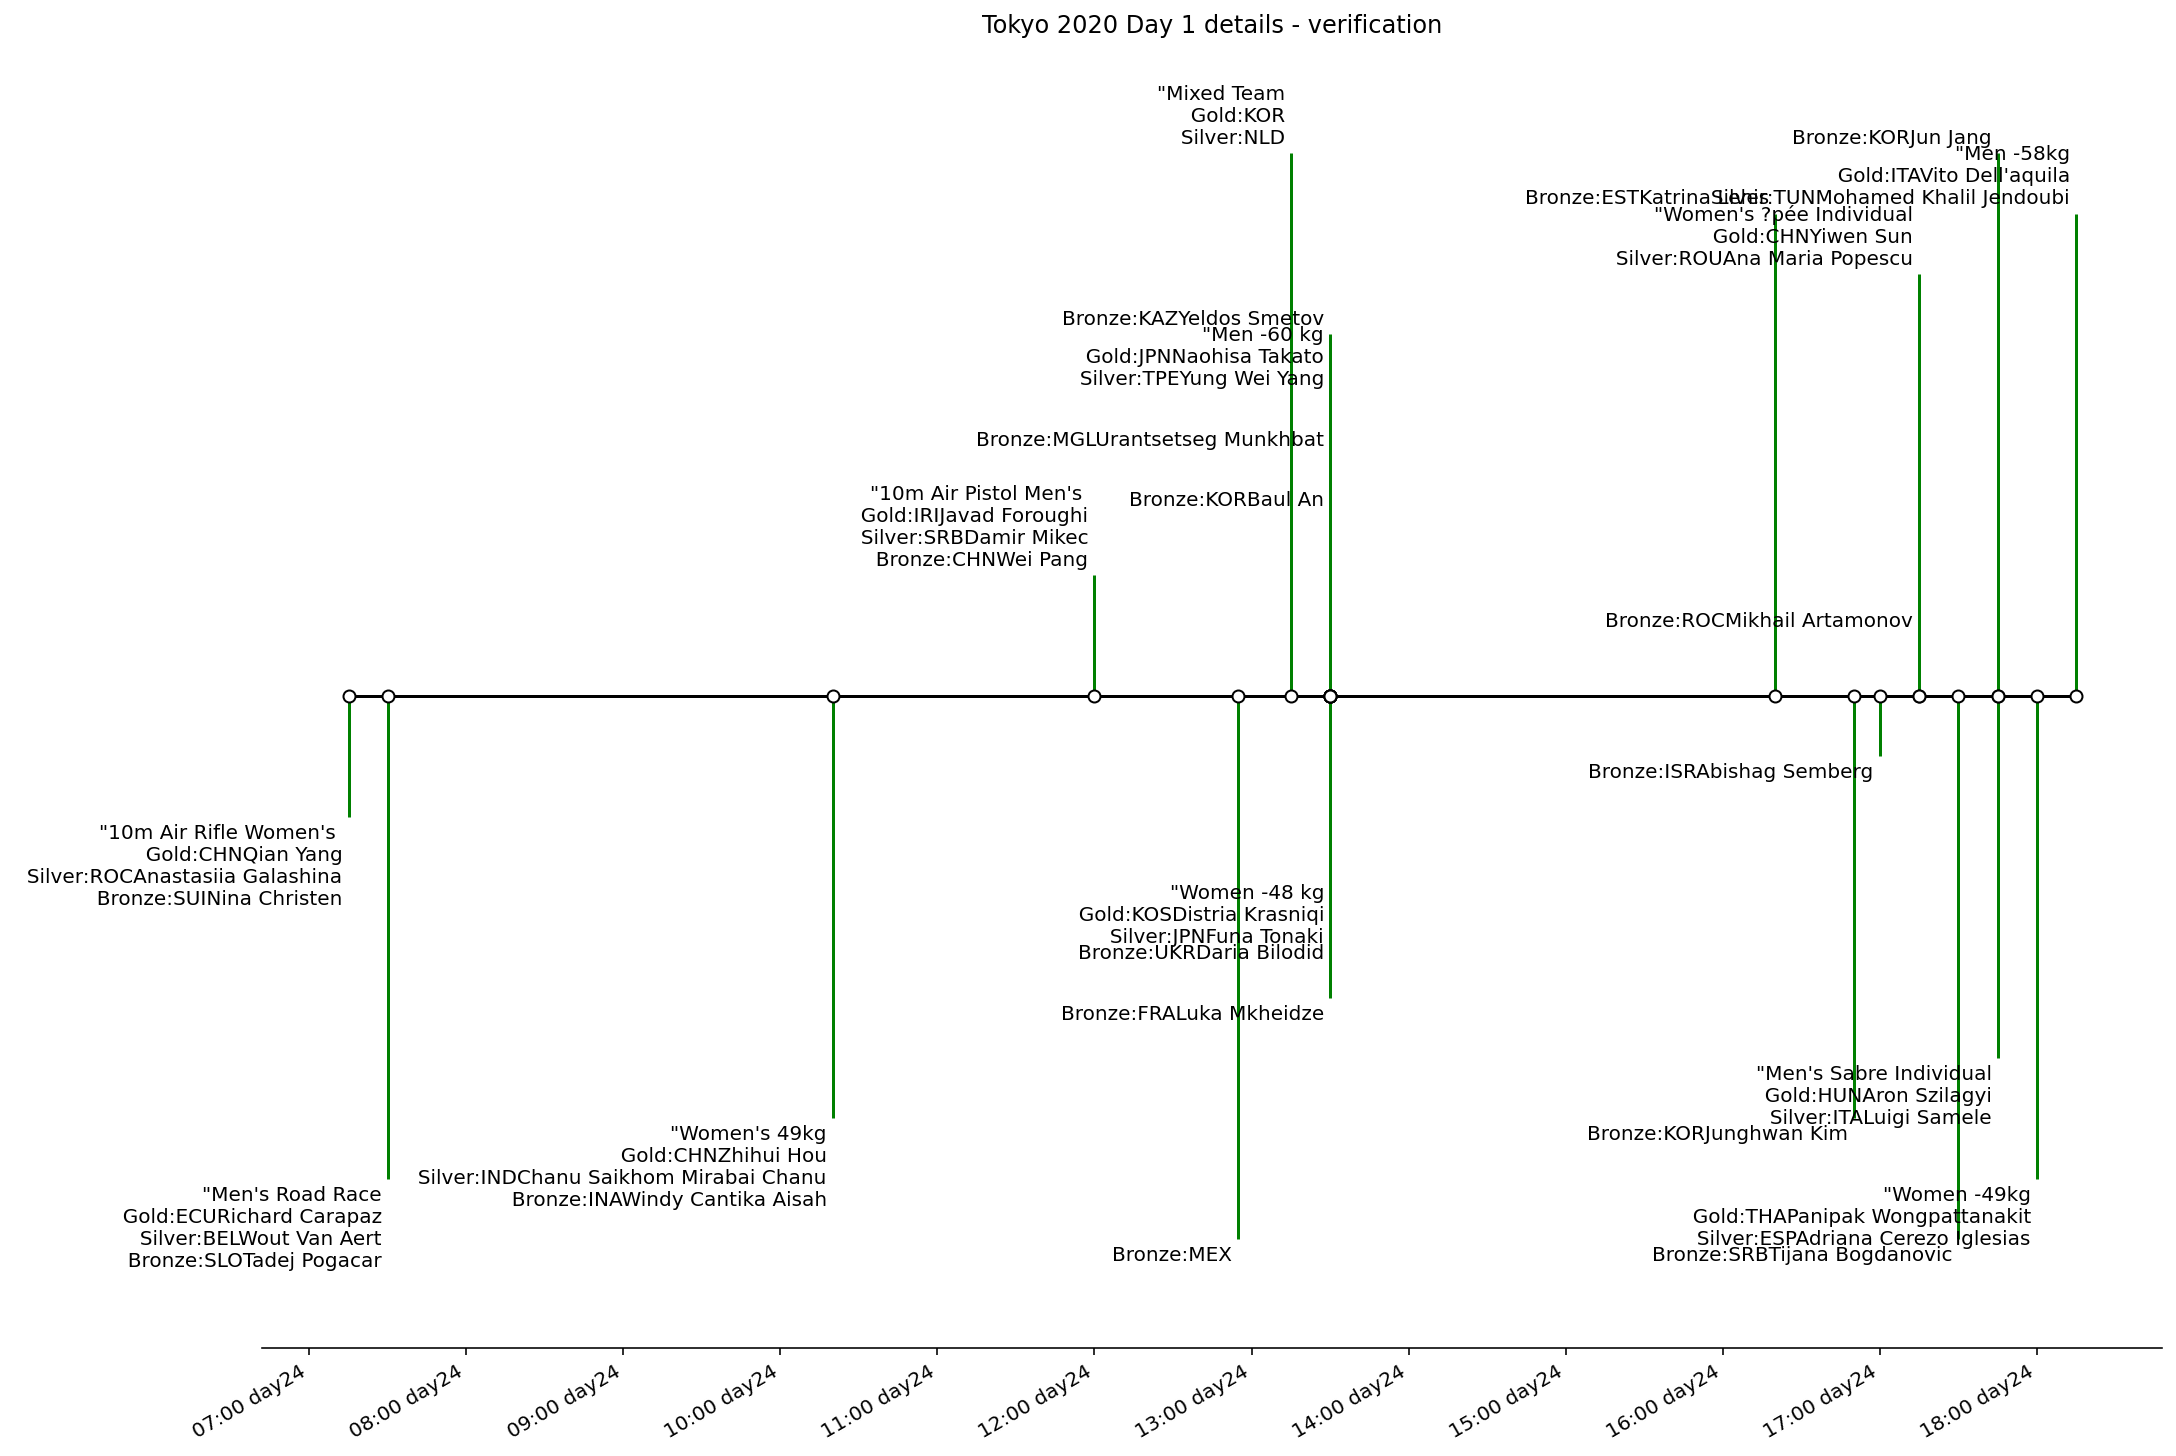

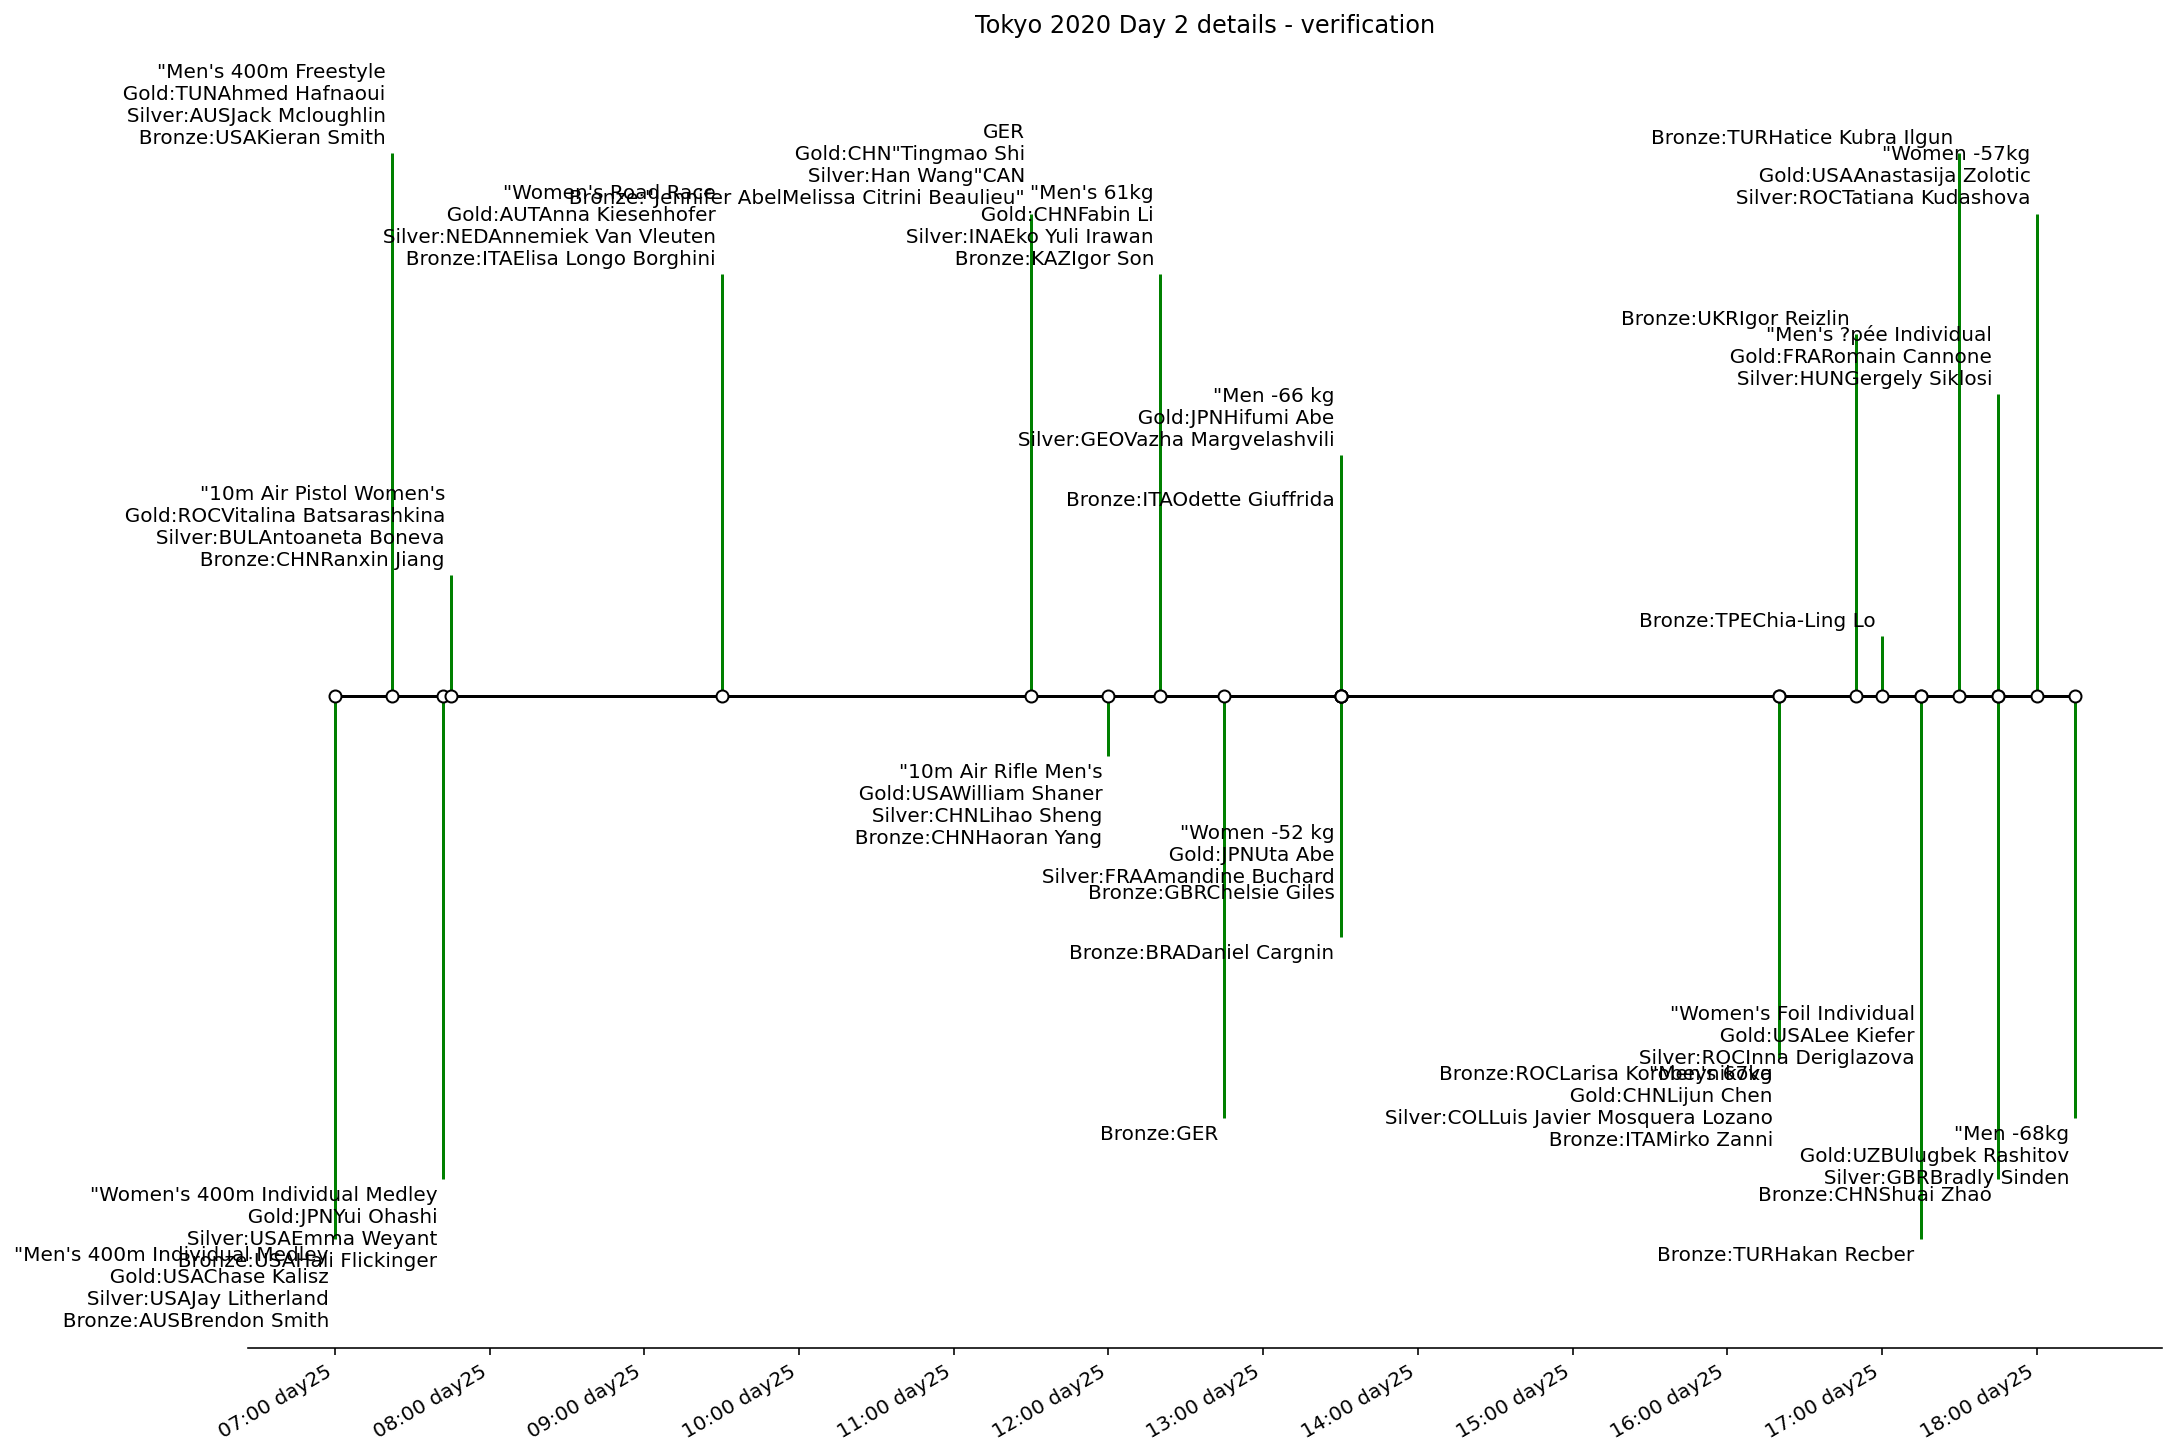

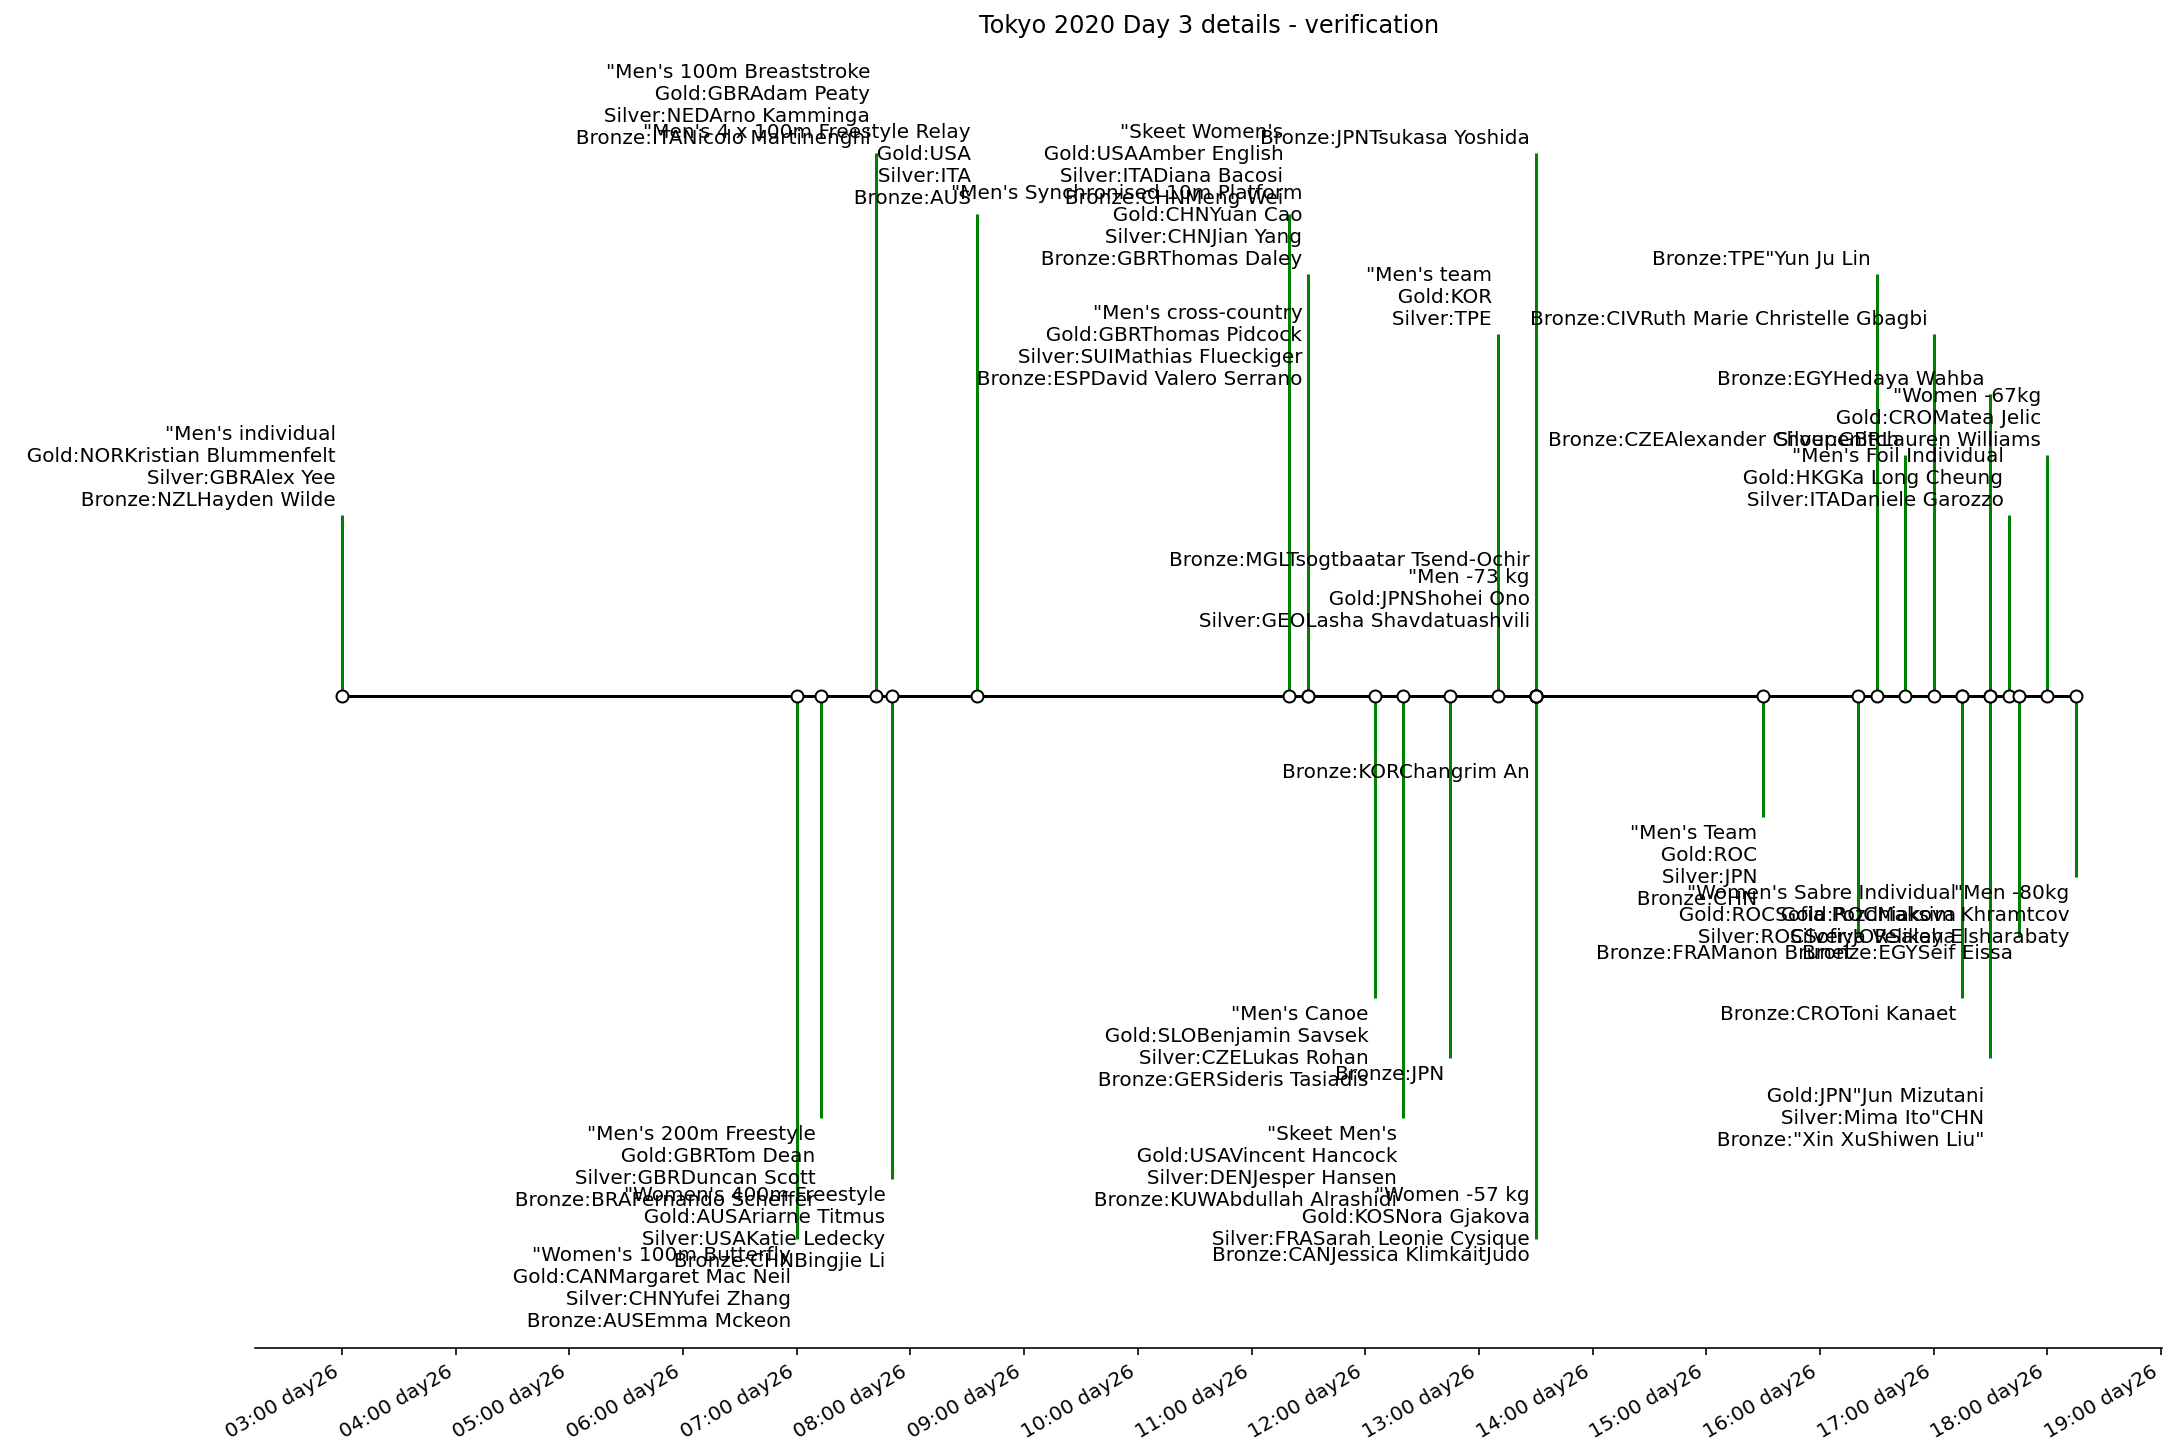

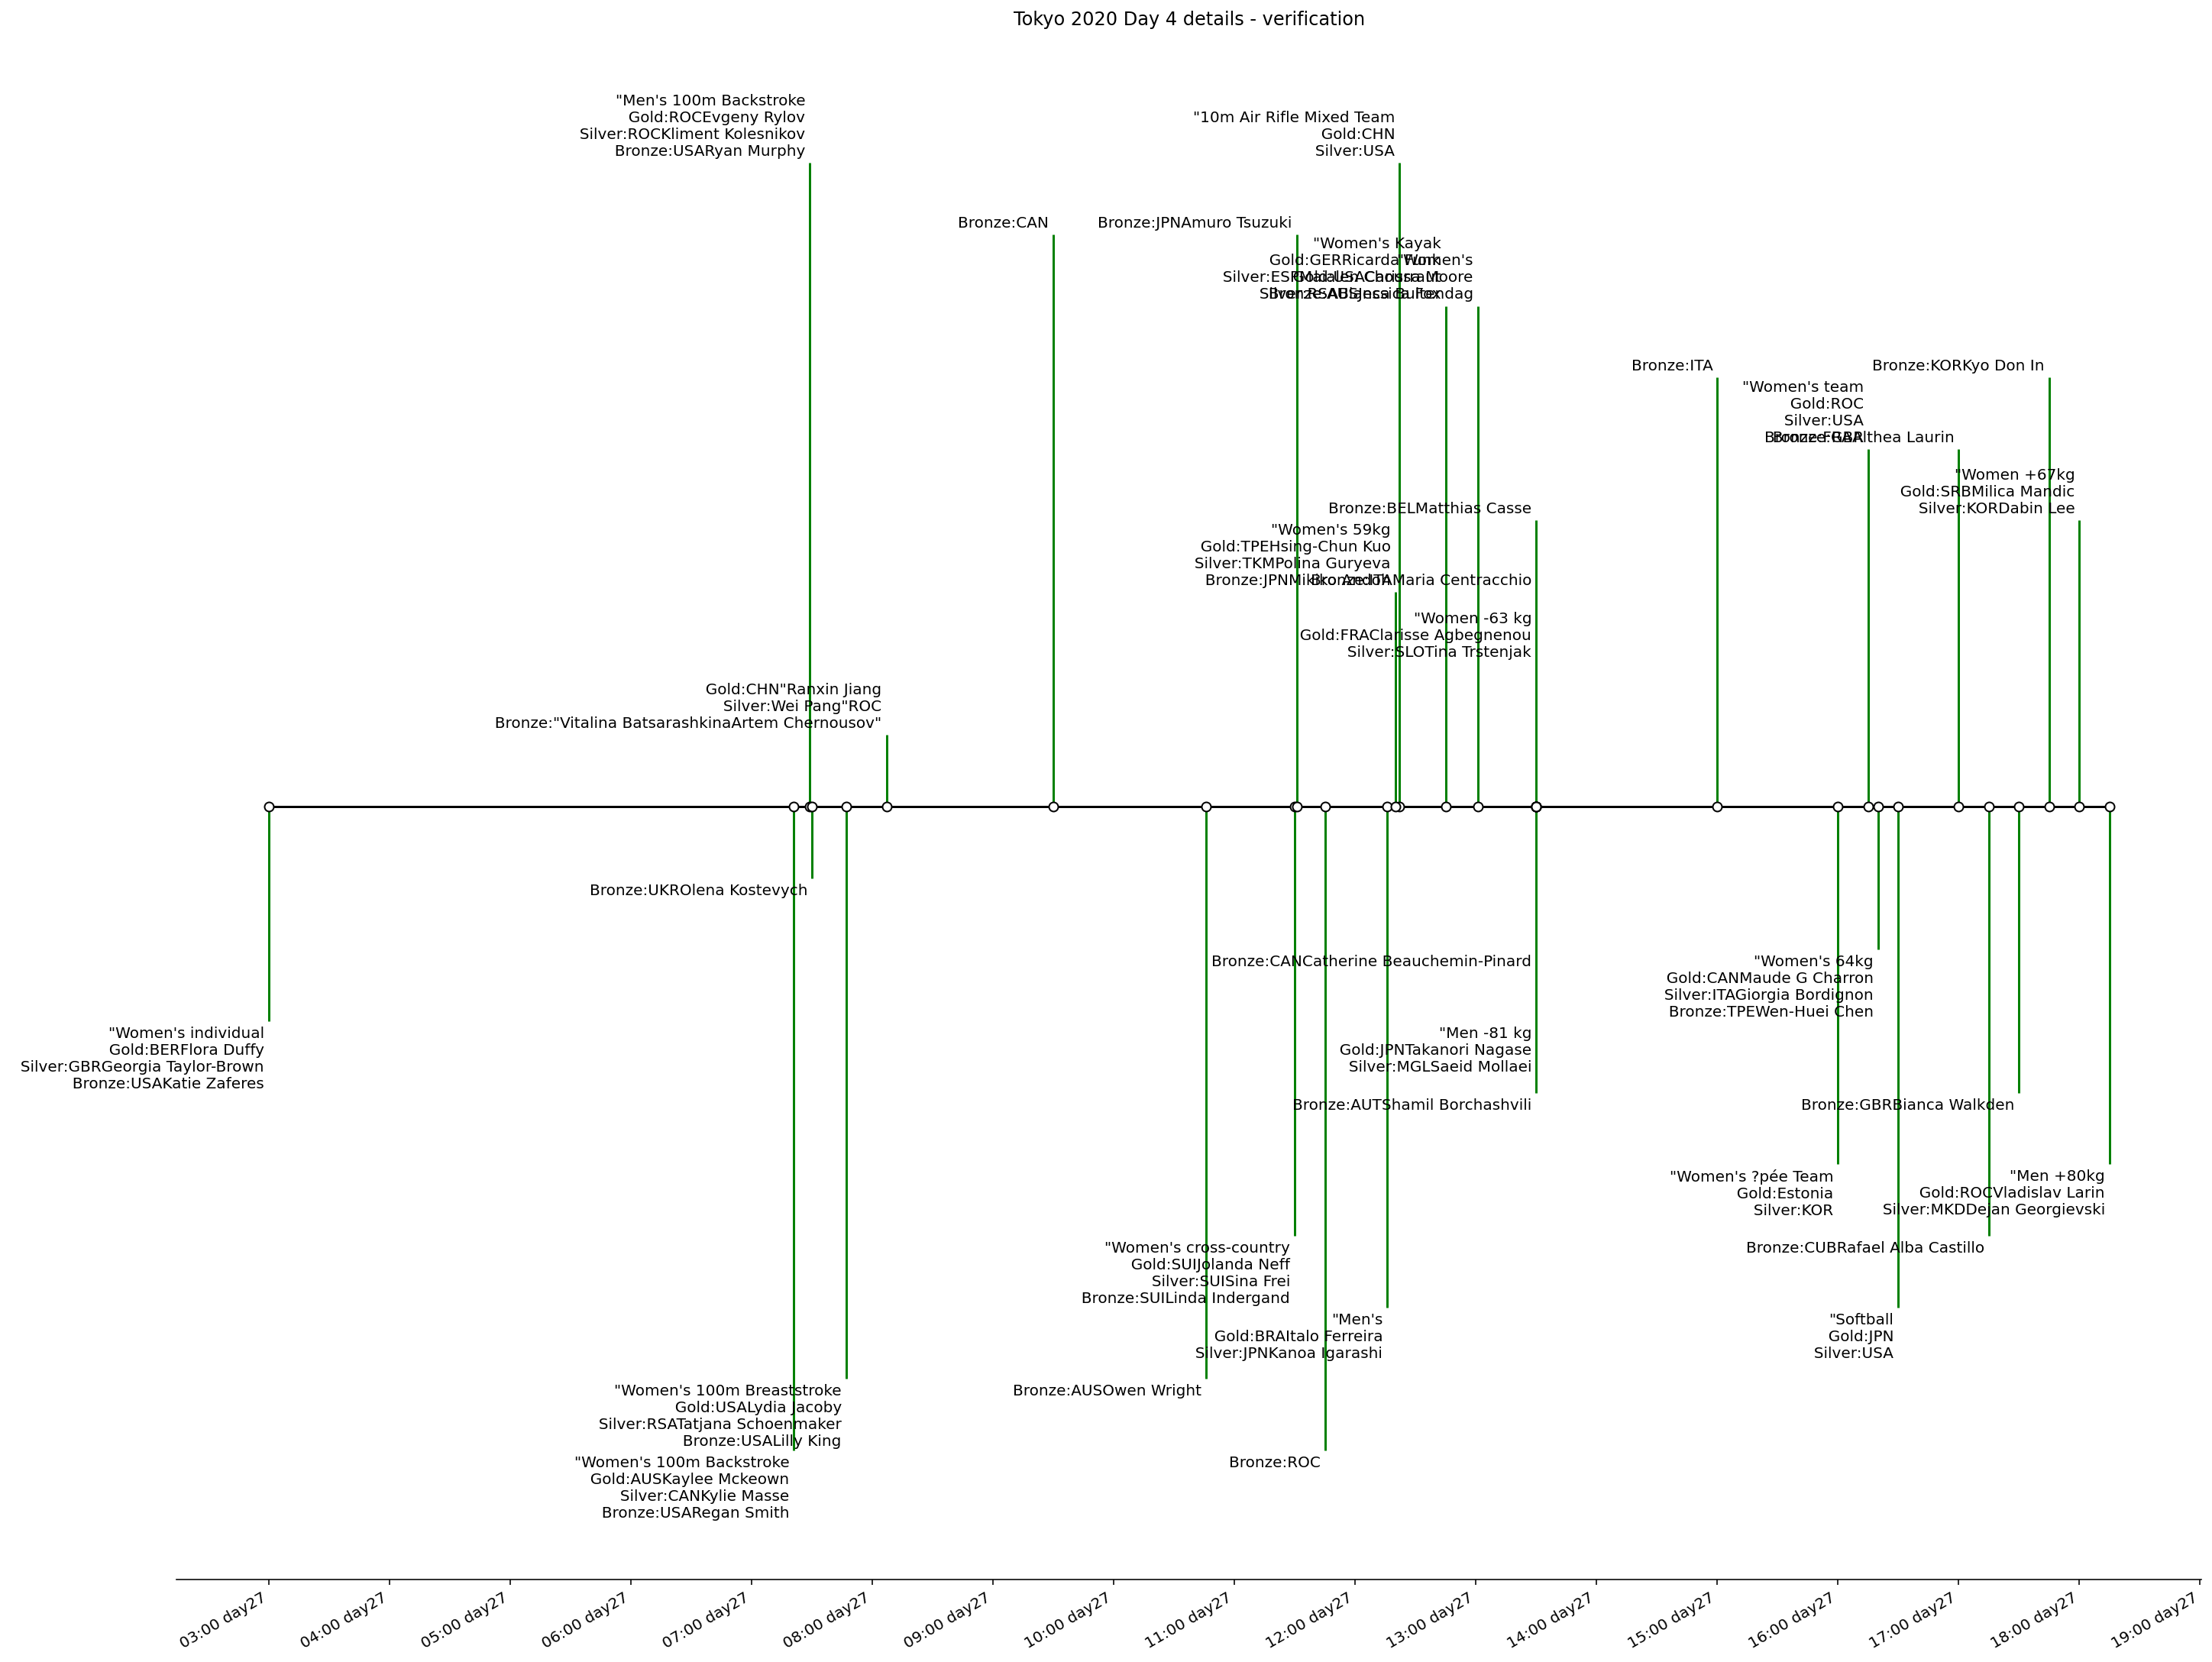

In [11]:
#Verification graphs in days
plotchart(Vdates_D1,VD1,"Tokyo 2020 Day 1 details - verification",color = 'g',interval=1,density = 3,reso = (15,10))
plotchart(Vdates_D2,VD2,"Tokyo 2020 Day 2 details - verification",color = 'g',interval=1,density = 3,reso = (15,10))
plotchart(Vdates_D3,VD3,"Tokyo 2020 Day 3 details - verification",color = 'g',interval=1,density = 3,reso = (15,10))
plotchart(Vdates_D4,VD4,"Tokyo 2020 Day 4 details - verification",color = 'g',interval=1,density = 3,reso = (20,15))
print(len(VD1))
print(len(VD2))
print(len(VD3))
print(len(VD4))